Analyze genome size changes and its contributors.

# Overview

1. Load data
2. Plot changes in genome sizes for LTEE and Kanai (Genome size evolution)
    1. raw change ( STATS: genome size change)
3. Analyze the contributors of genome size changes (Genome size compositions)
4. LTEE regression (not used). Analysis of current studies fitted against LTEE with similar IS copy number increase.
5. Analysis with adjusted genome sizes


In [1]:
import Pkg
using RCall
using Random
using DataFrames, DataFramesMeta
using Revise
using CSV
using StatsBase

In [2]:
figure_export_dir = "./exp/figs/Compare_with_previous_studies"
base_dir = "exp/multiple_runs11"
data_export_dir = "./exp/data/ins_del_analysis"
rdata_dir = "rdata/20240703_genome_size_analysis.RData"
file_prefix = "20240703_"
@rput figure_export_dir
@rput data_export_dir
@rput base_dir
@rput file_prefix
@rput rdata_dir
R"""
Sys.setlocale("LC_COLLATE","C") # order by dictionary order
library(tidyverse)
library(cowplot)
library(latex2exp)
library(stats)
library(scales)
library(lemon)
library(gghalves)
library(ggbeeswarm)
library(ggpointdensity)
library(viridis)
library(MASS)
library(sfsmisc)
library(car)
library(boot)
cbp <- c("#999999", "#E69F00", "#56B4E9", "#009E73", 
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
select <- dplyr::select
""";

┌ Warning: RCall.jl: ── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
│ ✔ dplyr     1.1.3     ✔ readr     2.1.4
│ ✔ forcats   1.0.0     ✔ stringr   1.5.0
│ ✔ ggplot2   3.4.3     ✔ tibble    3.2.1
│ ✔ lubridate 1.9.2     ✔ tidyr     1.3.0
│ ✔ purrr     1.0.2     
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
│ ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘cowplot’
│ 
│ The following object is masked from ‘package:lubridate’:
│ 
│     stamp
│ 
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘scales’
│ 
│ The following object is masked from ‘package:purrr’:
│ 
│     discard
│ 
│ The following object is masked from ‘package:readr’:
│ 
│     co

## Load genome_stats_merged 

In [3]:
# now import our data
base_dir_event_classification = joinpath(base_dir, "export/classify_IS_events")
genome_stats_df = CSV.read(joinpath(base_dir_event_classification, "genome_stats_merged.csv"), DataFrame)
genome_stats_df |> first

DataFrameRow
 Row │ IS_Detect_ID  ParentLine  SubLine  gen      file_name                   ⋯
     │ String15      Int64       Int64    String7  String                      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ L01_Anc                1        1  FACS     20231004/L01_Anc_m1.fasta   ⋯
                                                              26 columns omitted

## Load data from previous studies
### Loading Consuegra T1 

In [4]:
R"""
data_string <- "
Population	Clone	IS1	IS2a	IS3	IS4	IS30	IS150	IS186	IS600a	IS911a	New insertions
Ancestor	REL606	28	1	5	1	1	5	5	1	2	
Ara+1	11392	30 (2; 0)	-	4 (0; 1)	1 (0; 0)	1 (0; 0)	40 (35; 0)	6 (1; 0)	-	-	38
Ara+1	11393	32 (4; 0)	-	4 (0; 1)	1 (0; 0)	1 (0; 0)	40 (35; 0)	8 (3; 0)	-	-	41b
Ara+2	11342	31 (4; 1)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	8 (3; 0)	9 (4; 0)	-	-	10b
Ara+2	11343	31 (4; 1)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	8 (3; 0)	9 (4; 0)	-	-	10b
Ara+3	10953	28 (0; 0)	-	4 (0; 1)	2 (1; 0)	1 (0; 0)	5 (0; 0)	7 (2; 0)	-	-	3
Ara+3	10954	30 (2; 0)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	6 (1; 0)	7 (2; 0)	-	-	5
Ara+4	11348	28 (1; 1)	-	5 (0; 0)	3 (2; 0)	0 (0; 1)	7 (2; 0)	5 (0; 0)	-	-	5
Ara+4	11349	29 (2; 1)	-	5 (0; 0)	3 (2; 0)	1 (0; 0)	7 (2; 0)	6 (1; 0)	-	-	7
Ara+5	11367	31 (3; 0)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	15 (10; 0)	8 (3; 0)	-	-	16
Ara+5	11368	31 (3; 0)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	15 (10; 0)	8 (3; 0)	-	-	16
Ara+6	11370	27 (0; 1)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	6 (1; 0)	5 (1; 1)	-	-	2
Ara+6	11371	32 (4; 0)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	6 (1; 0)	6 (1; 0)	-	-	6
Ara–1	11330	30 (2; 0)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	12 (7; 0)	7 (2; 0)	-	-	11
Ara–1	11331	30 (2; 0)	-	5 (0; 0)	1 (0; 0)	1 (0; 0)	12 (7; 0)	7 (2; 0)	-	-	11
Ara–2	11335 S	29 (2; 1)	-	8 (3; 0)	1 (0; 0)	1 (0; 0)	21 (16; 0)	7 (2; 0)	-	-	23
Ara–2	11333 L	31 (5; 2)	-	5 (0; 0)	2 (1; 0)	1 (0; 0)	5 (0; 0)	4 (0; 1)	-	-	6
Ara–3	11364	25 (3; 6)	-	3 (1; 3)	0 (0; 1)	1 (0; 0)	25 (21; 1)	12 (7; 0)	-	-	30b
Ara–3	11365	25 (2; 5)	-	3 (1; 3)	1 (0; 0)	1 (0; 0)	25 (21; 1)	12 (7; 0)	-	-	29b
Ara–4	11336	26 (1; 3)	-	4 (0; 1)	1 (0; 0)	1 (0; 0)	5 (0; 0)	5 (1; 1)	-	-	2
Ara–4	11337	27 (2; 3)	-	4 (0; 1)	1 (0; 0)	1 (0; 0)	5 (0; 0)	5 (1; 1)	-	-	3
Ara–5	11339	31 (4; 1)	-	4 (0; 1)	1 (0; 0)	1 (0; 0)	19 (14; 0)	10 (5; 0)	-	-	23
Ara–5	11340	31 (4; 1)	-	4 (0; 1)	2 (1; 0)	1 (0; 0)	19 (14; 0)	10 (5; 0)	-	-	24
Ara–6	11389	30 (2; 0)	-	7 (2; 0)	2 (1; 0)	1 (0;0)	23 (18; 0)	7 (2; 0)	-	-	25
Ara–6	11390	33 (5; 0)	-	6 (1; 0)	2 (1; 0)	1 (0; 0)	12 (7; 0)	8 (3; 0)	-	-	17
"

# Replace '-' with '0 (0; 0)'
data_string <- str_replace_all(data_string, "-\t", "0 (0; 0)\t")
data_string <- str_replace_all(data_string, "-\n", "0 (0; 0)\n")

data <- read.delim(text = data_string, stringsAsFactors = FALSE)

# Process data
data_processed <- data %>%
  mutate(across(starts_with("IS"), list(
    number = ~str_extract(., "\\d+"),
    gain = ~str_extract(., "(?<=\\()\\d+"),
    loss = ~str_extract(., "(?<=;) \\d+(?=\\))")
  ))) %>%
  # starts with IS but does not end with number, gain, or loss
  select(Population, Clone, matches("^IS.*(number|gain|loss)")) %>%
  pivot_longer(-c(Population, Clone), names_to = c(".value", "type"), names_sep = "_") %>%
  pivot_longer(-c(Population, Clone, type), names_to = "IS") %>%
  mutate(value = as.numeric(value))%>%
  mutate(value = ifelse(is.na(value), 0, value)) %>%
  pivot_wider(names_from = type, values_from = value)

LTEE50000 <- data_processed %>% group_by(Population, Clone) %>% 
	summarise(Total = sum(number), Insertion = sum(gain), Loss = sum(loss)) %>% 
	mutate(Generations = 50000)

# add data of gen 1 as 0 ,0,0  for all population, clone pairs
LTEE50000 <- LTEE50000 %>% 
	bind_rows(cbind(LTEE50000%>%select(Population, Clone),
		data.frame(Total = 0, Insertion = 0, Loss = 0, Generations = 1)))

LTEE50000 %>% tail
"""

┌ Warning: RCall.jl: `summarise()` has grouped output by 'Population'. You can override using the
│ `.groups` argument.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 6 × 6
# Groups:   Population [3]
  Population Clone Total Insertion  Loss Generations
  <chr>      <chr> <dbl>     <dbl> <dbl>       <dbl>
1 Ara–4      11336     0         0     0           1
2 Ara–4      11337     0         0     0           1
3 Ara–5      11339     0         0     0           1
4 Ara–5      11340     0         0     0           1
5 Ara–6      11389     0         0     0           1
6 Ara–6      11390     0         0     0           1


### Load Consuegra F3ab

In [5]:
R"""
data_str <- "
generations	0	500	1000	1500	2000	5000	10000	15000	20000	30000	40000	50000
Ara+1	0	1.5	1	1	5	14	21.5	27	33	46	63.5	56.5
Ara+2	0	0	1	1.5	3	4.5	8	10	11	15	16	17.5
Ara+4	0	0	0.5	0.5	1.5	1	1	2	5	4.5	7.5	8
Ara+5	0	0.5	1	1.5	2	9	5	11.5	8	16	20	20.5
Ara‒5	0	1	1	1.5	2.5	5	12.5	11	15	33.5	23.5	30.5
Ara‒6 	0	1	1	1	1	1	7.5	8.5	12.5	18.5	24.5	27
Ara+3*	0	0.5	1.5	1.5	3	2	4.5	2.5	2	5.5	4	6.5
Ara+6*	0	0.5	0.5	0.5	1	1	2.5	5	4.5	6	8	9
Ara‒1*	0	1	1	1.5	1.5	2.5	3.5	7	7.5	6	9.5	9.5
Ara‒2*	0	1	0	1	1	1.5	2.5	4.5	6	5	13	16.5
Ara‒3* 	0	1.5	2	2.5	6	8	12.5	13.5	20	18.5	43.5	46.5
Ara‒4* 	0	0	0.5	1	1	2	2	3.5	3	6	7	9.5
"
c.f.3ab <- read_delim(data_str, delim = "\t", col_names = TRUE) %>%
 mutate(generations = str_replace(generations, "\\*", "")) %>%
 mutate(generations = str_replace(generations, "‒", "-")) %>%
 mutate(generations = str_replace(generations, " ", "")) %>%
 pivot_longer(-generations, names_to = "Generations", values_to = "Event_CNT") %>%
 mutate(Generations = as.integer(Generations)) %>%
 rename(Population = generations)
print(c.f.3ab)
"""

# A tibble: 144 × 3
   Population Generations Event_CNT
   <chr>            <int>     <dbl>
 1 Ara+1                0       0  
 2 Ara+1              500       1.5
 3 Ara+1             1000       1  
 4 Ara+1             1500       1  
 5 Ara+1             2000       5  
 6 Ara+1             5000      14  
 7 Ara+1            10000      21.5
 8 Ara+1            15000      27  
 9 Ara+1            20000      33  
10 Ara+1            30000      46  
# ℹ 134 more rows


┌ Warning: RCall.jl: Rows: 12 Columns: 13
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: "\t"
│ chr  (1): generations
│ dbl (12): 0, 500, 1000, 1500, 2000, 5000, 10000, 15000, 20000, 30000, 40000,...
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 144 × 3
   Population Generations Event_CNT
   <chr>            <int>     <dbl>
 1 Ara+1                0       0  
 2 Ara+1              500       1.5
 3 Ara+1             1000       1  
 4 Ara+1             1500       1  
 5 Ara+1             2000       5  
 6 Ara+1             5000      14  
 7 Ara+1            10000      21.5
 8 Ara+1            15000      27  
 9 Ara+1            20000      33  
10 Ara+1            30000      46  
# ℹ 134 more rows


### Loading Lee T2

In [6]:
R"""
library(janitor)
data_str <- "Strain	Disrupted_pathway	Description	Lines	Generations	Insertion_num	Insertion_rate	Recombination_num	Recombination_rate
PFM2		WT @3Kgen	38	3080	21	1.79	1	0.85
PFM2		WT @6K gen	21	6356	39	2.92	2	1.59
PFM2		WT on min. medium	44	6166	83	3.1	8	2.99
PFM5	MMR	mutL	34	375	10	7.84	1	7.84
PFM101	TLS	umuDC dinB	39	6078	95	4.03	12	5.09
PFM133	TLS	umuDC dinB polB	43	6204	108	4.07	12	4.52
PFM35	NER + TCR	uvr A	23	6350	63	4.37	7	4.85
PFM40	ALK	alkA tag. A	37	6225	81	3.56	16	7.04
PFM88	ALK	ada ogt	47	6269	113	3.88	16	5.5
PFM180	BER	xthA nfo	40	3155	37	2.95	12	9.58
PFM61	OXDR	mutT	25	599	6	4.62	0	0
PFM6	OXDR	mut Y	25	1972	14	2.96	2	4.23
PFM22	BER	nth nei	50	920	6	1.43	0	0
PFM91	BER	nfi	29	6308	65	3.6	5	2.77
PFM94	OXDR	mut Y mutM	25	1916	17	3.7	4	8.71
Total			520	4186	758	3.5	98	4.5

"

fosterMA <- read_delim(data_str, delim = "\t", col_names = TRUE) %>%
  clean_names()%>%
  #select rows after lines and change to numeric
  mutate_at(vars(lines:recombination_rate), as.numeric)
"""

┌ Warning: RCall.jl: 
│ Attaching package: ‘janitor’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     chisq.test, fisher.test
│ 
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: Rows: 16 Columns: 9
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: "\t"
│ chr (3): Strain, Disrupted_pathway, Description
│ dbl (6): Lines, Generations, Insertion_num, Insertion_rate, Recombination_nu...
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 16 × 9
   strain disrupted_pathway description       lines generations insertion_num
   <chr>  <chr>             <chr>             <dbl>       <dbl>         <dbl>
 1 PFM2   <NA>              WT @3Kgen            38        3080            21
 2 PFM2   <NA>              WT @6K gen           21        6356            39
 3 PFM2   <NA>              WT on min. medium    44        6166            83
 4 PFM5   MMR               mutL                 34         375            10
 5 PFM101 TLS               umuDC dinB           39        6078            95
 6 PFM133 TLS               umuDC dinB polB      43        6204           108
 7 PFM35  NER + TCR         uvr A                23        6350            63
 8 PFM40  ALK               alkA tag. A          37        6225            81
 9 PFM88  ALK               ada ogt              47        6269           113
10 PFM180 BER               xthA nfo             40        3155            37
11 PFM61  OXDR              m

In [7]:
R""" # note that the foster definition of insertion is is basically related event
LTEE_ <- LTEE50000 %>% filter(Population != "Ancestor") %>%
	mutate(Insertion = Insertion- Loss) %>%
	select(Population, Generations, Insertion) %>%
	mutate(Source = "LTEE")
Foster_ <- fosterMA %>% filter(strain != "Total") %>%
	mutate(Population = description, Generations = generations, Insertion = (insertion_num)/lines) %>%
	select(Population, Generations, Insertion)
# add dummy data for ancestor for every row
Foster_ <- Foster_ %>% 
	bind_rows(cbind(Foster_%>%select(Population, Generations),
		data.frame(Insertion = 0))) %>%
	mutate(Source = "Foster")
"""

RObject{VecSxp}
# A tibble: 30 × 4
   Population        Generations Insertion Source
   <chr>                   <dbl>     <dbl> <chr> 
 1 WT @3Kgen                3080     0.553 Foster
 2 WT @6K gen               6356     1.86  Foster
 3 WT on min. medium        6166     1.89  Foster
 4 mutL                      375     0.294 Foster
 5 umuDC dinB               6078     2.44  Foster
 6 umuDC dinB polB          6204     2.51  Foster
 7 uvr A                    6350     2.74  Foster
 8 alkA tag. A              6225     2.19  Foster
 9 ada ogt                  6269     2.40  Foster
10 xthA nfo                 3155     0.925 Foster
# ℹ 20 more rows


### LTEE data curated by Barrick lab

In [8]:
R"""
#+1+2+4+5-3-5-6
LTEE.nonmutator <- c("Ara-5", "Ara-6", "Ara+1", "Ara+2", "Ara+4", "Ara+5")
# The status of Ara-3 is ambiguous as it is a non-mutator in Barrick lab data but a mutator in Tenaillon 2016 and Consuegra 2021
"""

RObject{StrSxp}
[1] "Ara-5" "Ara-6" "Ara+1" "Ara+2" "Ara+4" "Ara+5"


In [9]:
R"""
LTEE.df <- read_csv("../misc/count.LTEE.masked.csv")
"""

┌ Warning: RCall.jl: Rows: 303 Columns: 136
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr   (6): file, sample, treatment, population, clone, MUTATOR_STATUS
│ dbl (130): time, total, base_substitution, small_indel, large_deletion, larg...
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 303 × 136
   file             sample treatment population  time clone MUTATOR_STATUS total
   <chr>            <chr>  <chr>     <chr>      <dbl> <chr> <chr>          <dbl>
 1 Ara+1_500gen_76… Ara+1… LTEE      Ara+1        500 A     non-mutator        4
 2 Ara+1_500gen_76… Ara+1… LTEE      Ara+1        500 B     non-mutator        3
 3 Ara+1_1000gen_9… Ara+1… LTEE      Ara+1       1000 A     non-mutator        4
 4 Ara+1_1000gen_9… Ara+1… LTEE      Ara+1       1000 B     non-mutator        2
 5 Ara+1_1500gen_1… Ara+1… LTEE      Ara+1       1500 A     non-mutator        7
 6 Ara+1_1500gen_1… Ara+1… LTEE      Ara+1       1500 B     non-mutator        6
 7 Ara+1_2000gen_1… Ara+1… LTEE      Ara+1       2000 A     non-mutator        8
 8 Ara+1_2000gen_1… Ara+1… LTEE      Ara+1       2000 B     non-mutator        9
 9 Ara+1_5000gen_2… Ara+1… LTEE      Ara+1       5000 A     IS-mutator        23
10 Ara+1_5000gen_2… Ara+1… LTEE      Ara+1       5000 B     IS-mutator 

### Hawkey 2020 Plos Gen
S1 Table. Features of selected reference genomes.
https://doi.org/10.1371/journal.pgen.1008931.s024

In [10]:
R"""
hawkey2020pgen.ts1 <- "
genome	accession	chromosome size(bp)	intact CDS	pseudogenes	Total IS count	IS per 100kbp	Total bp in IS	%bp in IS	IS1 copies	IS2 copies	IS4 copies	IS600 copies	IS911 copies	Other IS, total copies	Other IS present	%IS1	Total copies of 5 common IS	%IS accounted for by the 5 common IS	Median IS1 count in population	Median IS2 count in population	Median IS4 count in population	Median IS600 count in population	Median IS911 count in population
E. coli O104:H4 str. C227-11	CP011331	5292862	5125	133	36	0.685815264	43635	0.824412199	10	0	0	1	0	25	IS100kyp, IS1203, IS26, IS421, IS609, IS621, ISEc8, ISEc23, ISEc38, ISEc4, ISKpn26	28%	11	31%	0	0	0	0	0
E. coli O157:H7 str. EDL933	NZ_CP008957	5547323	5547	272	30	0.545886888	51679	0.931602504	2	0	0	0	0	28	IS1203, IS609, IS682, ISEc1, ISEc8	7%	2	7%	1	0	0	0	0
E. coli O25b:H4-ST131	HG941718	5109767	4981	69	11	0.216211711	22161	0.433698836	2	0	1	0	0	8	ISEc12, ISEc23, ISEc38, IS609	18%	3	27%	4	0	1	0	0
S. boydii Sb227	NC_007613	4574284	5139	215	348	8.280304487	371540	8.122364068	160	33	16	20	26	93	IS1203, IS629, ISEc8, ISEc20, ISSso1, ISSso4, ISSso6	46%	255	73%	NA	NA	NA	NA	NA
S. dysenteriae Sd197	NC_007606	4369232	4270	293	373	9.255449922	339174	7.762783025	272	25	10	54	12	0	ISEc8	73%	373	100%	117	22	9	40	9
S. flexneri 2a str. 301	AE005674	4607202	4436	255	229	5.253446685	248159	5.386327754	105	29	18	35	16	26	IS1203, IS150, IS609, ISEc17, ISEhe3, ISSfl3, ISSfl4	46%	203	89%	85	28	19	32	11
S. sonnei 53G	NC_016882	4988504	4967	199	331	7.165577001	369197	7.400956279	165	23	32	52	5	54	IS21, IS609, IS630, ISEc20, ISSo1, ISSo4, ISSso6	50%	277	84%	141	29	28	39	5
E. coli EIEC ST6 str. NCTC10959	NCTC10959	4621727	4721	150	218	4.993476412	256031	5.539725735	70	28	6	11	1	102	IS100kyp, IS150, IS186B, IS21, IS3411, IS609, IS630, IS679, IS682, ISCro1, ISEc1, ISEc20, ISEc23, ISEc38, ISEc47, ISEc60, ISSfl3, ISSfl4, ISSso1, ISSso6	32%	116	53%	64	16	10	4	5
E. coli EIEC ST99 str. CFSAN029787	CP011416	4947515	5103	115	93	1.9277524	123244	2.491028324	5	7	4	11	2	64	IS100kyp, IS1203, IS150, IS21, IS26, IS609, IS629, IS630, IS682, ISCro1, ISEc1, ISEc20, ISEc23, IS43, ISEc47, ISEc60, ISSfl3, ISSfl4, ISSfl7, ISSso1, ISSo6	5%	29	31%	2	6	0	7	0
E. coli EIEC ST270 str. 8-3-Ti3	CP050865	4899869	4864	175	309	6.76111958	329620	6.727118623	166	3	16	23	0	101	IS100kyp, IS1203, IS150, IS21, IS3411, IS609, IS629, IS630, ISEc1, ISEc20, ISEc22, ISEc60, ISSfl4, ISSfl7, ISSso1, ISSso6	54%	208	67%	81	2	12	16	1

"

hawkey2020pgen <- read_delim(hawkey2020pgen.ts1, delim = "\t", col_names = TRUE)  %>%
clean_names()
"""

┌ Warning: RCall.jl: Rows: 10 Columns: 24
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: "\t"
│ chr  (5): genome, accession, Other IS present, %IS1, %IS accounted for by th...
│ dbl (19): chromosome size(bp), intact CDS, pseudogenes, Total IS count, IS p...
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 10 × 24
   genome     accession chromosome_size_bp intact_cds pseudogenes total_is_count
   <chr>      <chr>                  <dbl>      <dbl>       <dbl>          <dbl>
 1 E. coli O… CP011331             5292862       5125         133             36
 2 E. coli O… NZ_CP008…            5547323       5547         272             30
 3 E. coli O… HG941718             5109767       4981          69             11
 4 S. boydii… NC_007613            4574284       5139         215            348
 5 S. dysent… NC_007606            4369232       4270         293            373
 6 S. flexne… AE005674             4607202       4436         255            229
 7 S. sonnei… NC_016882            4988504       4967         199            331
 8 E. coli E… NCTC10959            4621727       4721         150            218
 9 E. coli E… CP011416             4947515       5103         115             93
10 E. coli E… CP050865             4899869       4864         175        

### Manzano Marin Sci Rep 2016

In [11]:
R"""

manzano.marin.Scirep.2016.fig1 <- read.delim(text = "
ID	Dbl	SAf	SAP	SCt	SCc	STs
Gnm size	5.11 Mb	3.58 Mb	2.57 Mb	2.49 Mb	1.76 Mb	0.65 Mb
G+C	59.5	52.1	52.1	52.1	29.2	20.9
CDS	4,709	3,398	2,098	1,601	677	495
Pseudogene	12	126	550	916	100	5
rRNA	7,7,8	7,7,8	5,5,5	4,3,6	1,1,1	1,1,1
tRNA	87	74	51	46	36	33
ncRNA	55	57	53	57	7	4
Cod. dens.	87.90%	78.20%	56.80%	53.40%	39.00%	77.50%
", header = TRUE, sep = "\t", row.names = 1) %>%
rownames_to_column %>%
pivot_longer(-rowname, names_to = "Species", values_to = "Value") %>%
pivot_wider(names_from = "rowname", values_from = "Value") %>%
clean_names %>%
mutate(genome_size = as.numeric(str_remove(gnm_size, " Mb"))*1e6,
Prefix = species, Group = "Serratia")

manzano.marin.Scirep.2016.TS1 <- read.delim(text = "
Organism	IS	Group 11 intron	TnTIR
Dbl	9	0	1
SAf	306	27	2
SAP	131*	2*	13
SCt	405	12	9
SCc	0	0	0
STs	0	0	0
", header = TRUE, sep="\t") %>%
mutate(IS = as.numeric(str_remove(IS, "\\*"))) 

manzano.marin.df <- manzano.marin.Scirep.2016.fig1 %>% inner_join(manzano.marin.Scirep.2016.TS1, by = c("Prefix" = "Organism"))

"""

RObject{VecSxp}
# A tibble: 6 × 15
  species gnm_size g_c   cds   pseudogene r_rna t_rna nc_rna cod_dens
  <chr>   <chr>    <chr> <chr> <chr>      <chr> <chr> <chr>  <chr>   
1 Dbl     5.11 Mb  59.5  4,709 12         7,7,8 87    55     87.90%  
2 SAf     3.58 Mb  52.1  3,398 126        7,7,8 74    57     78.20%  
3 SAP     2.57 Mb  52.1  2,098 550        5,5,5 51    53     56.80%  
4 SCt     2.49 Mb  52.1  1,601 916        4,3,6 46    57     53.40%  
5 SCc     1.76 Mb  29.2  677   100        1,1,1 36    7      39.00%  
6 STs     0.65 Mb  20.9  495   5          1,1,1 33    4      77.50%  
# ℹ 6 more variables: genome_size <dbl>, Prefix <chr>, Group <chr>, IS <dbl>,
#   Group.11.intron <chr>, TnTIR <int>


In [12]:
figure_name = file_prefix * "is_cn_increase"
@rput figure_name
@rput figure_export_dir
@rput genome_stats_df
R"""
MA_generations <- c(1, 23*8, 23*20)

# calculate is_cnt change from data with same Prefix but with -1 gen_id, for gen_id 1 assume that gen_id -1 is 1 as no data for gen_id 0
library(tidyverse)

genome_stats_df.iscn<- genome_stats_df %>%
	arrange(Prefix, gen_id) %>%
	group_by(Prefix) %>%
	mutate(is_cnt_change = is_cnt - lag(is_cnt, default = first(is_cnt))) %>%
	mutate(Insertion = cumsum(is_cnt_change)) %>%
	ungroup() %>%
	mutate(Generations = map_int(gen_id, ~ MA_generations[.x]),
		Population = Prefix,
		Source = ifelse(RecA, "MA.RecA", "MA.recA")) %>%
		select(Population, Insertion, Generations, Source)
0
""";

# Genome size evolution
- LTEE
- Hawkey
- Kanai

### This experiment

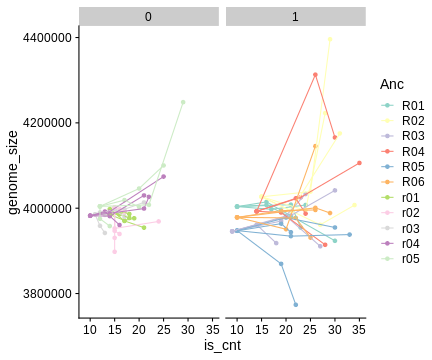

RObject{VecSxp}


In [13]:
R"""
genome_stats_df %>%
ggplot(aes(x = is_cnt, y = genome_size, color = Anc)) +
geom_point() +
geom_line(aes(group = Prefix))+
facet_wrap(~RecA)+
scale_color_brewer(palette = "Set3")+
theme_half_open()
"""

In [14]:
R"""
genome_stats_df %>% group_by(RecA) %>% summarise(min(genome_size), max(genome_size), mean(genome_size), median(genome_size))
"""

RObject{VecSxp}
# A tibble: 2 × 5
   RecA `min(genome_size)` `max(genome_size)` `mean(genome_size)`
  <int>              <int>              <int>               <dbl>
1     0            3897922            4248613            3992755.
2     1            3773677            4396104            3999046.
# ℹ 1 more variable: `median(genome_size)` <dbl>


In [15]:
R"""
LTEE.df.group.mean <- LTEE.df %>%
mutate(genome_size = called_bp + inserted_bp - deleted_bp) %>%
mutate(genome_size.unmasked = total_bp + inserted_bp - deleted_bp) %>%
group_by(time, population) %>%
mutate(mobile_element_mediated = rowSums(across(starts_with("mobile_element.mediated.")))) %>%
summarise(genome_size = mean(genome_size), genome_size.unmasked = mean(genome_size.unmasked),
	is_ins = mean(mobile_element_insertion), is_event = mean(is_ins + mobile_element_mediated)) 

genome.size.LTEE.Kanai <- LTEE.df.group.mean %>%
mutate(Group = "LTEE") %>%
mutate(genome_size = genome_size.unmasked) %>% # use total bp for genome size
select(time, population, genome_size, Group) %>% 
mutate(genome_size_change = genome_size / 4629812) # total _bp from https://github.com/barricklab/LTEE-Ecoli/blob/master/summary/count.LTEE.masked.csv

genome.size.LTEE.Kanai <- genome.size.LTEE.Kanai %>%
rbind(
genome_stats_df %>% 
#mutate(genome_size = genome_size - is_length) %>% 
mutate(genome_size = genome_size) %>% 
group_by(Prefix) %>%
mutate(original_genome_size = first(genome_size)) %>%
ungroup() %>%
mutate(time = map_int(gen_id, ~ MA_generations[.x])) %>%
mutate(Group = "This Study") %>%
mutate(genome_size_change = genome_size/original_genome_size) %>%
select(time,
	population = Prefix,
	genome_size,
	Group,
	genome_size_change
)
)
"""

┌ Warning: RCall.jl: `summarise()` has grouped output by 'time'. You can override using the
│ `.groups` argument.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 277 × 5
# Groups:   time [27]
    time population genome_size Group genome_size_change
   <dbl> <chr>            <dbl> <chr>              <dbl>
 1   500 Ara+1         4624978. LTEE               0.999
 2   500 Ara+2         4629812  LTEE               1    
 3   500 Ara+3         4630535  LTEE               1.00 
 4   500 Ara+4         4696076. LTEE               1.01 
 5   500 Ara+5         4630535  LTEE               1.00 
 6   500 Ara+6         4629200. LTEE               1.00 
 7   500 Ara-1         4627712. LTEE               1.00 
 8   500 Ara-2         4626104. LTEE               0.999
 9   500 Ara-3         4626818. LTEE               0.999
10   500 Ara-4         4629812  LTEE               1    
# ℹ 267 more rows


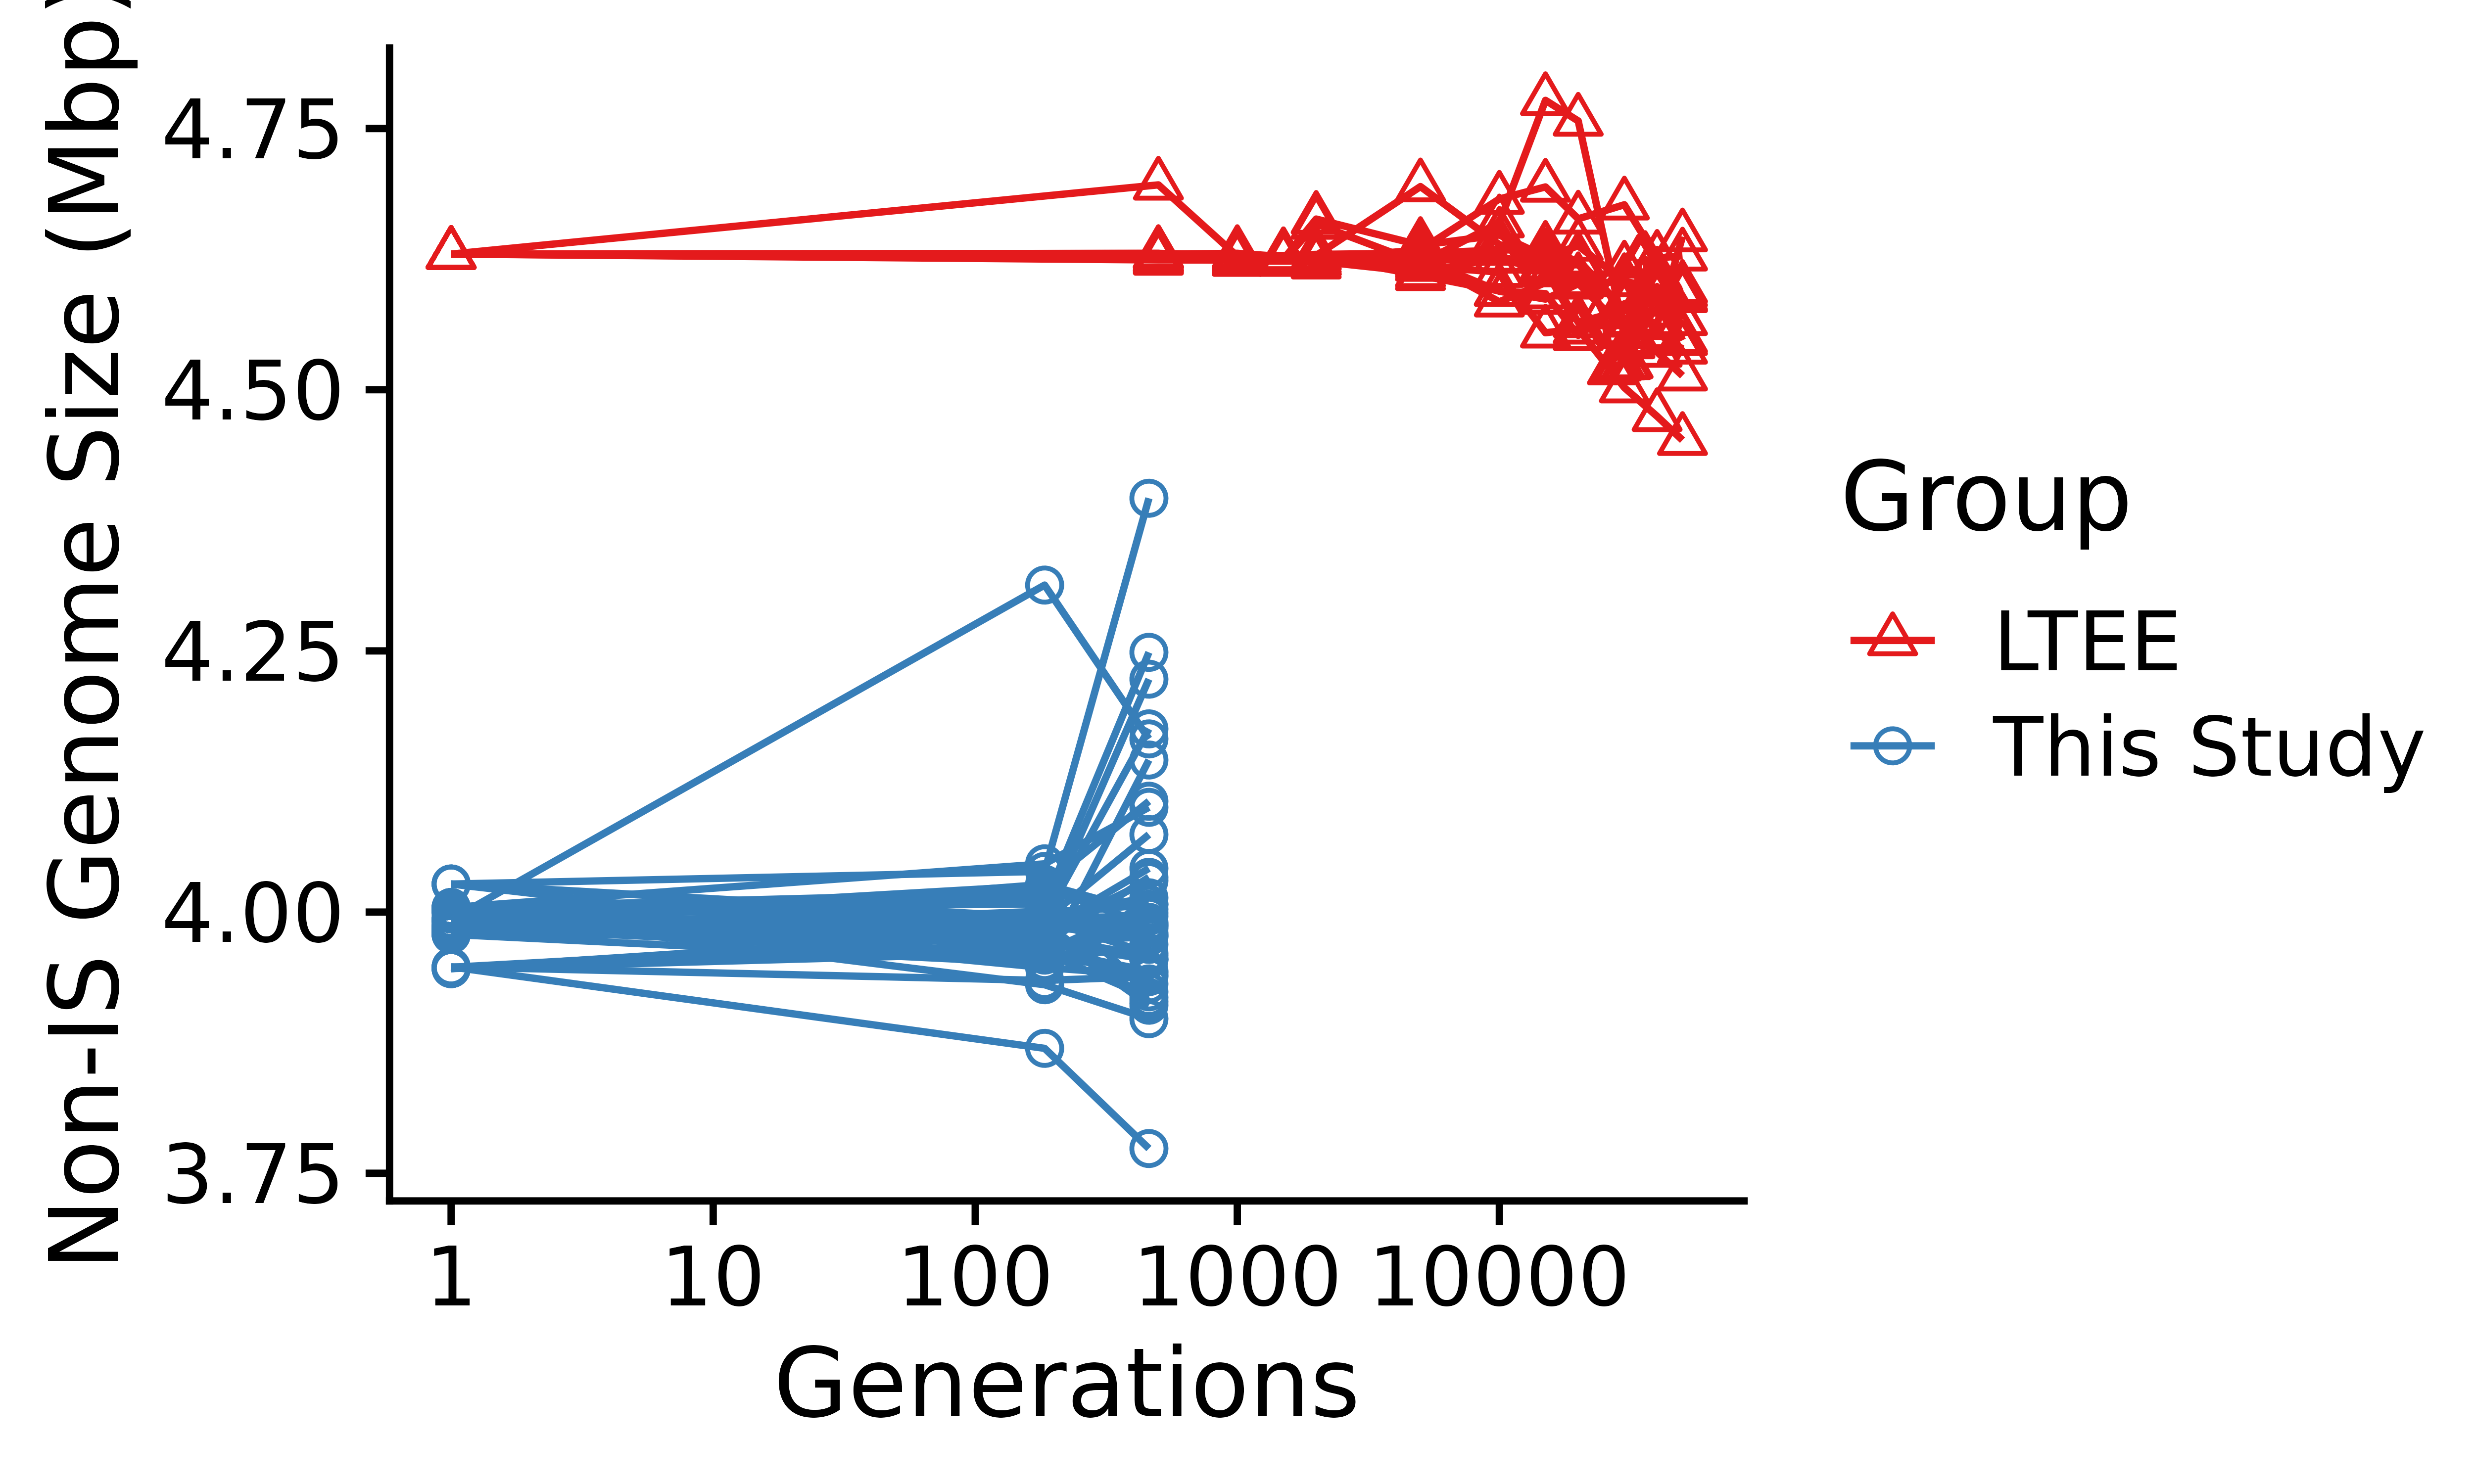

In [16]:
figure_name = file_prefix * "generations_genome_size"
@rput figure_name
R"""
p <- genome.size.LTEE.Kanai %>%
rbind(data.frame(time = 1,
population = LTEE.df %>% pull(population) %>% unique,
#genome_size = 4465410, # from called
genome_size = 4629812, # from totalb
Group = "LTEE", genome_size_change = 1)
) %>%
ggplot(aes(x = time, y = genome_size/1e6, color = Group, shape = Group, group = population)) +
geom_line()+
geom_point(size=2) +
scale_shape_manual(values = c(2,1)) +
scale_color_brewer(palette = "Set1") +
labs(x = "Generations", y = "Non-IS Genome Size (Mbp)") +
scale_x_log10() +
theme_half_open()
ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=5.0, height=3.0, units="in", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=5.0, height=3.0, units="in", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

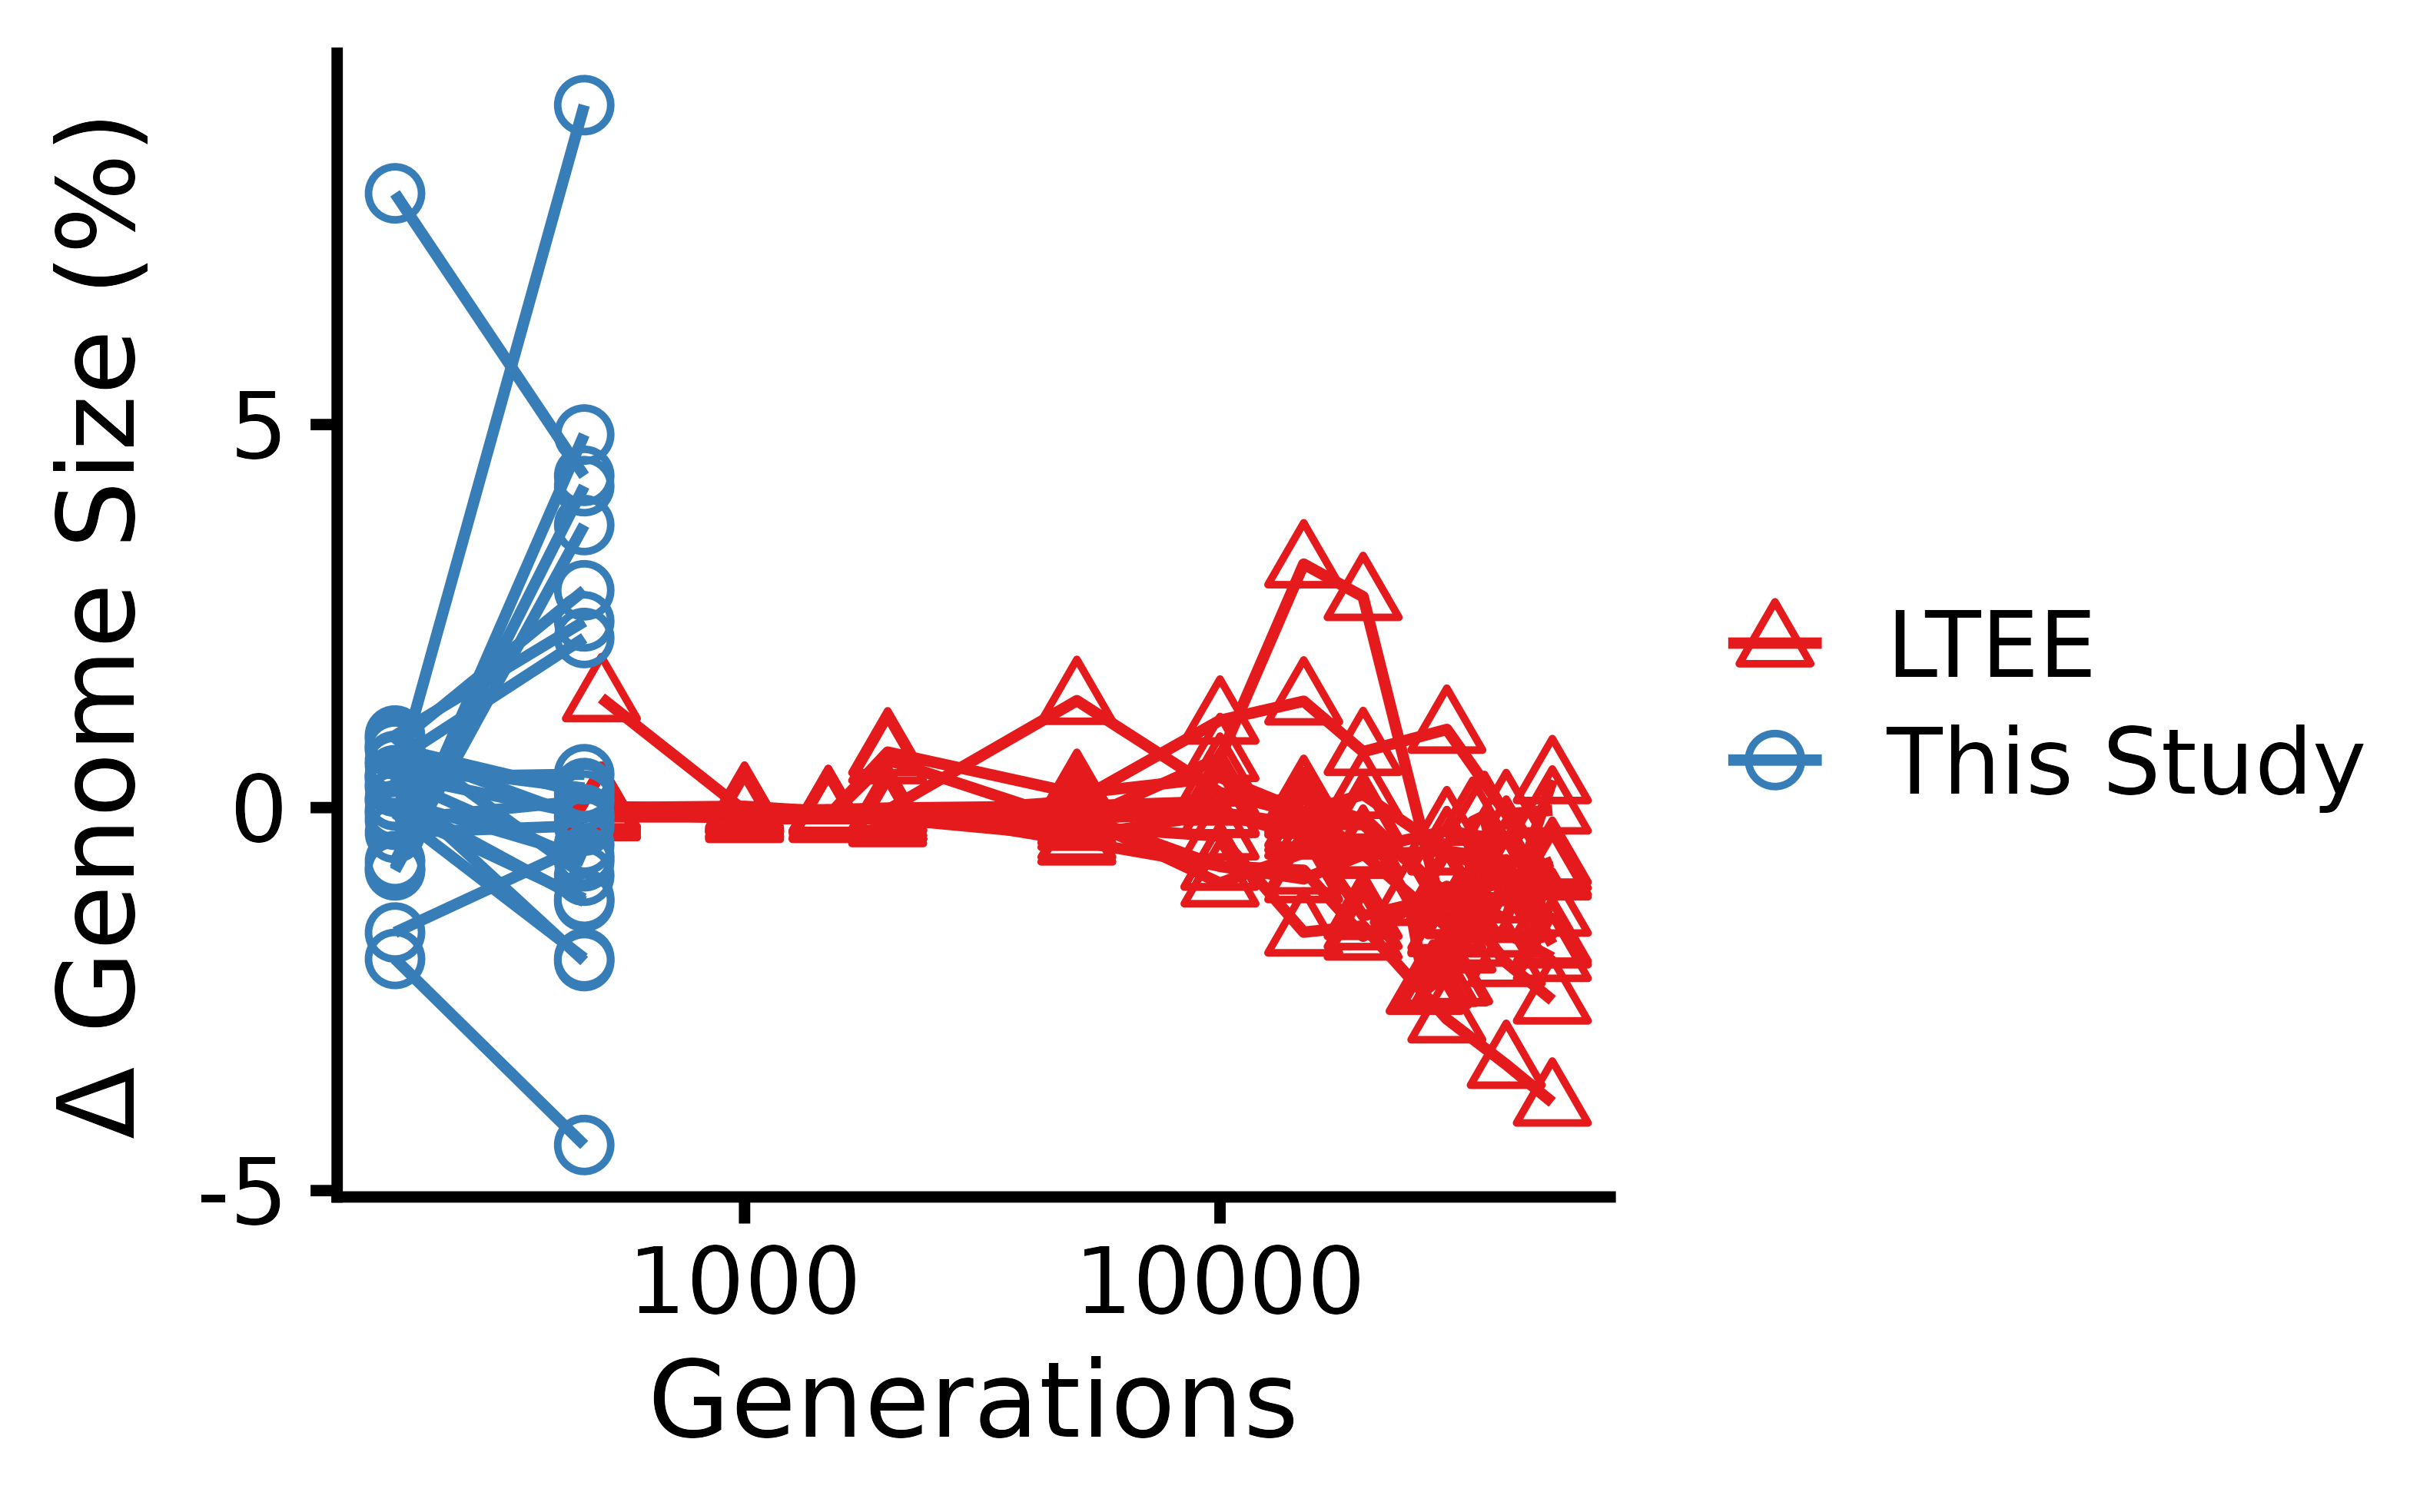

In [17]:
figure_name = file_prefix * "generations_genome_size_ratio_recAP"
@rput figure_name
R"""
p <- genome.size.LTEE.Kanai %>%
filter(time > 100) %>%
mutate(Source = Group) %>%
mutate(Source = ifelse(Source == "This Study", ifelse(as.numeric(str_sub(population, start=2, end = 3))<=6, "RecA", "recA"), Source)) %>%
filter(Source != "recA") %>%
mutate(Source = ifelse(Source == "RecA","This Study", Source)) %>%
ggplot(aes(x = time, y = (genome_size_change-1)*100, color = Source, shape = Source, group = population)) +
geom_line()+
geom_point(size=2) +
scale_shape_manual(values = c(2,1), name ="") +
scale_color_brewer(palette = "Set1", name = "") +
#scale_x_log10(labels =  function(x) format(x, scientific = TRUE)) +
scale_x_log10(breaks = c(1e3, 1e4)) +
labs(x = "Generations", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10)

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

### FIG: LTEE vs Kanai Genome size

┌ Warning: RCall.jl: Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

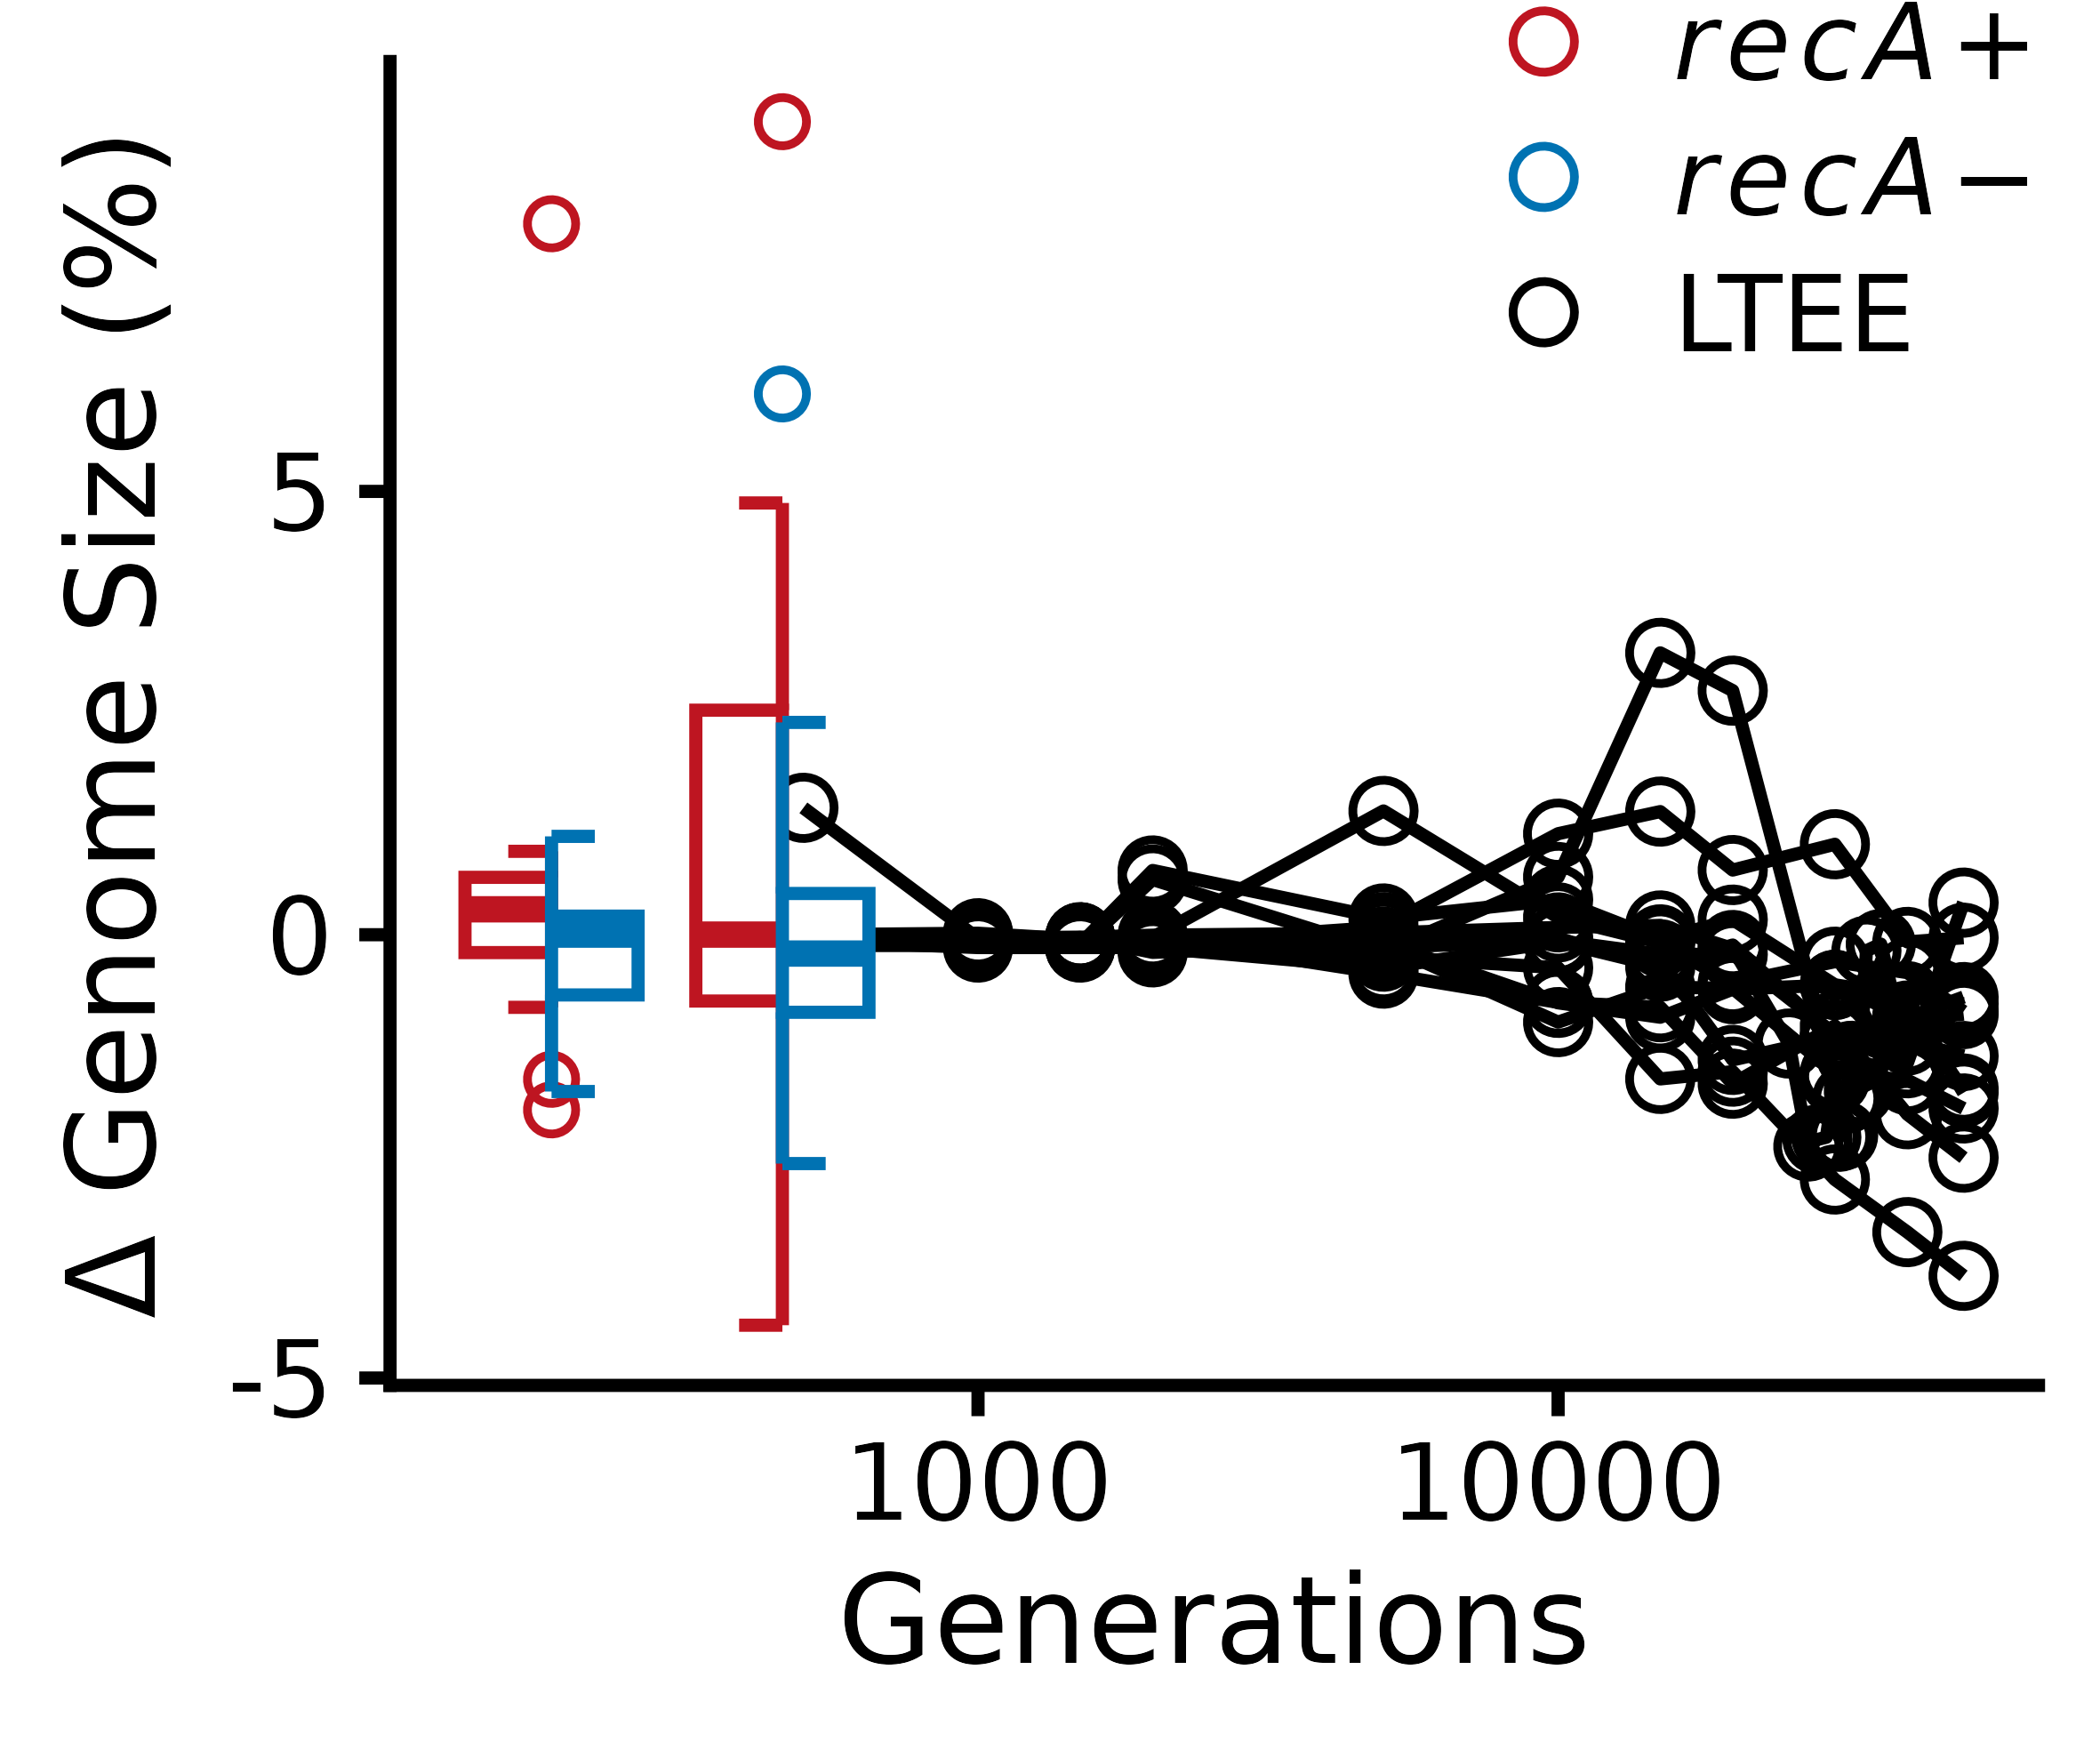

In [18]:
#fig:is_exp_ins_pos
figure_name = file_prefix * "generations_genome_size_ratio3"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic(recA), "+"), paste(italic(recA), "-")))
tmp.df_ <- genome.size.LTEE.Kanai %>%
filter(time > 100) %>%
mutate(Source = Group) %>%
mutate(Source = ifelse(Source == "This Study", ifelse(as.numeric(str_sub(population, start=2, end = 3))<=6, "RecA", "recA"), Source))

p<- tmp.df_ %>% filter(Source == "LTEE") %>%
ggplot(aes(x = time, y = (genome_size_change-1)*100, color = Source, group = population)) +
geom_line(color = "black")+
geom_point(size=2, shape = 1) +
#geom_half_violin(data = tmp.df_ %>% filter(Source != "LTEE"),
#	aes(fill = Source, split = Source, group = paste(time, Source)),
#	position = "identity", color = "NA", trim = FALSE, scale = "count", width = .8) +
geom_half_boxplot(data = tmp.df_ %>% filter(Source == "RecA"),
	aes(color = Source, group = paste(time, Source)), show.legend = F, outlier.shape = 1) +
geom_half_boxplot(data = tmp.df_ %>% filter(Source == "recA"),
	aes(color = Source, group = paste(time, Source)), side = "r", show.legend=F, outlier.shape = 1) +
scale_color_manual(
	#values = c("black", "#be1521", "#0072b2"),
	values = c("RecA" = "#be1521", "recA" = "#0072b2", "LTEE" = "black"),
	breaks = c("RecA", "recA", "LTEE"),
	name = "",
	labels = c(expression(paste(italic(recA), "+")), expression(paste(italic(recA), "\u2212")),
		"LTEE")) +
scale_x_log10(breaks = c(1000, 10000)) + 
labs(x = "Generations", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
guides(color = guide_legend(override.aes = list(shape = 1))) +
theme(legend.text = element_text(hjust = 0),
	legend.justification = c(1,1), legend.position = c(1,1.2))
#legend.position = c(0.6, 0.9))

p.genome.size.LTEE.Kanai <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=60, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=60, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=60, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

In [19]:
R"""
genome_stats_df %>% colnames %>% print
genome_stats_df %>% head %>% print
""";

 [1] "IS_Detect_ID"             "ParentLine"              
 [3] "SubLine"                  "gen"                     
 [5] "file_name"                "Anc"                     
 [7] "RecA"                     "Prefix"                  
 [9] "sample_name_raw"          "Contig_Date"             
[11] "Complete"                 "gen_id"                  
[13] "File"                     "genome_size"             
[15] "is_cnt"                   "is_length"               
[17] "ins_pos_cnt_raw"          "ins_pos_cnt"             
[19] "new_cnt"                  "lost_end_cnt"            
[21] "simple_insertion_cnt"     "ins_pos_cnt_raw_anc"     
[23] "ins_pos_cnt_anc"          "new_cnt_anc"             
[25] "lost_end_cnt_anc"         "simple_insertion_cnt_anc"
[27] "ins_pos_cnt_raw_mds"      "ins_pos_cnt_mds"         
[29] "new_cnt_mds"              "lost_end_cnt_mds"        
[31] "simple_insertion_cnt_mds"
  IS_Detect_ID ParentLine SubLine  gen                 file_name Anc RecA
1      L0

In [20]:
R"""
genome.size.LTEE.Kanai %>% head %>% print
genome.size.LTEE.Kanai %>%
	select(Generations=time, population, Group, genome_size, genome_size_change) %>%
	mutate(RecA = ifelse(Group!="LTEE", ifelse(as.integer(str_sub(population, start=2, end = 3))<=6, TRUE, FALSE), NA)) %>%
	write_csv(file.path(data_export_dir, paste0(file_prefix, "genome_size_change.csv")), col_names = TRUE)
"""


# A tibble: 6 × 5
# Groups:   time [1]
   time population genome_size Group genome_size_change
  <dbl> <chr>            <dbl> <chr>              <dbl>
1   500 Ara+1         4624978. LTEE               0.999
2   500 Ara+2         4629812  LTEE               1    
3   500 Ara+3         4630535  LTEE               1.00 
4   500 Ara+4         4696076. LTEE               1.01 
5   500 Ara+5         4630535  LTEE               1.00 
6   500 Ara+6         4629200. LTEE               1.00 


RObject{VecSxp}
# A tibble: 277 × 6
# Groups:   Generations [27]
   Generations population Group genome_size genome_size_change RecA 
         <dbl> <chr>      <chr>       <dbl>              <dbl> <lgl>
 1         500 Ara+1      LTEE     4624978.              0.999 NA   
 2         500 Ara+2      LTEE     4629812               1     NA   
 3         500 Ara+3      LTEE     4630535               1.00  NA   
 4         500 Ara+4      LTEE     4696076.              1.01  NA   
 5         500 Ara+5      LTEE     4630535               1.00  NA   
 6         500 Ara+6      LTEE     4629200.              1.00  NA   
 7         500 Ara-1      LTEE     4627712.              1.00  NA   
 8         500 Ara-2      LTEE     4626104.              0.999 NA   
 9         500 Ara-3      LTEE     4626818.              0.999 NA   
10         500 Ara-4      LTEE     4629812               1     NA   
# ℹ 267 more rows


In [21]:
R"""
Kanai.ins.cnt <- read_csv(file.path(data_export_dir, paste0(file_prefix, "is_count_insertion_site_cnt.csv")),comment = '#') %>% head %>% print
#genome.size.LTEE.Kanai %>% left_join(Kanai.ins.cnt, by = c("time" 
"""

# A tibble: 6 × 5
  Line    Gen `IS count` `New Insertion Sites` recA 
  <chr> <dbl>      <dbl>                 <dbl> <chr>
1 L01-1     1         10                    NA recA+
2 L01-1     2         16                     9 recA+
3 L01-1     3         30                    31 recA+
4 L01-2     1         10                    NA recA+
5 L01-2     2         16                    10 recA+
6 L01-2     3         21                    21 recA+


┌ Warning: RCall.jl: Rows: 132 Columns: 5
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr (2): Line, recA
│ dbl (3): Gen, IS count, New Insertion Sites
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 6 × 5
  Line    Gen `IS count` `New Insertion Sites` recA 
  <chr> <dbl>      <dbl>                 <dbl> <chr>
1 L01-1     1         10                    NA recA+
2 L01-1     2         16                     9 recA+
3 L01-1     3         30                    31 recA+
4 L01-2     1         10                    NA recA+
5 L01-2     2         16                    10 recA+
6 L01-2     3         21                    21 recA+


### DAT: Genome Size Change

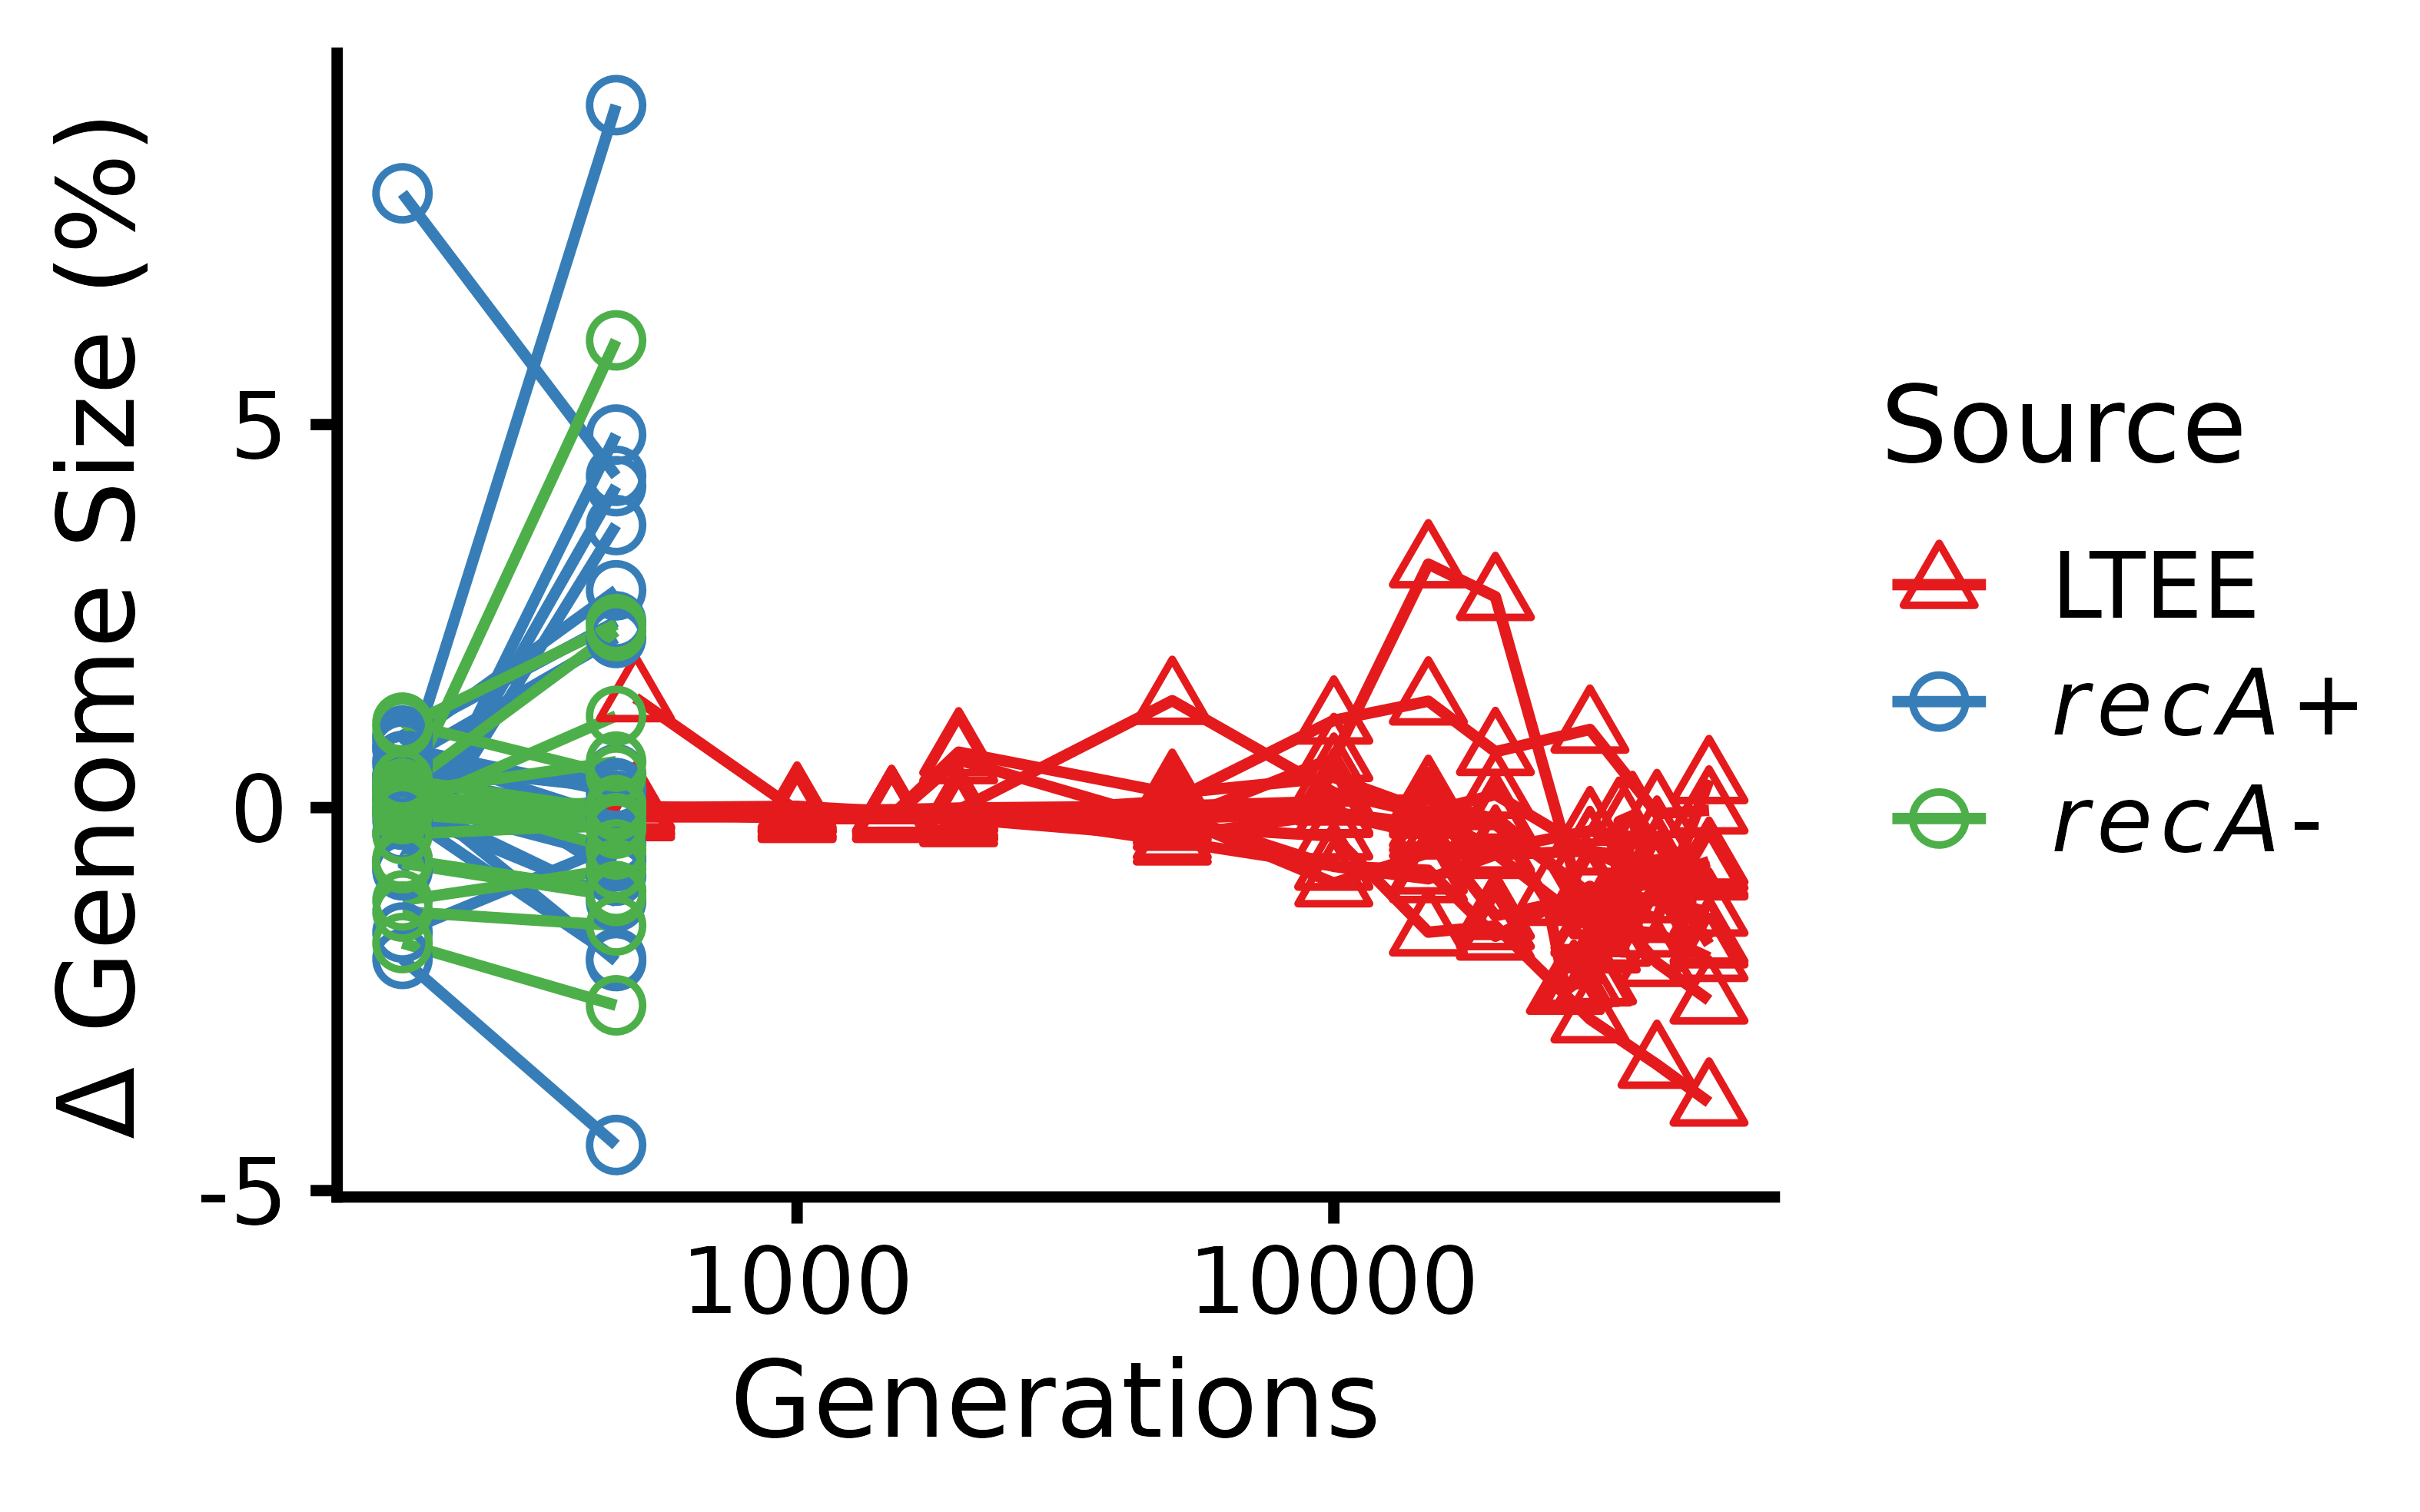

In [22]:
# old version of the figure with scatter instead of boxplot
figure_name = file_prefix * "generations_genome_size_ratio2"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic(recA), "+"), paste(italic(recA), "-")))
p <- genome.size.LTEE.Kanai %>%
filter(time > 100) %>%
mutate(Source = Group) %>%
mutate(Source = ifelse(Source == "This Study", ifelse(as.numeric(str_sub(population, start=2, end = 3))<=6, "RecA", "recA"), Source)) %>%
ggplot(aes(x = time, y = (genome_size_change-1)*100, color = Source, shape = Source, group = population)) +
geom_line()+
geom_point(size=2) +
scale_shape_manual(values = c(2,1, 1), labels = labs_) +
scale_color_brewer(palette = "Set1", labels = labs_) +
scale_x_log10(breaks = c(1000, 10000)) + 
labs(x = "Generations", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text = element_text(hjust = 0))

#p.genome.size.LTEE.Kanai <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

### STATS: genome size change

In [89]:
R"""
genome.size.LTEE.Kanai %>%
filter(time > 100) %>%
mutate(Source = Group) %>%
filter((Source == "This Study" & time > 300) | (Source == "LTEE" & time == 50000)) %>%
mutate(Source = ifelse(Source == "This Study", ifelse(as.numeric(str_sub(population, start=2, end = 3))<=6, "RecA", "recA"), Source)) %>%
group_by(Source) %>%
mutate(genome_size_change = genome_size_change - 1) %>%
summarise(median = median(genome_size_change), mean = mean(genome_size_change), sd = sd(genome_size_change),
        max = max(genome_size_change), min = min(genome_size_change),
        n = n()) %>%
data.frame
"""

RObject{VecSxp}
  Source        median         mean         sd         max         min  n
1   LTEE -1.131628e-02 -0.013435850 0.01134033 0.003620449 -0.03847197 12
2   RecA  1.294396e-05  0.008644748 0.02883260 0.091699062 -0.04404314 24
3   recA -2.125116e-03  0.001613525 0.01829884 0.060994644 -0.02581200 20


In [82]:
R"""
genome.size.LTEE.Kanai %>%
filter((time >300 & Group == "This Study") | (time == 50000 & Group == "LTEE")) %>%
mutate(Source = Group) %>%
mutate(Source = ifelse(Source == "This Study", ifelse(as.numeric(str_sub(population, start=2, end = 3))<=6, "RecA", "recA"), Source)) %>%
group_by(Source) %>%
summarise(genome_size_change.mean = mean(genome_size_change)-1, genome_size_change.median = median(genome_size_change)-1,
bp.change.min = min((1-1/genome_size_change) * genome_size), bp.change.max = max((1-1/genome_size_change) * genome_size),
bp.change.median = median((1-1/genome_size_change) * genome_size)) %>% data.frame
"""

RObject{VecSxp}
  Source genome_size_change.mean genome_size_change.median bp.change.min
1   LTEE            -0.013435850             -1.131628e-02       -178118
2   RecA             0.008644748              1.294396e-05       -173862
3   recA             0.001613525             -2.125116e-03       -103279
  bp.change.max bp.change.median
1         16762        -52392.25
2        369258            77.00
3        244245         -8469.00


### Reconstruct genome size of LTEE
using Barrick's in del data of nonrepeat region and consuegra's IS number

In [25]:
# estimate genome size incorporating the IS counts
R"""
is.size.df <- data.frame(IS = c("IS1", "IS2", "IS3", "IS4", "IS30", "IS150", "IS186", "IS600", "IS911"),
is.size = c(768, 1331, 1258, 1426, 1152, 1113, 1443, 0, 0)) 

LTEE.IS.length <- data_processed %>% mutate(IS = gsub("a", "", IS)) %>%
left_join(is.size.df, by = "IS") %>%
mutate(is.size = is.size * (gain - loss)) %>%
group_by(Population, Clone) %>% 
summarise(is.length = sum(is.size), is.cnt = sum(number)) %>%
summarise(is.length = mean(is.length), is.cnt = mean(is.cnt))

LTEE.df.group.mean.merged <- LTEE.df.group.mean %>%
filter(time == 50000) %>% select(-time) %>%
mutate(population = str_replace(population, "-", "–")) %>%
left_join(LTEE.IS.length, by = c("population" = "Population"))

"""


┌ Warning: RCall.jl: `summarise()` has grouped output by 'Population'. You can override using the
│ `.groups` argument.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: Adding missing grouping variables: `time`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 12 × 8
# Groups:   time [1]
    time population genome_size genome_size.unmasked is_ins is_event is.length
   <dbl> <chr>            <dbl>                <dbl>  <dbl>    <dbl>     <dbl>
 1 50000 Ara+1         4382877              4547279    39.5     52      42887 
 2 50000 Ara+2         4425331              4589733    10       16.5    11415 
 3 50000 Ara+3         4374692              4539094     4.5      6.5     4294.
 4 50000 Ara+4         4482172              4646574     6       11       5608.
 5 50000 Ara+5         4463812.             4628214.   16       22.5    17763 
 6 50000 Ara+6         4402068.             4566470.    4        8.5     2986.
 7 50000 Ara–1         4432858              4597260    11       14      12213 
 8 50000 Ara–2         4348983              4513385    14       19      13762.
 9 50000 Ara–3         4385080.             4549482.   33       45      26828 
10 50000 Ara–4         4287292              4451694     2.5      8.5    -24

In [26]:
R"""
genome_size_df <- genome_stats_df %>% 
filter(gen_id ==2) %>%
select(Prefix, genome_size, is_cnt) %>%
mutate(Group = "This Study") %>%
rbind(hawkey2020pgen %>% 
select(Prefix = genome, genome_size = chromosome_size_bp, is_cnt = total_is_count) %>%
mutate(Group = "Pathogenic E. coli")
) %>% 
rbind(data.frame(Prefix = "MG1655", genome_size = 4641652, is_cnt = 41, Group = "E. coli WT")) %>%
rbind(data.frame(Prefix = "REL606", genome_size = 4629812, is_cnt =
data_processed %>% filter(Clone == "REL606") %>% summarise(is_cnt = sum(number)) %>% pull(is_cnt),
Group = "E. coli WT")) %>%
rbind(data.frame(Prefix = "MDS42", genome_size = 3976195, is_cnt = 0, Group = "MDS42")) 

genome_size_df <- genome_size_df %>% rbind(manzano.marin.df %>%
select(Prefix, genome_size, is_cnt = IS, Group))

head(genome_size_df)
"""

RObject{VecSxp}
  Prefix genome_size is_cnt      Group
1  L01-1     4014776     16 This Study
2  L01-2     4007666     16 This Study
3  L01-3     4008366     21 This Study
4  L01-4     3997478     17 This Study
5  L02-1     3993861     21 This Study
6  L02-2     4038944     25 This Study


## Figure: IS number x Genome size

┌ Warning: RCall.jl: Adding missing grouping variables: `time`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


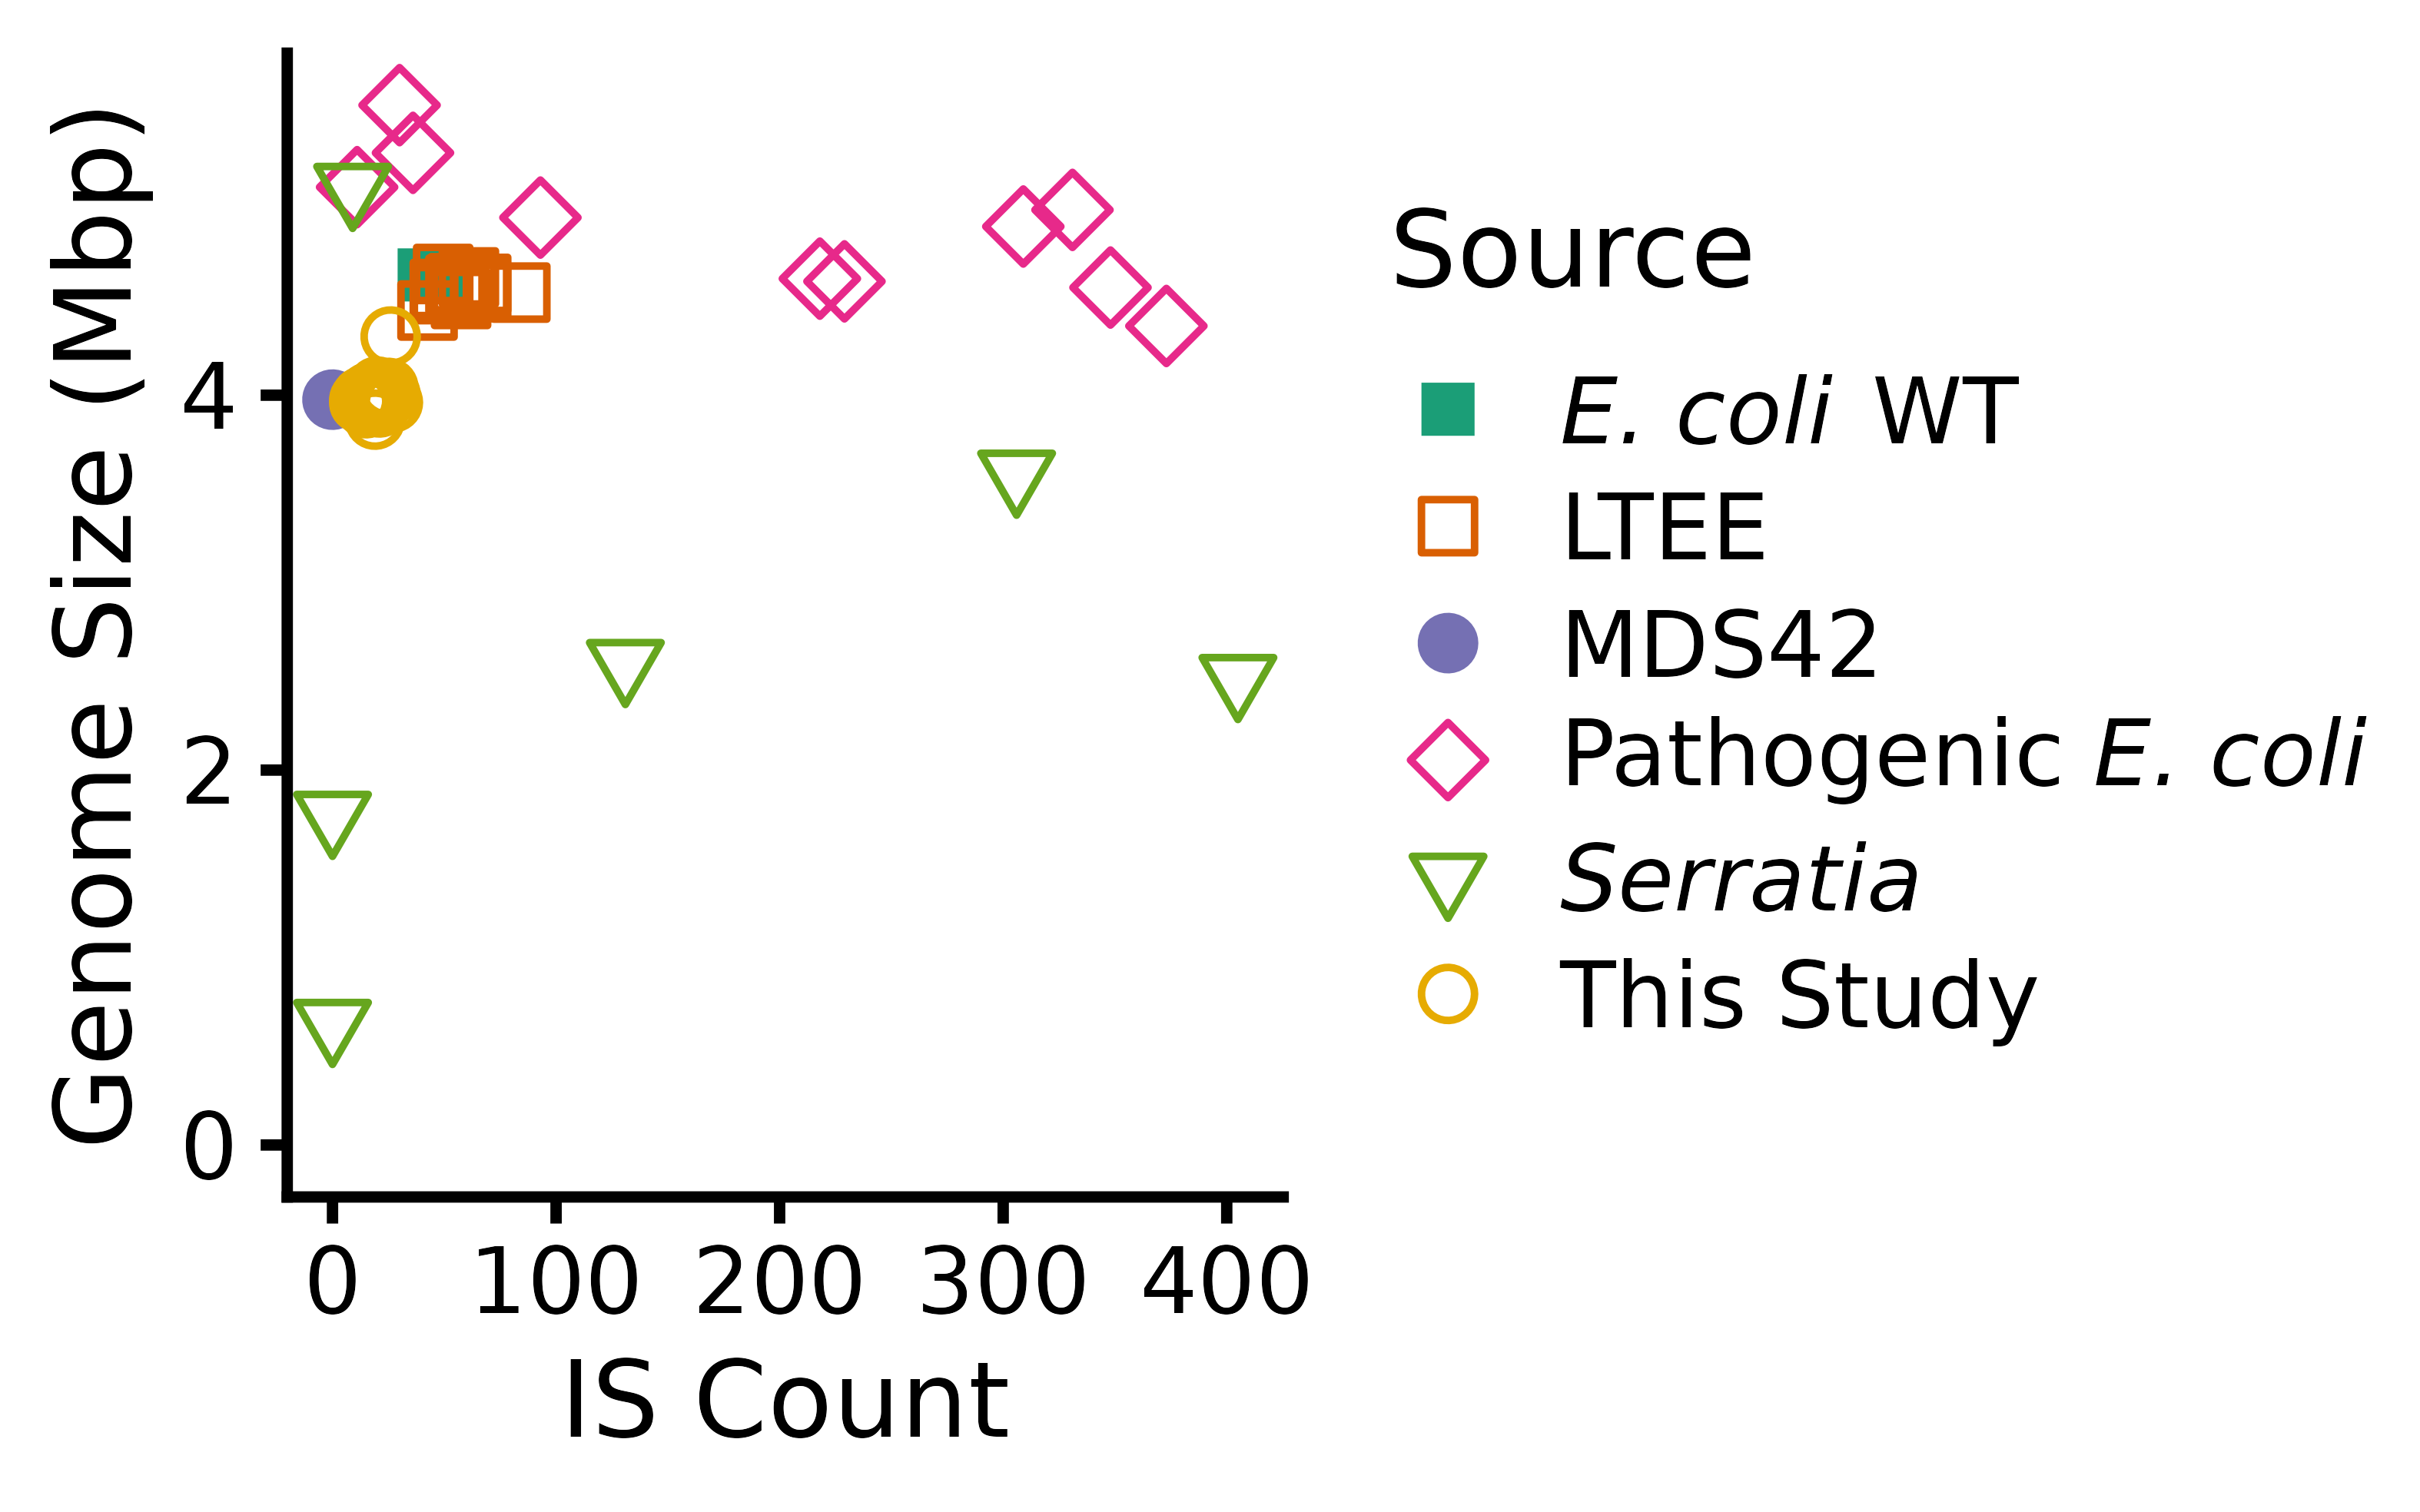

In [27]:
figure_name = file_prefix * "IS-cnt_Genome-size"
@rput figure_name
R"""
labs_ <- c(expression(paste(italic("E. coli"), " WT")),
		"LTEE", "MDS42", expression(paste("Pathogenic ", italic("E. coli"))),
		expression(italic("Serratia")), "This Study")
p <- LTEE.df.group.mean.merged %>%
#mutate(genome_size = genome_size.unmasked + is.length) %>%
mutate(genome_size = genome_size.unmasked) %>%
mutate(Group = "LTEE", Prefix = population) %>%
select(Prefix, genome_size, is_cnt = is.cnt, Group) %>%
rbind(genome_size_df) %>%
arrange((Group)) %>%
ggplot(aes(x = is_cnt, y = genome_size/1e6, color = Group, shape = Group)) +
geom_point(size = 2) +
scale_color_brewer(palette = "Dark2", labels = labs_, name = "Source") +
scale_shape_manual(values = c(15,0,19,5,6,1), labels = labs_, name = "Source") +
theme_half_open(10) +
ylim(0, NA) +
xlim(0, NA) +
labs(x = "IS Count", y = "Genome Size (Mbp)")  +
theme(legend.text = element_text(hjust = 0))

p.is_cnt_genome_size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))


┌ Warning: RCall.jl: Adding missing grouping variables: `time`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: Warning: Removed 11 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: Warning: Removed 11 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: Warning: Removed 11 rows containing missing values (`geom_point()`).
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


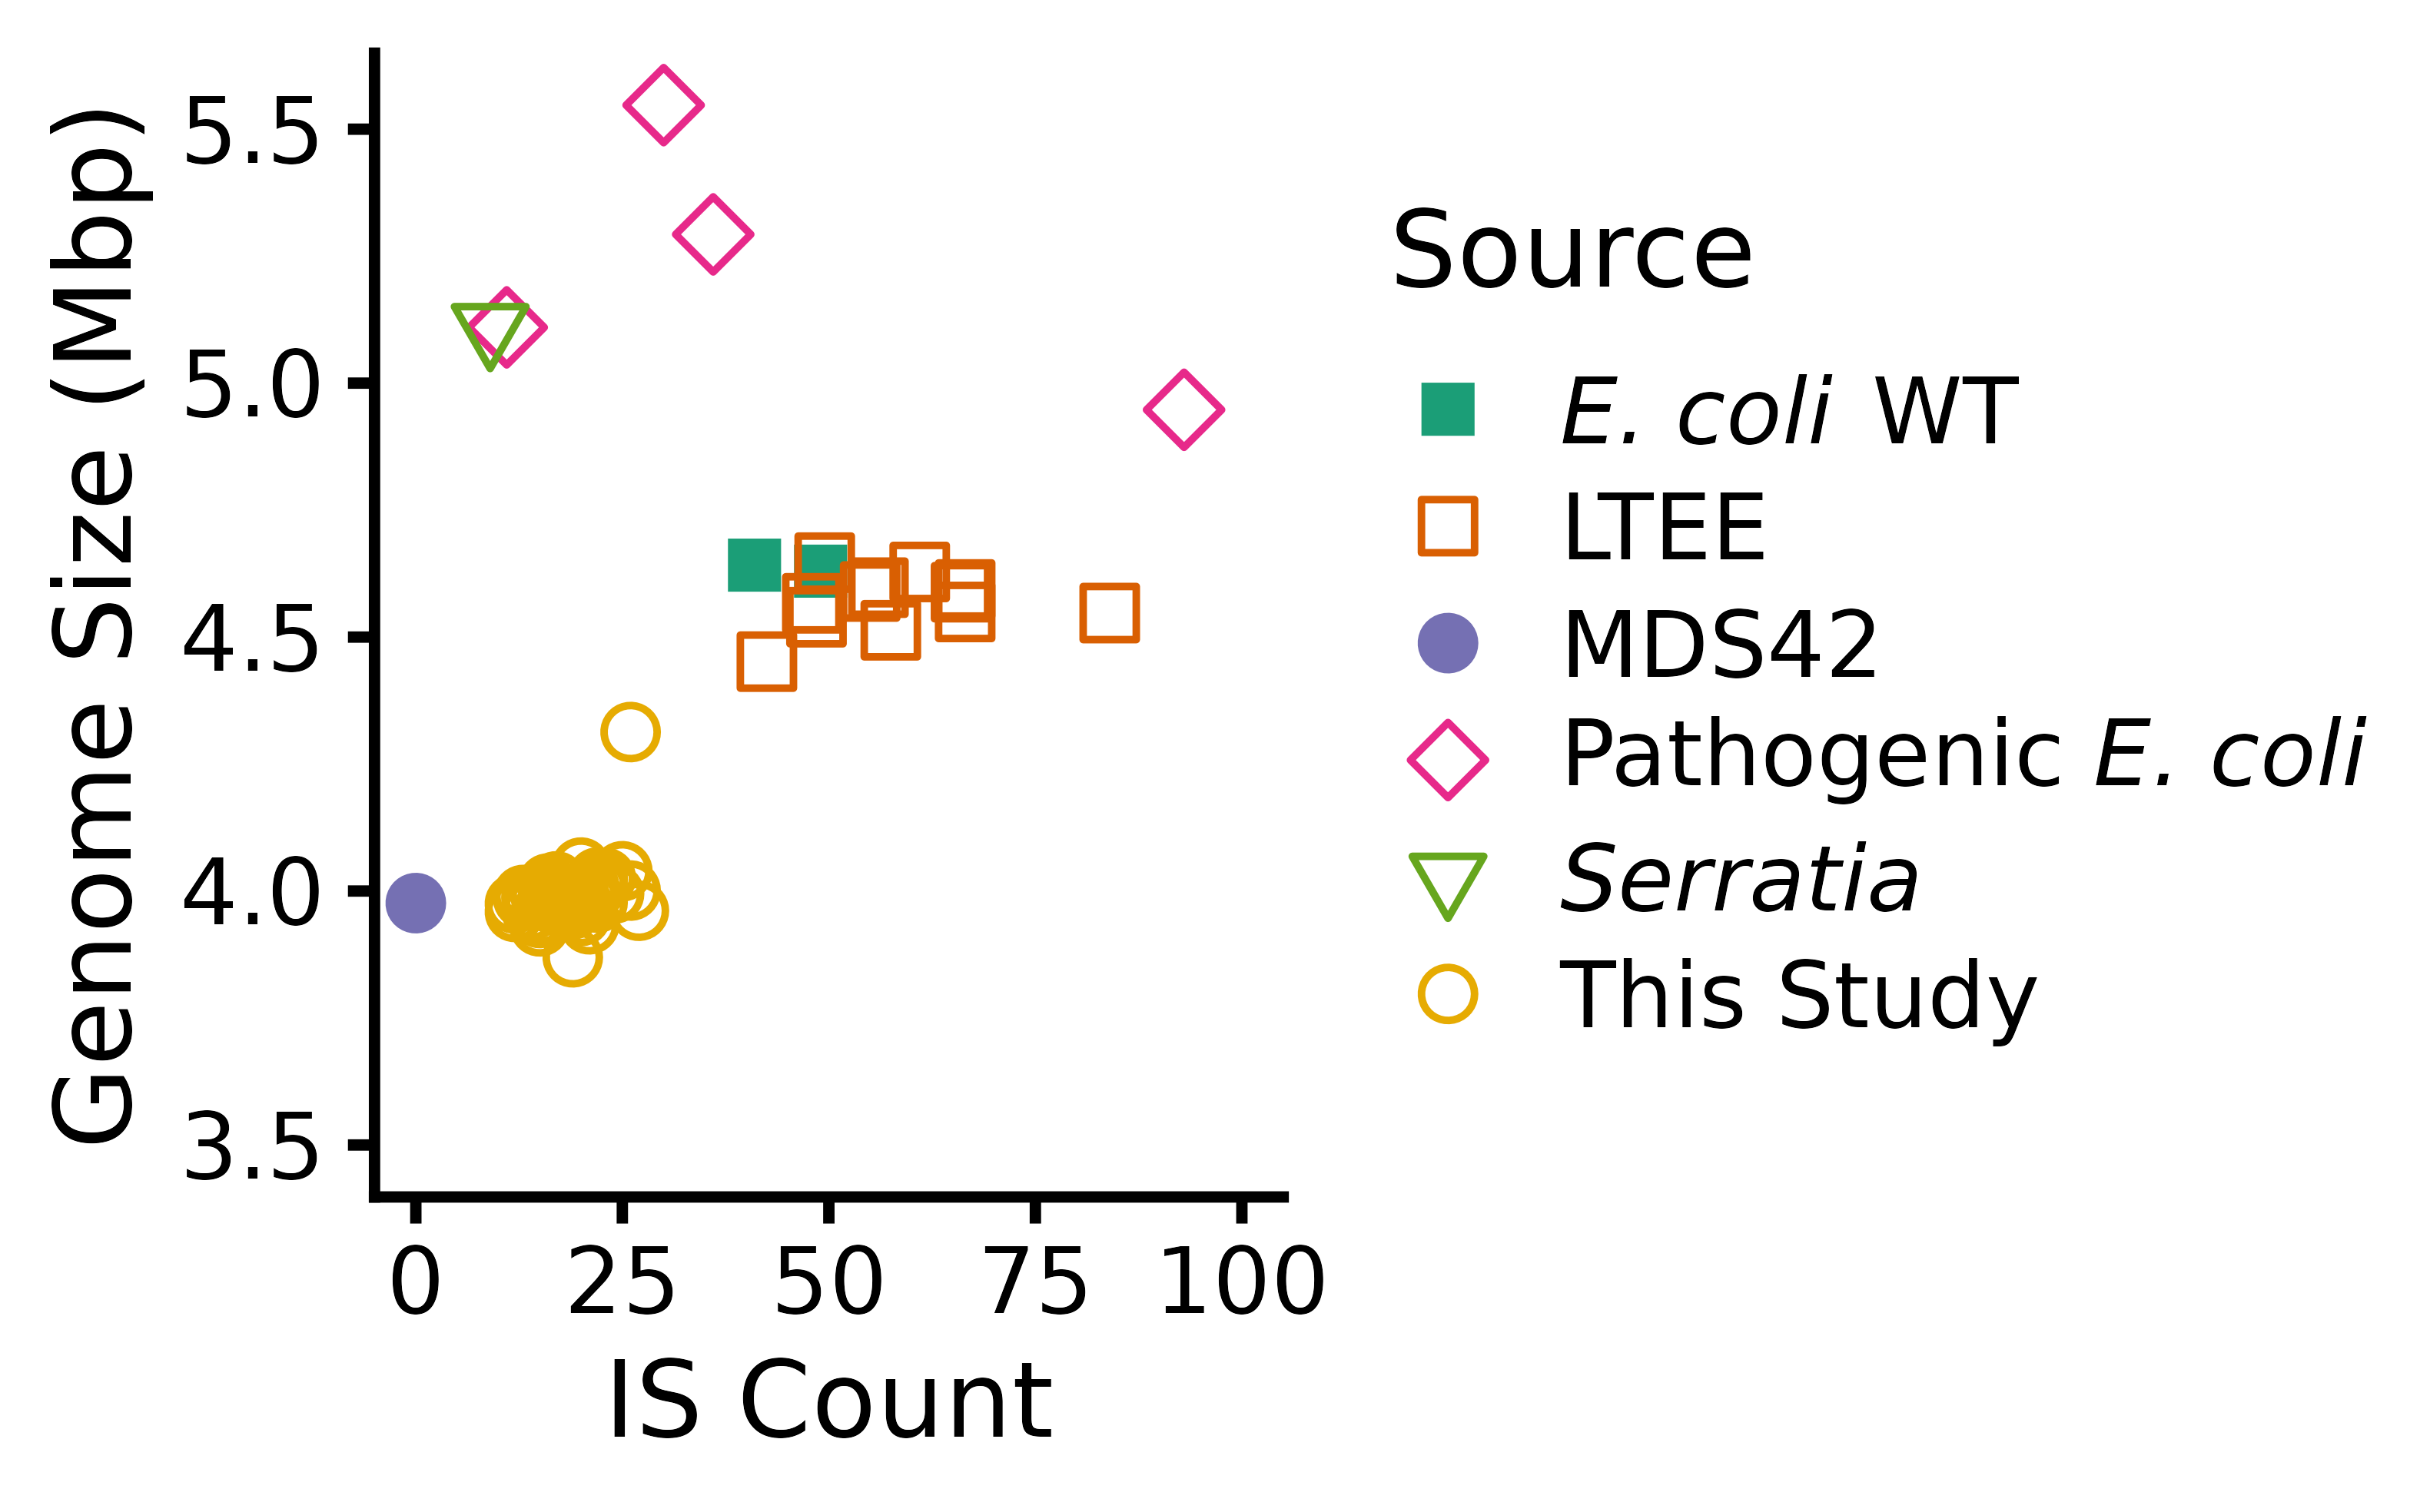

In [28]:
figure_name = file_prefix * "IS-cnt_Genome-size_closeup"
@rput figure_name
R"""
p<- LTEE.df.group.mean.merged %>%
#mutate(genome_size = genome_size.unmasked + is.length) %>%
mutate(genome_size = genome_size.unmasked) %>%
mutate(Group = "LTEE", Prefix = population) %>%
select(Prefix, genome_size, is_cnt = is.cnt, Group) %>%
rbind(genome_size_df) %>%
arrange((Group)) %>%
ggplot(aes(x = is_cnt, y = genome_size/1e6, color = Group, shape = Group)) +
geom_point(size = 2) +
scale_color_brewer(palette = "Dark2", labels = labs_, name = "Source") +
scale_shape_manual(values = c(15,0,19,5,6,1), labels = labs_, name = "Source") +
theme_half_open(10) +
ylim(3.5, NA) +
xlim(0, 100) +
labs(x = "IS Count", y = "Genome Size (Mbp)") +
theme(legend.text = element_text(hjust = 0))

p.is_cnt_genome_size.close <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

# Genome size compositions

groups: recA +- x gens(FACS, G08, G20)
deletion, IS, duplication

In [29]:
min_del_threshold = 100
@rput min_del_threshold
R"""
depth_interval_df <- read_csv(file.path(base_dir, "export/classify_IS_events_Anc/depth_interval.asm20.csv"))

generations2 <- c("MDS42_IS1", "FACS", "G08", "G20")

depth_interval_df <- depth_interval_df %>% 
#filter(length >= min_del_threshold) %>%
mutate(gen_id = as.integer(gen_id)) %>%
mutate(Gen = map_chr(gen_id, ~generations2[.x +1])) %>%
separate(line, c("Parent", "Subline"), sep = "-", remove = FALSE) %>%
mutate(Subline = as.integer(Subline))

genome_stats_df <- read_csv(file.path(base_dir, "export/classify_IS_events/genome_stats_merged.csv"))
genome_content_plot_dat <- genome_stats_df %>% right_join(
depth_interval_df %>% group_by(across(line:Gen)) %>%
mutate(Deletion = ifelse(depth==0, length,0), Duplication = ifelse(depth>1, length * (depth-1), 0)) %>%
mutate(Pristine = ifelse(depth>=1, length, 0)) %>%
summarise(Deletion = sum(Deletion), Duplication = sum(Duplication), Pristine = sum(Pristine)) %>%
mutate(Prefix = line),
by = c("Prefix", "gen_id")
)
0
"""

┌ Warning: RCall.jl: Rows: 1171 Columns: 11
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr  (1): line
│ dbl (10): group, start, end, depth, length, start_fix, end_fix, is_start, is...
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: Rows: 132 Columns: 31
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr  (8): IS_Detect_ID, gen, file_name, Anc, Prefix, sample_name_raw, Contig...
│ dbl (22): ParentLine, SubLine, RecA, gen_id, genome_size, is_cnt, is_length,...
│ lgl  (1): Complete
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172

RObject{RealSxp}
[1] 0


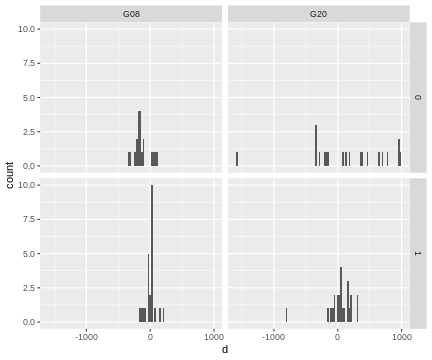

RObject{VecSxp}


In [30]:
R"""
genome_content_plot_dat %>% mutate(d = Pristine + Duplication + is_length - genome_size)  %>% 
ggplot(aes(x = d)) +
geom_histogram(bins = 100) +
facet_grid(RecA~Gen)
"""

In [31]:
R"""
genome_content_plot_dat %>% mutate(d = Pristine + Duplication + is_length - genome_size)  %>% 
pull(d) %>% summary %>% print
genome_content_plot_dat %>% mutate(d = Pristine + Duplication + is_length - genome_size)  %>% 
arrange(-abs(d)) %>% head(3) %>% data.frame %>% print
""";

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1576.00  -145.25    17.50    17.34    97.00   990.00 
  IS_Detect_ID ParentLine SubLine gen                file_name Anc RecA Prefix
1    L11-2_G20         11       2  20 20231003/L11-2_G20.fasta r05    0  L11-2
2    L07-3_G20          7       3  20 20231003/L07-3_G20.fasta r01    0  L07-3
3    L07-2_G20          7       2  20 20231003/L07-2_G20.fasta r01    0  L07-2
  sample_name_raw Contig_Date Complete gen_id                              File
1       L11-2_G20    20230909     TRUE      3 ../fasta/20231003/L11-2_G20.fasta
2       L07-3_G20    20230909     TRUE      3 ../fasta/20231003/L07-3_G20.fasta
3       L07-2_G20    20230909     TRUE      3 ../fasta/20231003/L07-2_G20.fasta
  genome_size is_cnt is_length ins_pos_cnt_raw ins_pos_cnt new_cnt lost_end_cnt
1     4100257     25     77313              45          25       6            0
2     3976386     19     58763              36          19       3            0
3     3977066 

In [32]:
R"""
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
head()
"""

RObject{VecSxp}
# A tibble: 6 × 6
  Prefix gen_id is_cnt  RecA length_type  length
  <chr>   <dbl>  <dbl> <dbl> <chr>         <dbl>
1 L01-1       2     16     1 is_length     58901
2 L01-1       2     16     1 Deletion       9155
3 L01-1       2     16     1 Duplication       0
4 L01-1       2     16     1 Pristine    3955910
5 L01-2       2     16     1 is_length     55756
6 L01-2       2     16     1 Deletion      29274


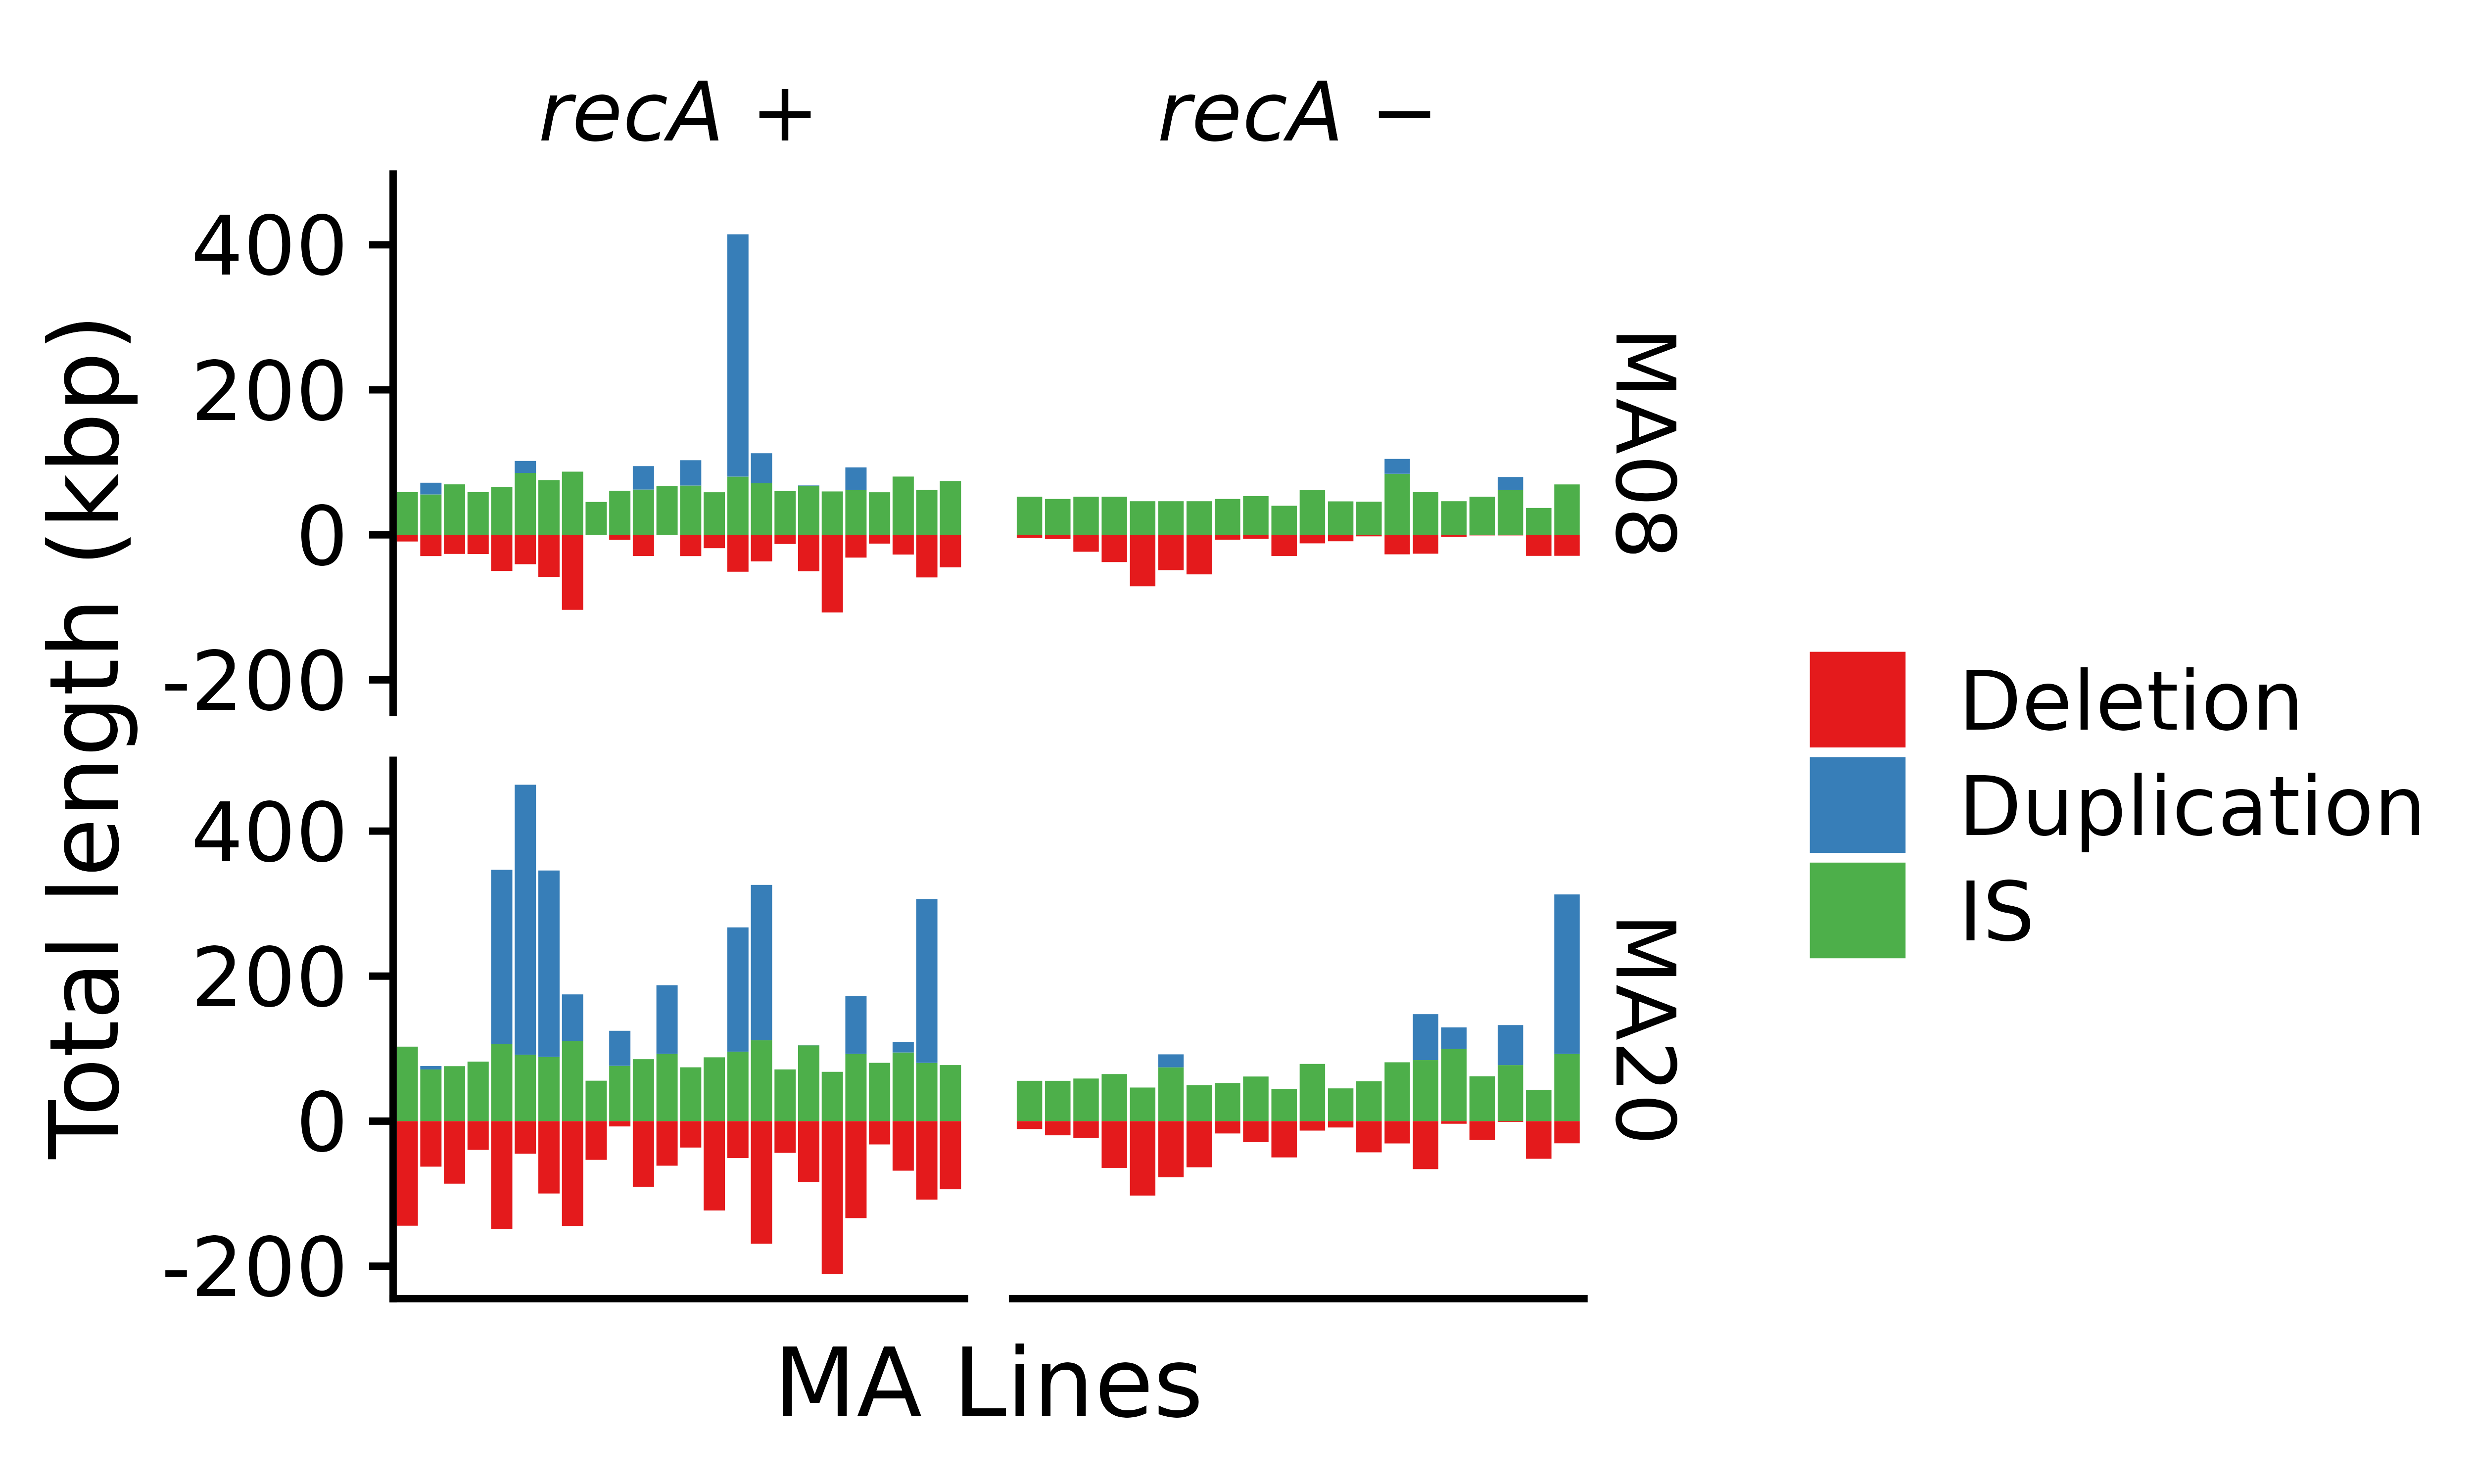

In [33]:
figure_name = file_prefix * "genome_size_content"
@rput figure_name
R"""
library(RColorBrewer)
colors_dark2 <- brewer.pal(7, "Dark2")

p <- genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
mutate(RecA = ifelse(RecA, "+", "\u2212")) %>%
#mutate(RecA = ifelse(RecA, expression(paste(italic("recA"), "+")), expression(paste(italic("recA"), "-")))) %>%
mutate(gen_id = ifelse(gen_id == 2, "MA08", "MA20")) %>%
mutate(Deletion = -Deletion) %>%
select(-Pristine) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>%
ggplot(aes(x = Prefix, y = length/1e3, fill = length_type)) +	
geom_bar(stat = "identity") +
#scale_fill_manual(values = c(colors_dark2[c(4,3,2)], c("grey90")), name = "") +
scale_y_continuous(breaks= ((-10):10)*200) +
scale_fill_brewer(palette = "Set1", name = "") +
facet_grid(gen_id~RecA, scales = "free_x", labeller = label_bquote(.(gen_id), italic("recA")~.(RecA))) +
theme_half_open() +
theme(axis.text.x = element_blank(), strip.background = element_blank(), axis.ticks.x = element_blank()) +
labs(x = "MA Lines", y = "Total length (kbp)")

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=5.0, height=3.0, units="in", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=5.0, height=3.0, units="in", dpi=1000, device = cairo_pdf)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=5.0, height=3.0, units="in", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

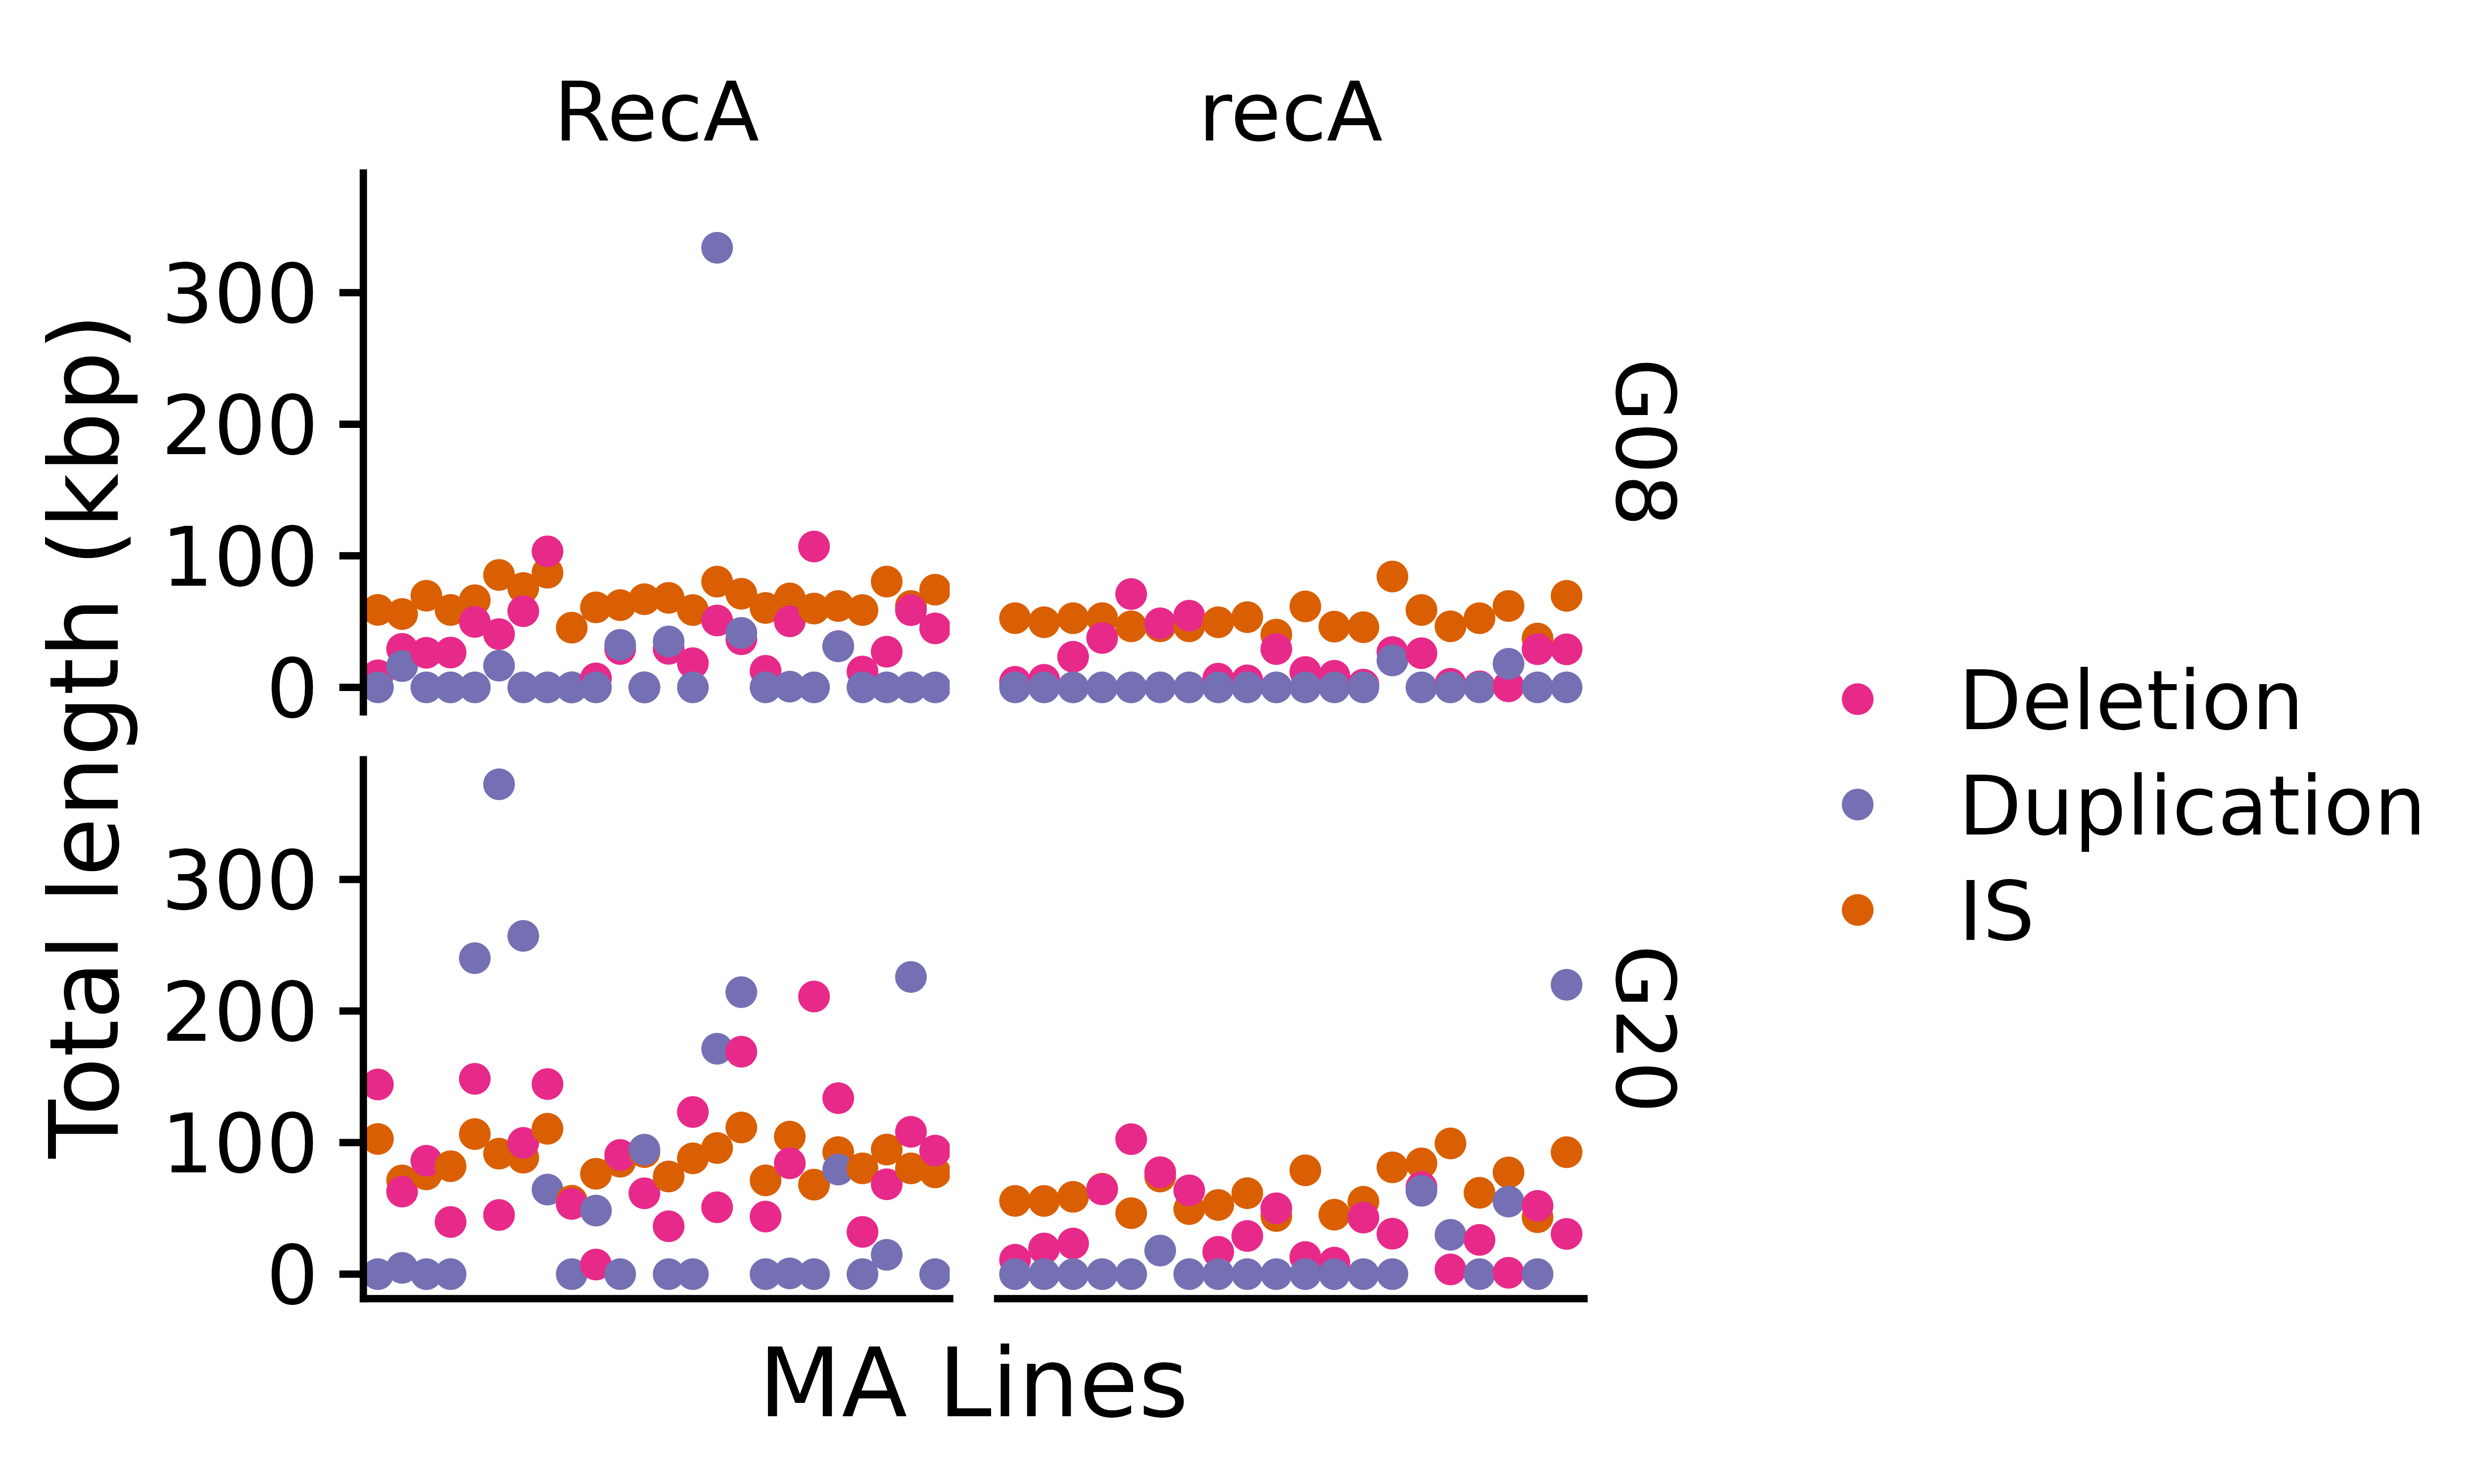

In [34]:
figure_name = file_prefix * "genome_size_content_del-dup"
@rput figure_name
R"""
colors_dark2 <- brewer.pal(7, "Dark2")

p <- genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
select(-Pristine) %>% 
mutate(RecA = ifelse(RecA, "RecA", "recA")) %>%
mutate(gen_id = ifelse(gen_id == 2, "G08", "G20")) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>%
ggplot(aes(x = Prefix, y = length/1e3, color = length_type)) +	
geom_point(aes(group = length_type)) +
scale_color_manual(values = c(colors_dark2[c(4,3,2)], c("grey")), name = "") +
facet_grid(gen_id~RecA, scales = "free_x") +
theme_half_open() +
theme(axis.text.x = element_blank(), strip.background = element_blank(), axis.ticks.x = element_blank()) +
labs(x = "MA Lines", y = "Total length (kbp)")

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=5.0, height=3.0, units="in", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=5.0, height=3.0, units="in", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=5.0, height=3.0, units="in", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

In [35]:
R"""
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
select(-Pristine) %>% 
mutate(RecA = ifelse(RecA, "RecA", "recA")) %>%
filter(gen_id > 1) %>%
mutate(gen_id = ifelse(gen_id == 2, "G08", "G20")) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>%
filter(gen_id == "G20", length_type == "Duplication") %>%
filter(length > 300000) 
"""

RObject{VecSxp}
# A tibble: 1 × 6
  Prefix gen_id is_cnt RecA  length_type length
  <chr>  <chr>   <dbl> <chr> <chr>        <dbl>
1 L02-2  G20        29 RecA  Duplication 372349


In [36]:
R"""
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
left_join(genome_stats_df %>% select(Prefix, gen_id, genome_size)) %>%
left_join(genome_stats_df %>% filter(gen_id == 1) %>% select(Prefix, is_length.anc = is_length, geome_size.anc = genome_size)) %>%
mutate(d_is_length = is_length - is_length.anc, d_genome_size = genome_size - geome_size.anc) %>%
#pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
head()
"""

┌ Warning: RCall.jl: Joining with `by = join_by(Prefix, gen_id)`
│ Joining with `by = join_by(Prefix)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 6 × 13
  Prefix gen_id is_length Deletion Duplication Pristine is_cnt  RecA genome_size
  <chr>   <dbl>     <dbl>    <dbl>       <dbl>    <dbl>  <dbl> <dbl>       <dbl>
1 L01-1       2     58901     9155           0  3955910     16     1     4014776
2 L01-2       2     55756    29274       16156  3935791     16     1     4007666
3 L01-3       2     69655    26288           0  3938777     21     1     4008366
4 L01-4       2     58839    26452           0  3938613     17     1     3997478
5 L02-1       2     66238    49742           0  3927611     21     1     3993861
6 L02-2       2     85449    40482       16503  3936871     25     1     4038944
# ℹ 4 more variables: is_length.anc <dbl>, geome_size.anc <dbl>,
#   d_is_length <dbl>, d_genome_size <dbl>


┌ Warning: RCall.jl: Joining with `by = join_by(Prefix, gen_id)`
│ Joining with `by = join_by(Prefix)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


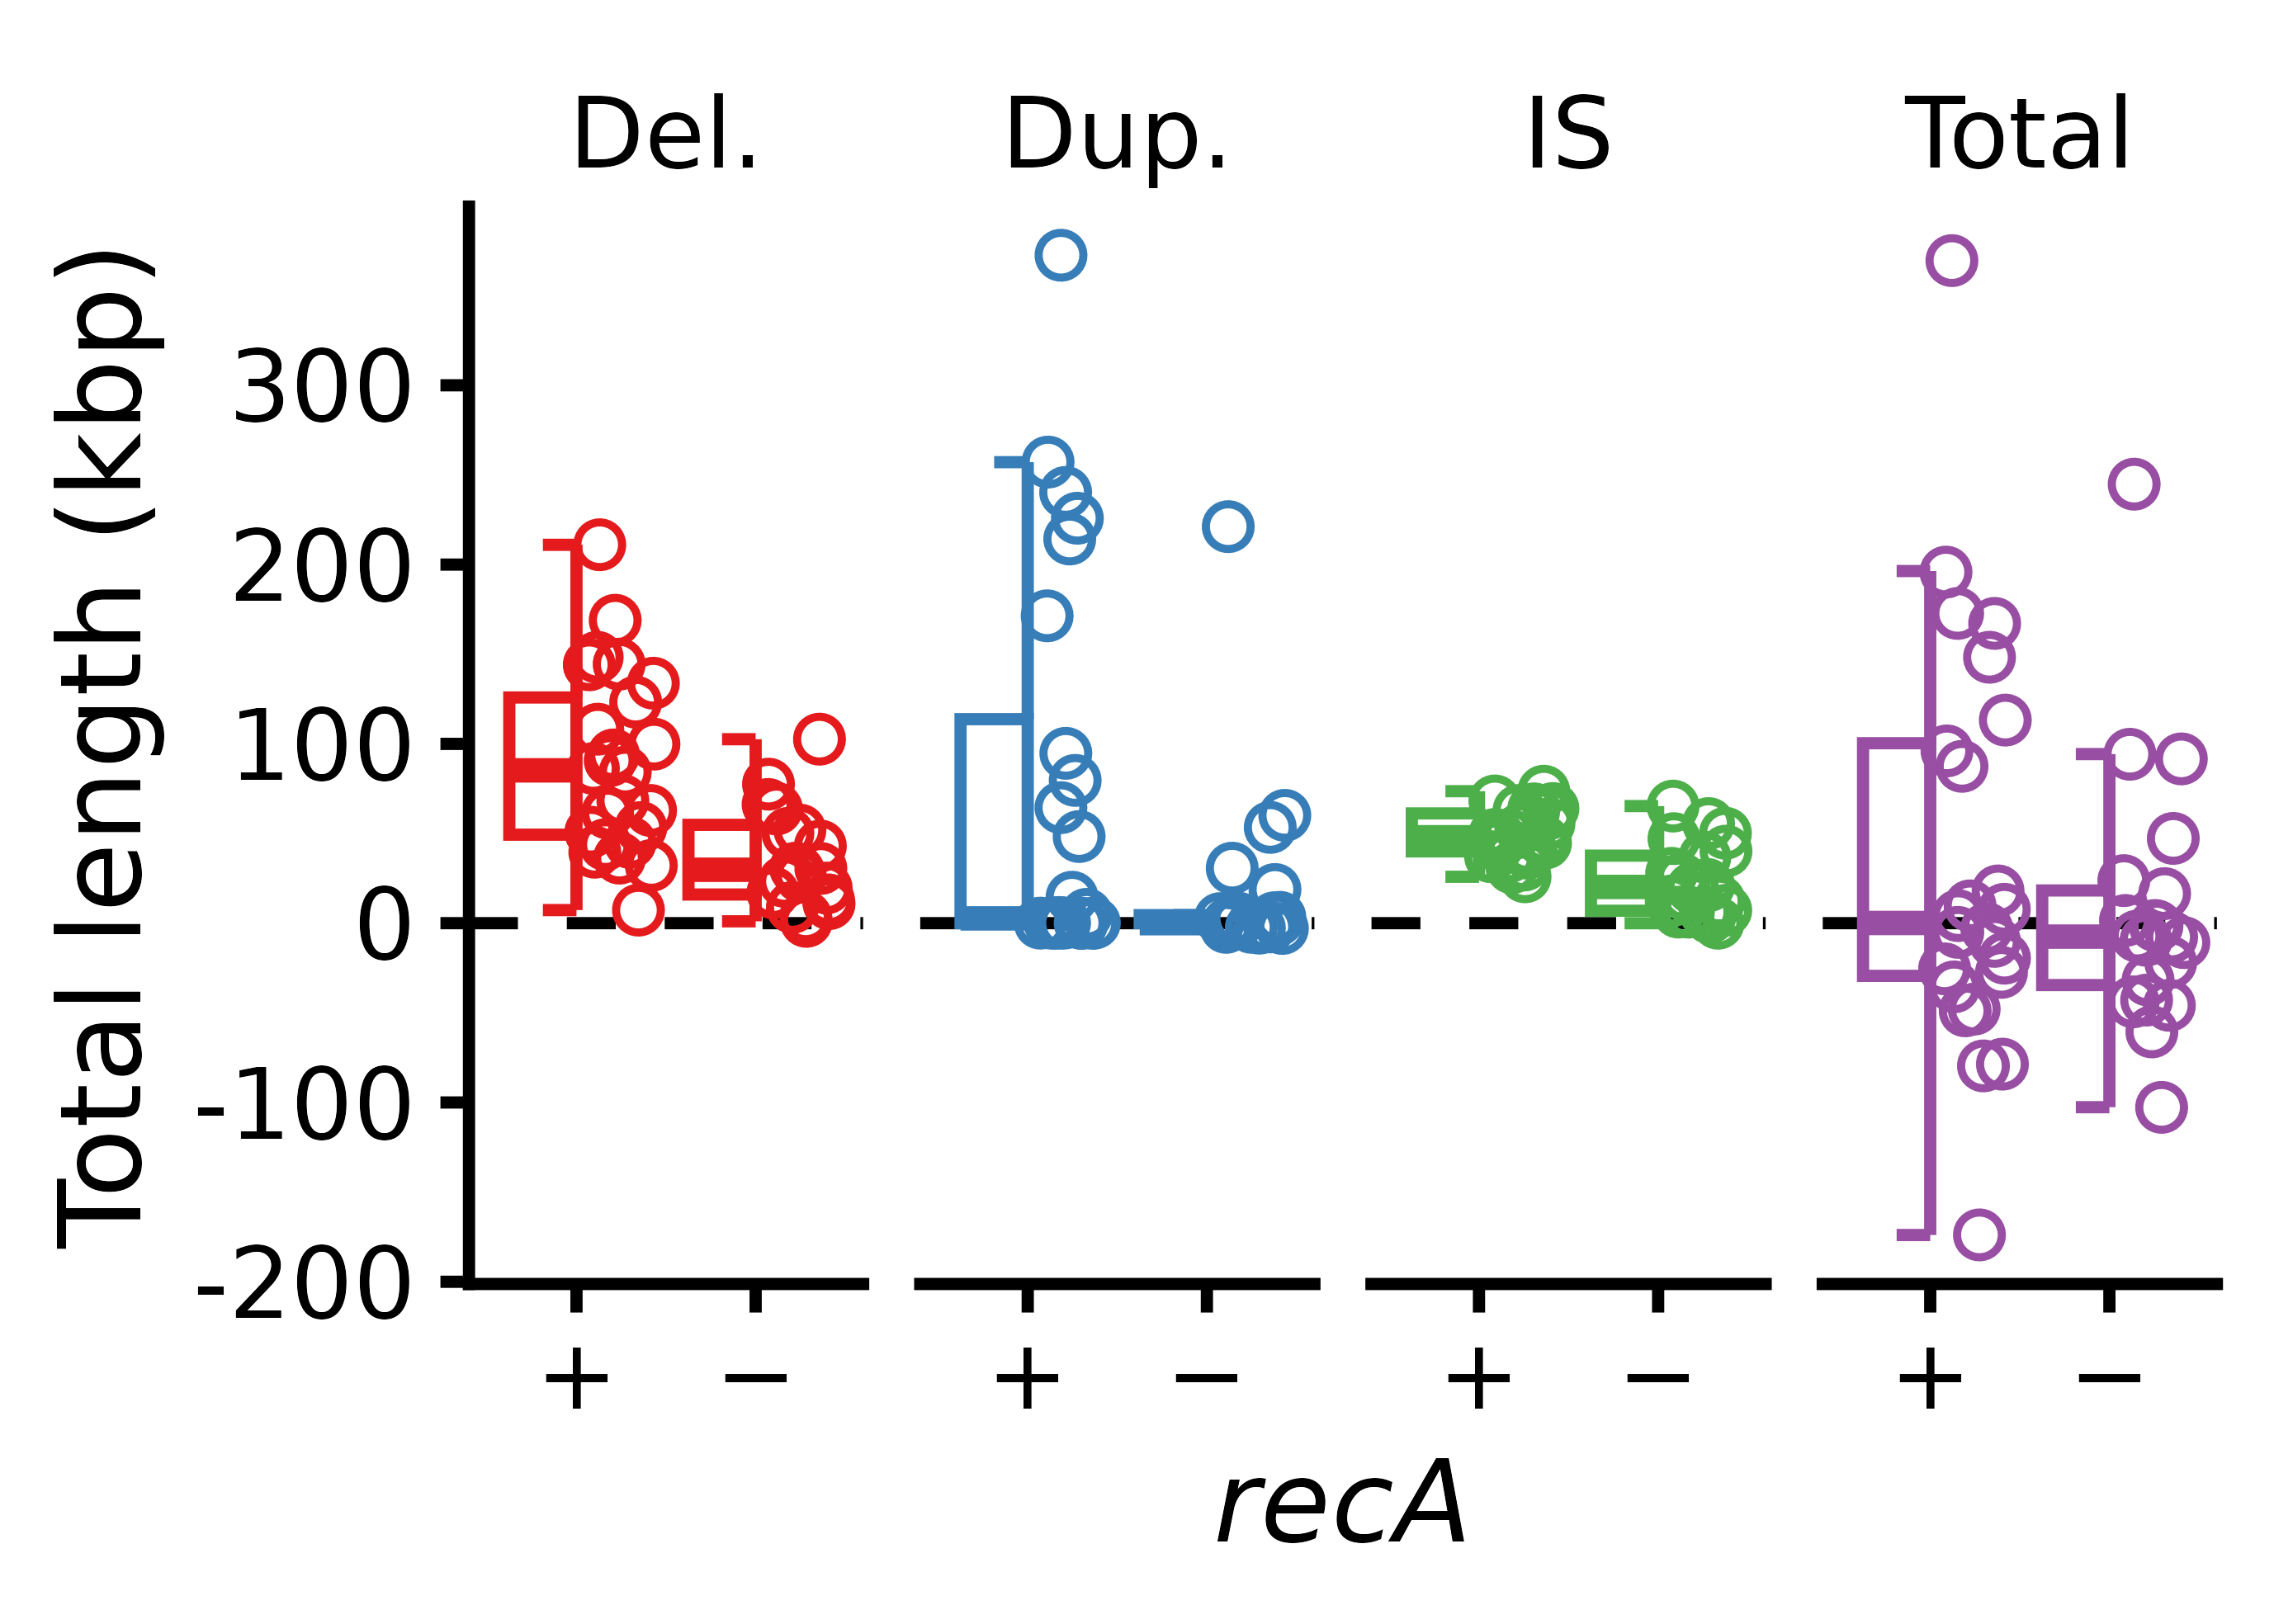

In [37]:
figure_name = file_prefix * "genome_size_content_del-dup_summary_total"
@rput figure_name
R"""
library(gghalves)
colors_dark2 <- brewer.pal(7, "Dark2")

label_names <- c(
	`Deletion` = "Del.",
	`Duplication` = "Dup.",
	`IS` = "IS",
	`Total` = "Total",
	`Genome Size` = "Total"
)

p <-
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
left_join(genome_stats_df %>% select(Prefix, gen_id, genome_size)) %>%
left_join(genome_stats_df %>% filter(gen_id == 1) %>% select(Prefix, is_length.anc = is_length, genome_size.anc = genome_size)) %>%
mutate(is_length = is_length - is_length.anc, d_genome_size = genome_size - genome_size.anc) %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, is_cnt, RecA) %>%
mutate(RecA = ifelse(RecA, "RecA", "recA")) %>%
mutate(Total = is_length - Deletion + Duplication) %>%
filter(gen_id == 3) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>%
ggplot(aes(x = RecA, y = length/1e3, color = length_type)) +	
geom_hline(yintercept = 0, linetype = "dashed") +
geom_half_boxplot(outlier.color = NA, size = 1, linewidth = .5) +
geom_half_point(shape = 1, width = 1)+
scale_x_discrete(labels = c("+", "\U2212")) +
scale_color_brewer(palette = "Set1", guide = "none") +
facet_grid(~length_type, labeller = labeller(length_type = label_names)) +
theme_half_open(10) +
labs(x = expression(italic("recA")), y = "Total length (kbp)") +
theme(axis.title.x = element_text(), strip.background = element_blank())

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=70, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=70, height=50, units="mm", dpi=1000, device = cairo_pdf)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=70, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

In [38]:
R"""
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
select(-Pristine) %>% 
mutate(RecA = ifelse(RecA, "RecA", "recA")) %>%
mutate(Total = Duplication + is_length - Deletion) %>%
filter(gen_id == 3) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>% head %>% print
genome.size.LTEE.Kanai %>% 
ungroup %>%
mutate(length = genome_size * (1- 1/genome_size_change)) %>%
filter(Group != "LTEE", time > 300)  %>% 
select(Prefix = population, length) %>%
left_join(genome_stats_df %>% filter(gen_id == 3) %>% select(Prefix, is_cnt, gen_id)) %>%
mutate(RecA = ifelse(as.numeric(str_sub(Prefix, start=2, end = 3))<=6, "RecA", "recA")) %>%
mutate(length_type = "Genome Size")
"""

# A tibble: 6 × 6
  Prefix gen_id is_cnt RecA  length_type length
  <chr>   <dbl>  <dbl> <chr> <chr>        <dbl>
1 L01-1       3     30 RecA  IS          102740
2 L01-1       3     30 RecA  Deletion    144160
3 L01-1       3     30 RecA  Duplication      0
4 L01-1       3     30 RecA  Total       -41420
5 L01-2       3     21 RecA  IS           71226
6 L01-2       3     21 RecA  Deletion     62765


┌ Warning: RCall.jl: Joining with `by = join_by(Prefix)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 44 × 6
   Prefix  length is_cnt gen_id RecA  length_type
   <chr>    <dbl>  <dbl>  <dbl> <chr> <chr>      
 1 L01-1  -80214.     30      3 RecA  Genome Size
 2 L01-2  -25476.     21      3 RecA  Genome Size
 3 L01-3  -49119.     23      3 RecA  Genome Size
 4 L01-4    3659.     24      3 RecA  Genome Size
 5 L02-1  148524.     31      3 RecA  Genome Size
 6 L02-2  369258.     29      3 RecA  Genome Size
 7 L02-3  196095      28      3 RecA  Genome Size
 8 L02-4  -19487.     34      3 RecA  Genome Size
 9 L03-1  -27659.     18      3 RecA  Genome Size
10 L03-2   87372.     24      3 RecA  Genome Size
# ℹ 34 more rows


┌ Warning: RCall.jl: Joining with `by = join_by(Prefix, gen_id)`
│ Joining with `by = join_by(Prefix)`
│ Joining with `by = join_by(Prefix)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


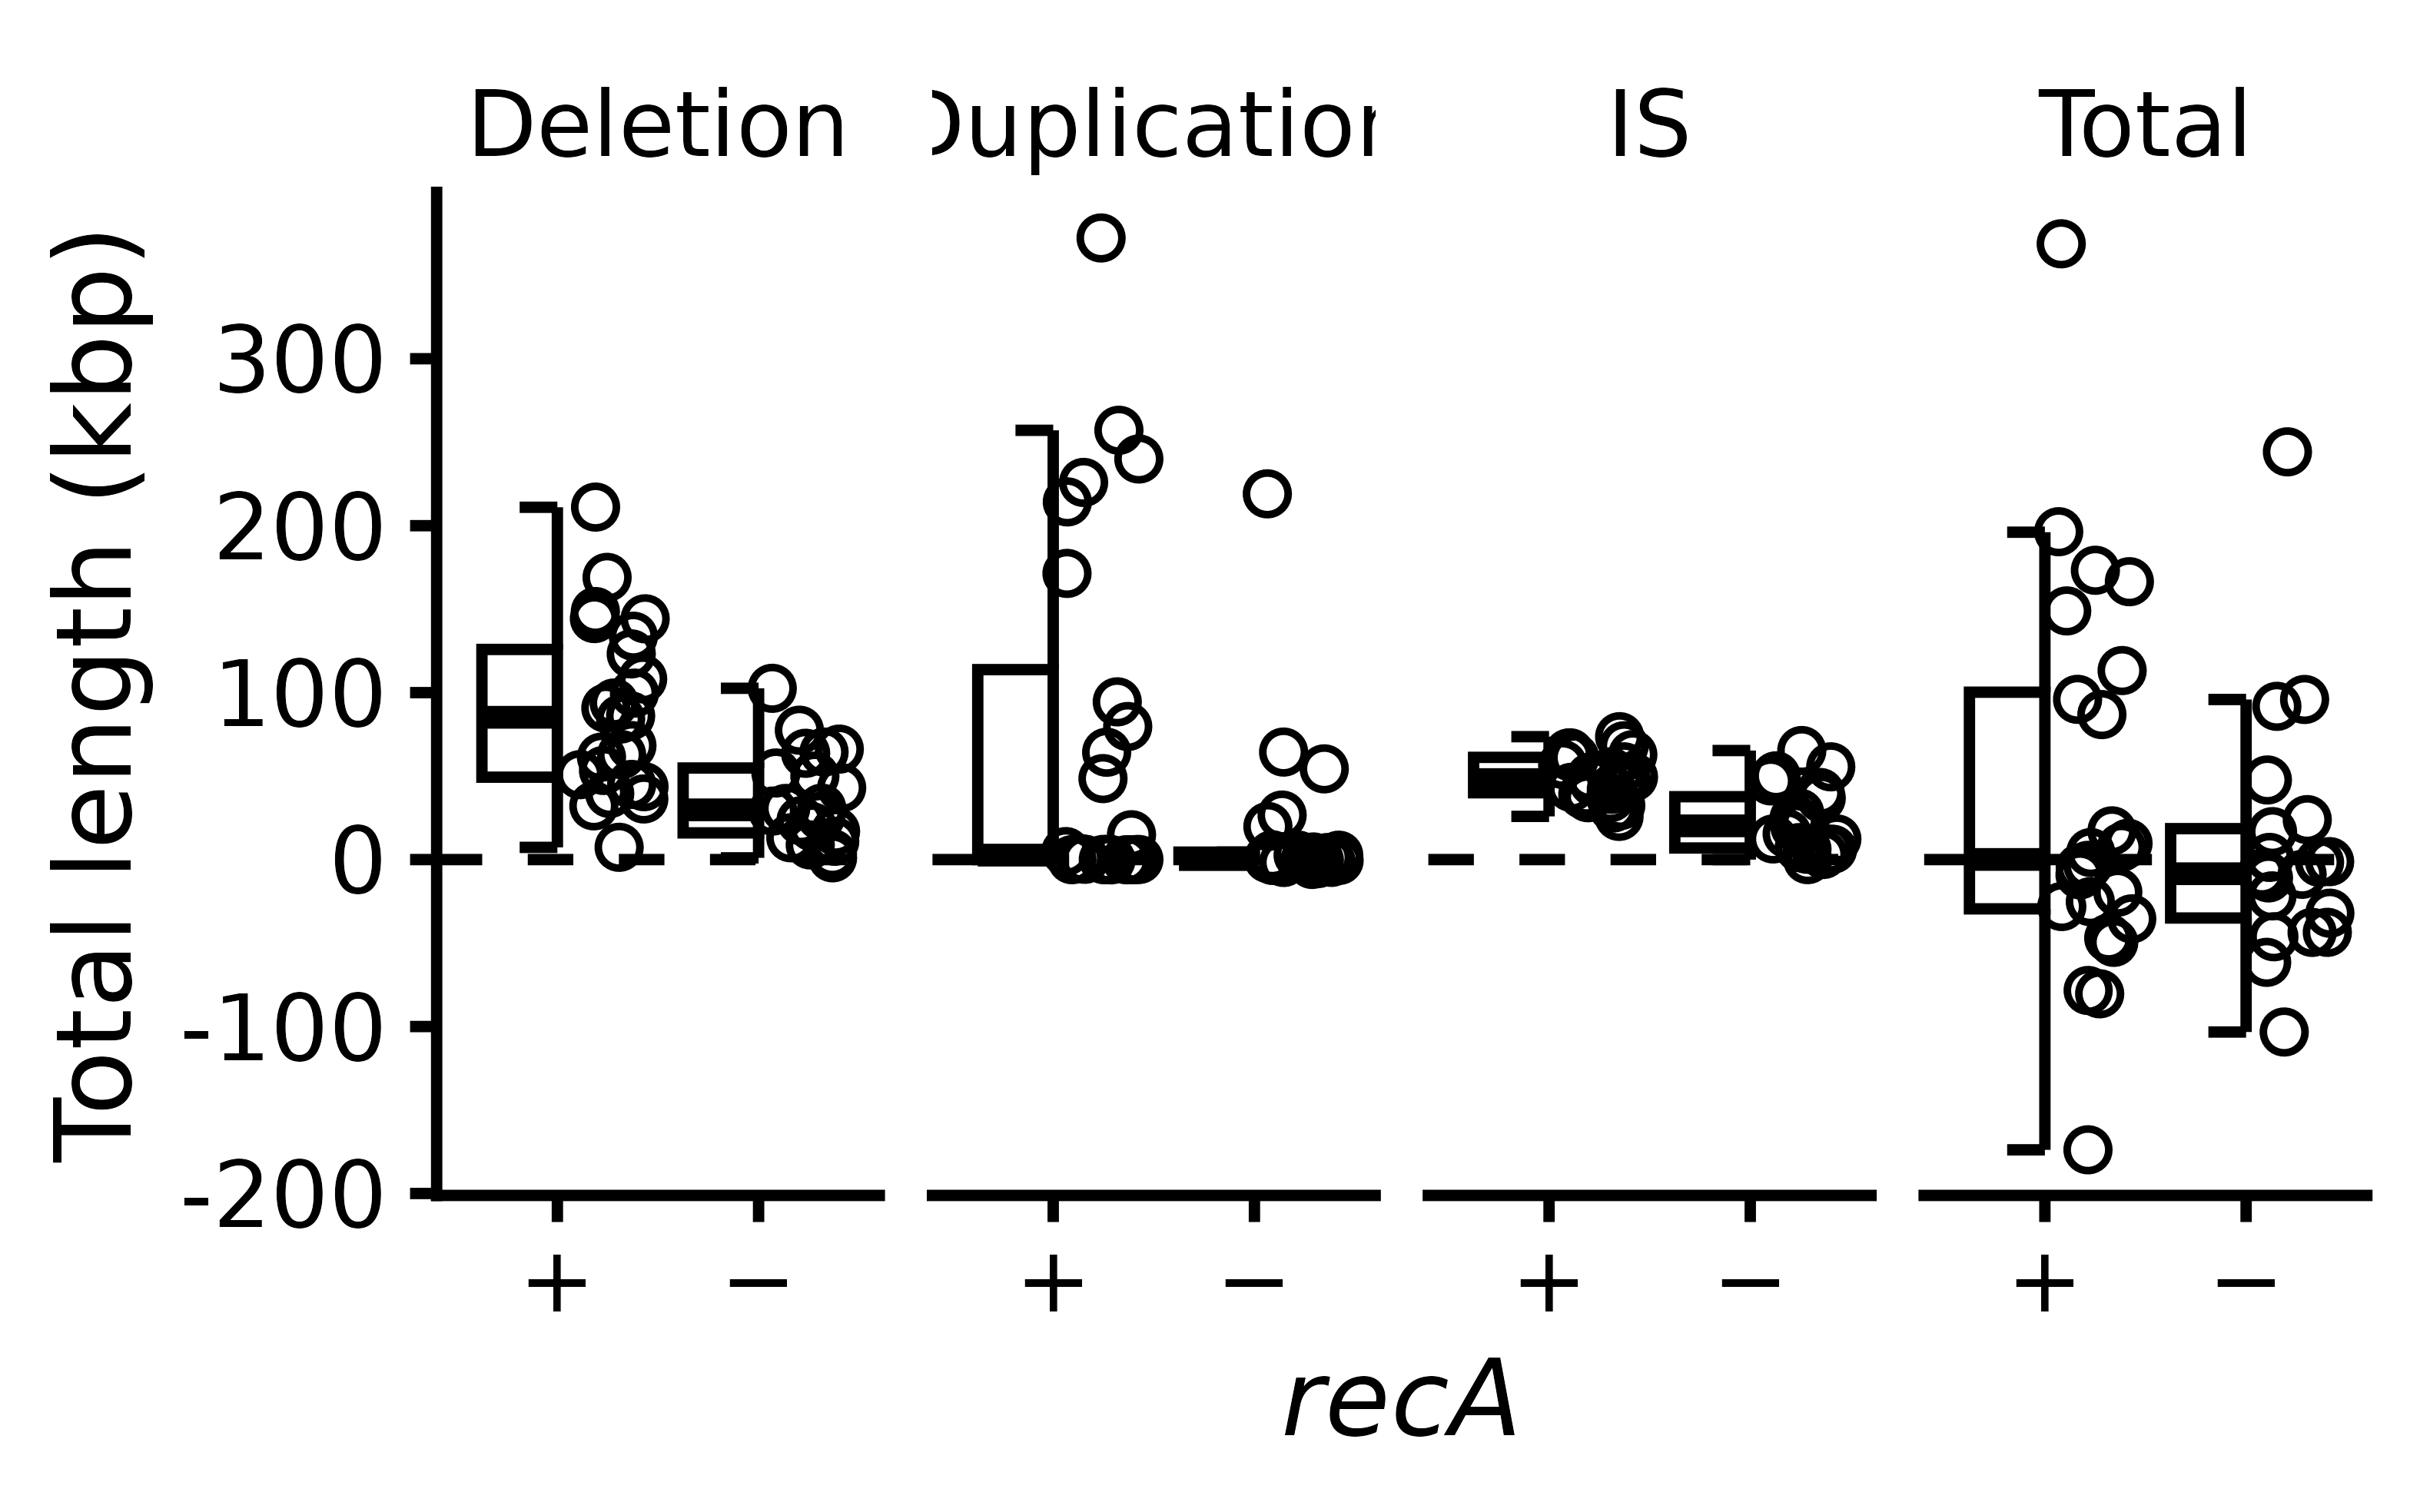

In [39]:
## REF:DEL-DUP-BALANCE
figure_name = file_prefix * "genome_size_content_del-dup_summary_total_raw_genome_size"
@rput figure_name
R"""
library(gghalves)
#colors_dark2 <- brewer.pal(7, "Dark2")
colors_dark2 <- c("black", "black", "black", "black")

label_names <- c(
	#`Deletion` = "Del.",
	`Deletion` = "Deletion",
	#`Duplication` = "Dup.",
	`Duplication` = "Duplication",
	`IS` = "IS",
	`Total` = "Sum",
	`Genome Size` = "Total"
)

p <-
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
left_join(genome_stats_df %>% select(Prefix, gen_id, genome_size)) %>%
left_join(genome_stats_df %>% filter(gen_id == 1) %>% select(Prefix, is_length.anc = is_length, genome_size.anc = genome_size)) %>%
mutate(is_length = is_length - is_length.anc, d_genome_size = genome_size - genome_size.anc) %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, is_cnt, RecA) %>%
mutate(RecA = ifelse(RecA, "RecA", "recA")) %>%
#mutate(Total = is_length - Deletion + Duplication) %>%
filter(gen_id == 3) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>%

rbind(
genome.size.LTEE.Kanai %>% 
ungroup %>%
mutate(length = genome_size * (1- 1/genome_size_change)) %>%
filter(Group != "LTEE", time > 300)  %>% 
select(Prefix = population, length) %>%
left_join(genome_stats_df %>% filter(gen_id == 3) %>% select(Prefix, is_cnt, gen_id)) %>%
mutate(RecA = ifelse(as.numeric(str_sub(Prefix, start=2, end = 3))<=6, "RecA", "recA")) %>%
mutate(length_type = "Genome Size")
) %>%
mutate(length_type = factor(length_type, levels = c("Deletion", "Duplication", "IS", "Total", "Genome Size"))) %>%
ggplot(aes(x = RecA, y = length/1e3, color = length_type)) +	
geom_hline(yintercept = 0, linetype = "dashed") +
geom_half_boxplot(outlier.color = NA, size = 1, linewidth = .5) +
geom_half_point(shape = 1, width = 1)+
scale_x_discrete(labels = c("+", "\U2212")) +
#scale_color_brewer(palette = "Set1", guide = "none") +
scale_color_manual(values = colors_dark2, guide = "none") +
facet_grid(~length_type, labeller = labeller(length_type = label_names)) +
theme_half_open(10) +
labs(x = expression(italic("recA")), y = "Total length (kbp)") +
theme(axis.title.x = element_text(), strip.background = element_blank())

p.raw.genome.size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000, device = cairo_pdf)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

┌ Warning: RCall.jl: Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on 'recA−' in 'mbcsToSbcs': dot substituted for <e2>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on 'recA−' in 'mbcsToSbcs': dot substituted for <88>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on 'recA−' in 'mbcsToSbcs': dot substituted for <92>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on 'recA−' in 'mbcsToSbcs': dot substituted for <e2>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on 'rec

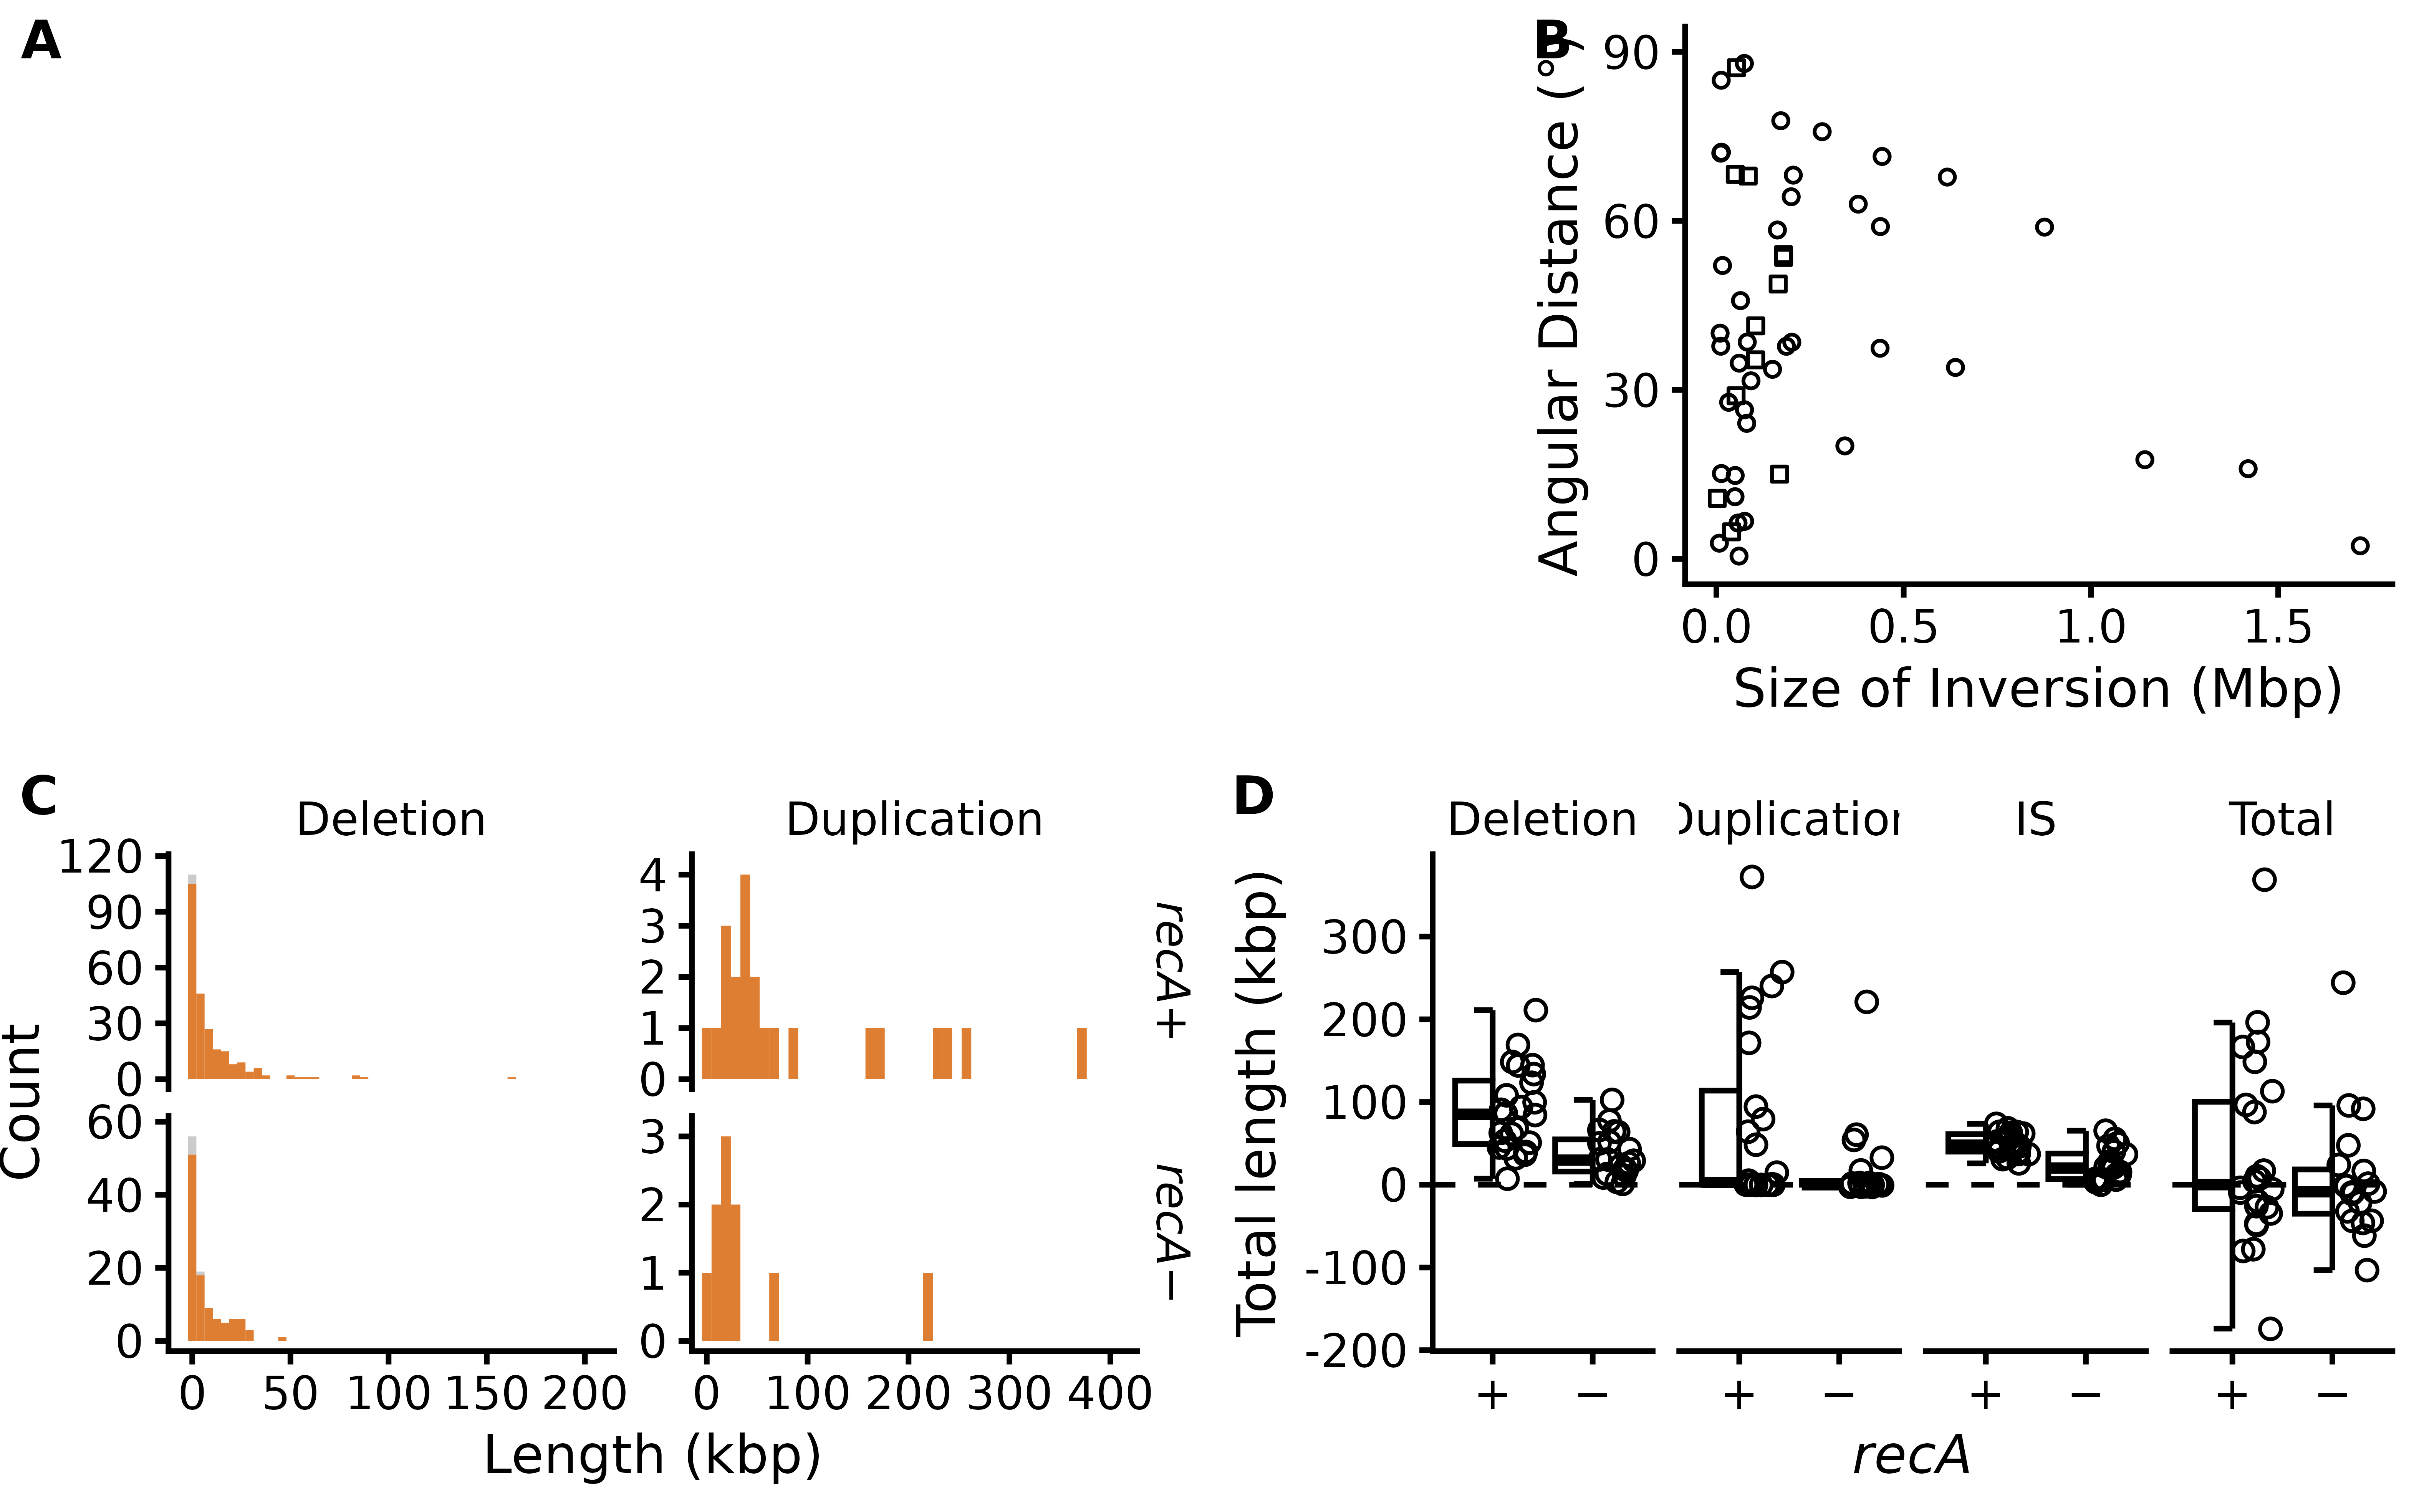

In [40]:
# combine with another plot
figure_name = file_prefix * "inv_del_length_genome-size_combined"
@rput figure_name
R"""
p.inv <- readRDS(file.path(figure_export_dir, paste0(file_prefix, "SVLEN_Angle_linear", ".rds")))
p.del.length <- readRDS(file.path(figure_export_dir, paste0(file_prefix, "Del-Dup_length_histogram", ".rds")))

p1 <- plot_grid(NULL, p.inv, 
	nrow = 1, rel_widths = c(10, 6),
	labels = c("A", "B"), label_size = 10)
p2 <- plot_grid(p.del.length, p.raw.genome.size,
	nrow = 1, rel_widths = c(8, 8), align = "h", axis = "tb",
	labels = c("C", "D"), label_size = 10) 
p <- plot_grid(p1, p2,
	nrow = 2, rel_heights = c(1, 1), align = "vh", axis = "tblr"
	) + panel_border(remove = TRUE)

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=160, height=100, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=160, height=100, units="mm", dpi=1000, device = cairo_pdf)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=160, height=100, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

┌ Warning: RCall.jl: Joining with `by = join_by(Prefix, gen_id)`
│ Joining with `by = join_by(Prefix)`
│ Joining with `by = join_by(Prefix)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


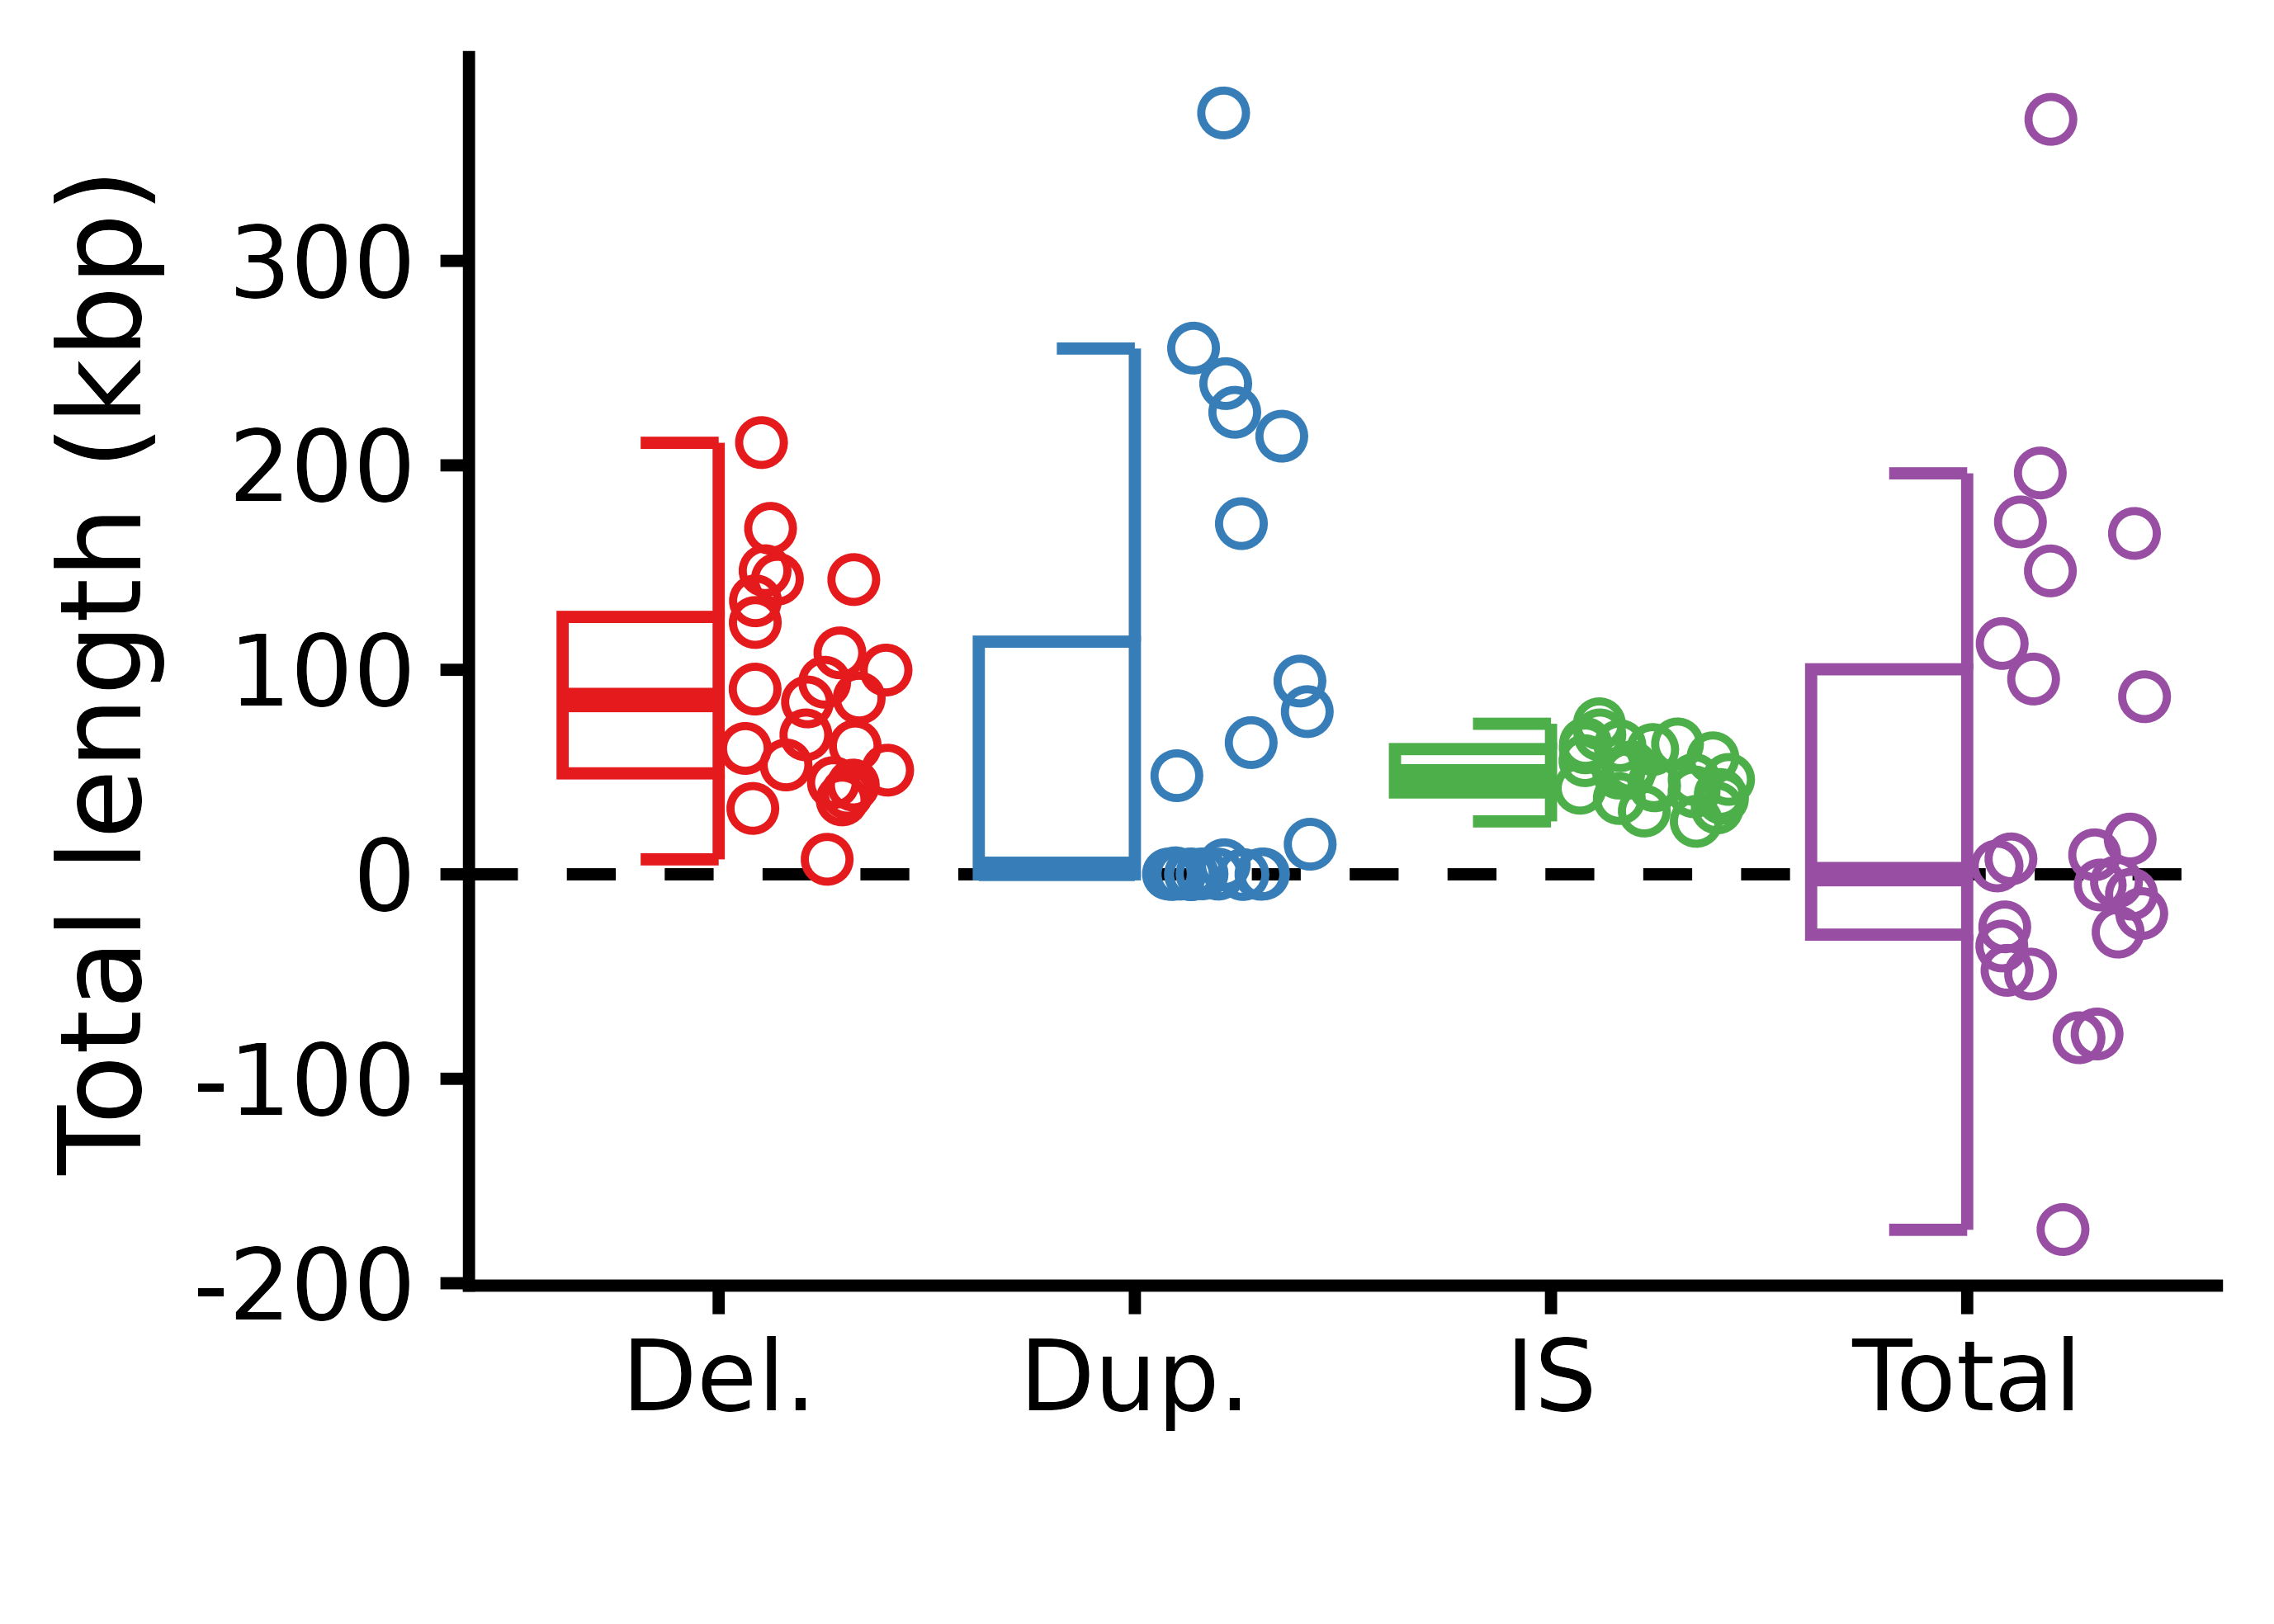

In [41]:
figure_name = file_prefix * "genome_size_content_del-dup_summary_total_raw_genome_size_recAP"
@rput figure_name
R"""
library(gghalves)
colors_dark2 <- brewer.pal(7, "Dark2")

label_names <- c(
	`Deletion` = "Del.",
	`Duplication` = "Dup.",
	`IS` = "IS",
	`Total` = "Sum",
	`Genome Size` = "Total"
)

p <-
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
left_join(genome_stats_df %>% select(Prefix, gen_id, genome_size)) %>%
left_join(genome_stats_df %>% filter(gen_id == 1) %>% select(Prefix, is_length.anc = is_length, genome_size.anc = genome_size)) %>%
mutate(is_length = is_length - is_length.anc, d_genome_size = genome_size - genome_size.anc) %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, is_cnt, RecA) %>%
mutate(RecA = ifelse(RecA, "RecA", "recA")) %>%
#mutate(Total = is_length - Deletion + Duplication) %>%
filter(gen_id == 3) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>%

rbind(
genome.size.LTEE.Kanai %>% 
ungroup %>%
mutate(length = genome_size * (1- 1/genome_size_change)) %>%
filter(Group != "LTEE", time > 300)  %>% 
select(Prefix = population, length) %>%
left_join(genome_stats_df %>% filter(gen_id == 3) %>% select(Prefix, is_cnt, gen_id)) %>%
mutate(RecA = ifelse(as.numeric(str_sub(Prefix, start=2, end = 3))<=6, "RecA", "recA")) %>%
mutate(length_type = "Genome Size")
) %>%
mutate(length_type = factor(length_type, levels = c("Deletion", "Duplication", "IS", "Total", "Genome Size"))) %>%
filter(RecA == "RecA") %>%
ggplot(aes(x = length_type, y = length/1e3, color = length_type)) +	
geom_hline(yintercept = 0, linetype = "dashed") +
geom_half_boxplot(outlier.color = NA, size = 1, linewidth = .5) +
geom_half_point(shape = 1, width = 1)+
#scale_x_discrete(labels = c("+", "\U2212")) +
scale_x_discrete(labels = label_names) +
scale_color_brewer(palette = "Set1", guide = "none") +
#facet_grid(~length_type, labeller = labeller(length_type = label_names)) +
theme_half_open(10) +
#labs(x = expression(italic("recA")), y = "Total length (kbp)") +
labs(x = "", y = "Total length (kbp)") +
theme(axis.title.x = element_text(), strip.background = element_blank())

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=70, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=70, height=50, units="mm", dpi=1000, device = cairo_pdf)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=70, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

### STAT: genome size change not captured by SVs

┌ Warning: RCall.jl: Joining with `by = join_by(Prefix, gen_id)`
│ Joining with `by = join_by(Prefix)`
│ Joining with `by = join_by(Prefix)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: Warning: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
│ ℹ Please use `linewidth` instead.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


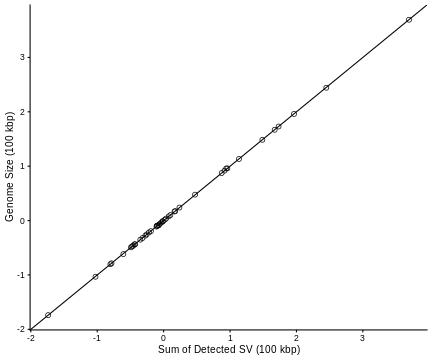

RObject{VecSxp}


In [42]:
R"""
tmp.df <- 
genome_content_plot_dat %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, Pristine, is_cnt, RecA) %>%
left_join(genome_stats_df %>% select(Prefix, gen_id, genome_size)) %>%
left_join(genome_stats_df %>% filter(gen_id == 1) %>% select(Prefix, is_length.anc = is_length, genome_size.anc = genome_size)) %>%
mutate(is_length = is_length - is_length.anc, d_genome_size = genome_size - genome_size.anc) %>%
select(Prefix, gen_id, is_length, Deletion, Duplication, is_cnt, RecA) %>%
mutate(RecA = ifelse(RecA, "RecA", "recA")) %>%
mutate(Total = is_length - Deletion + Duplication) %>%
filter(gen_id == 3) %>%
pivot_longer(-c(Prefix, gen_id, is_cnt, RecA), names_to = "length_type", values_to = "length") %>% 
mutate(length_type = ifelse(length_type == "is_length", "IS", length_type)) %>%

rbind(
genome.size.LTEE.Kanai %>% 
ungroup %>%
mutate(length = genome_size * (1- 1/genome_size_change)) %>%
filter(Group != "LTEE", time > 300)  %>% 
select(Prefix = population, length) %>%
left_join(genome_stats_df %>% filter(gen_id == 3) %>% select(Prefix, is_cnt, gen_id)) %>%
mutate(RecA = ifelse(as.numeric(str_sub(Prefix, start=2, end = 3))<=6, "RecA", "recA")) %>%
mutate(length_type = "Genome Size")
) %>%
mutate(length_type = factor(length_type, levels = c("Deletion", "Duplication", "IS", "Total", "Genome Size")))

p.scatter <- tmp.df %>%
pivot_wider(names_from = length_type, values_from = length) %>%
ggplot(aes(x = Total/1e5, y = `Genome Size`/1e5)) +
geom_point(shape = 1, size = 2)+
labs(x = "Sum of Detected SV (100 kbp)", y = "Genome Size (100 kbp)") +
geom_abline(intercept = 0, slope = 1, size = .5) +
theme_half_open(10)
"""

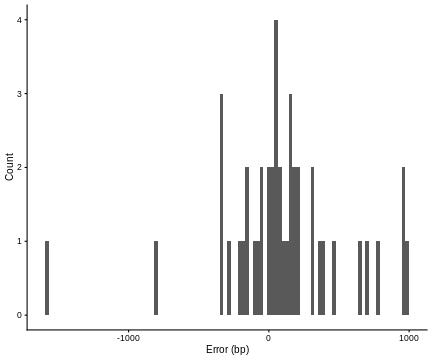

RObject{VecSxp}


In [43]:
R"""
p.hist <- 
tmp.df %>%
pivot_wider(names_from = length_type, values_from = length) %>%
ggplot(aes(x = (Total - `Genome Size`))) +
geom_histogram(bins = 100)+
labs(x = "Error (bp)", y = "Count") +
theme_half_open(10)
"""

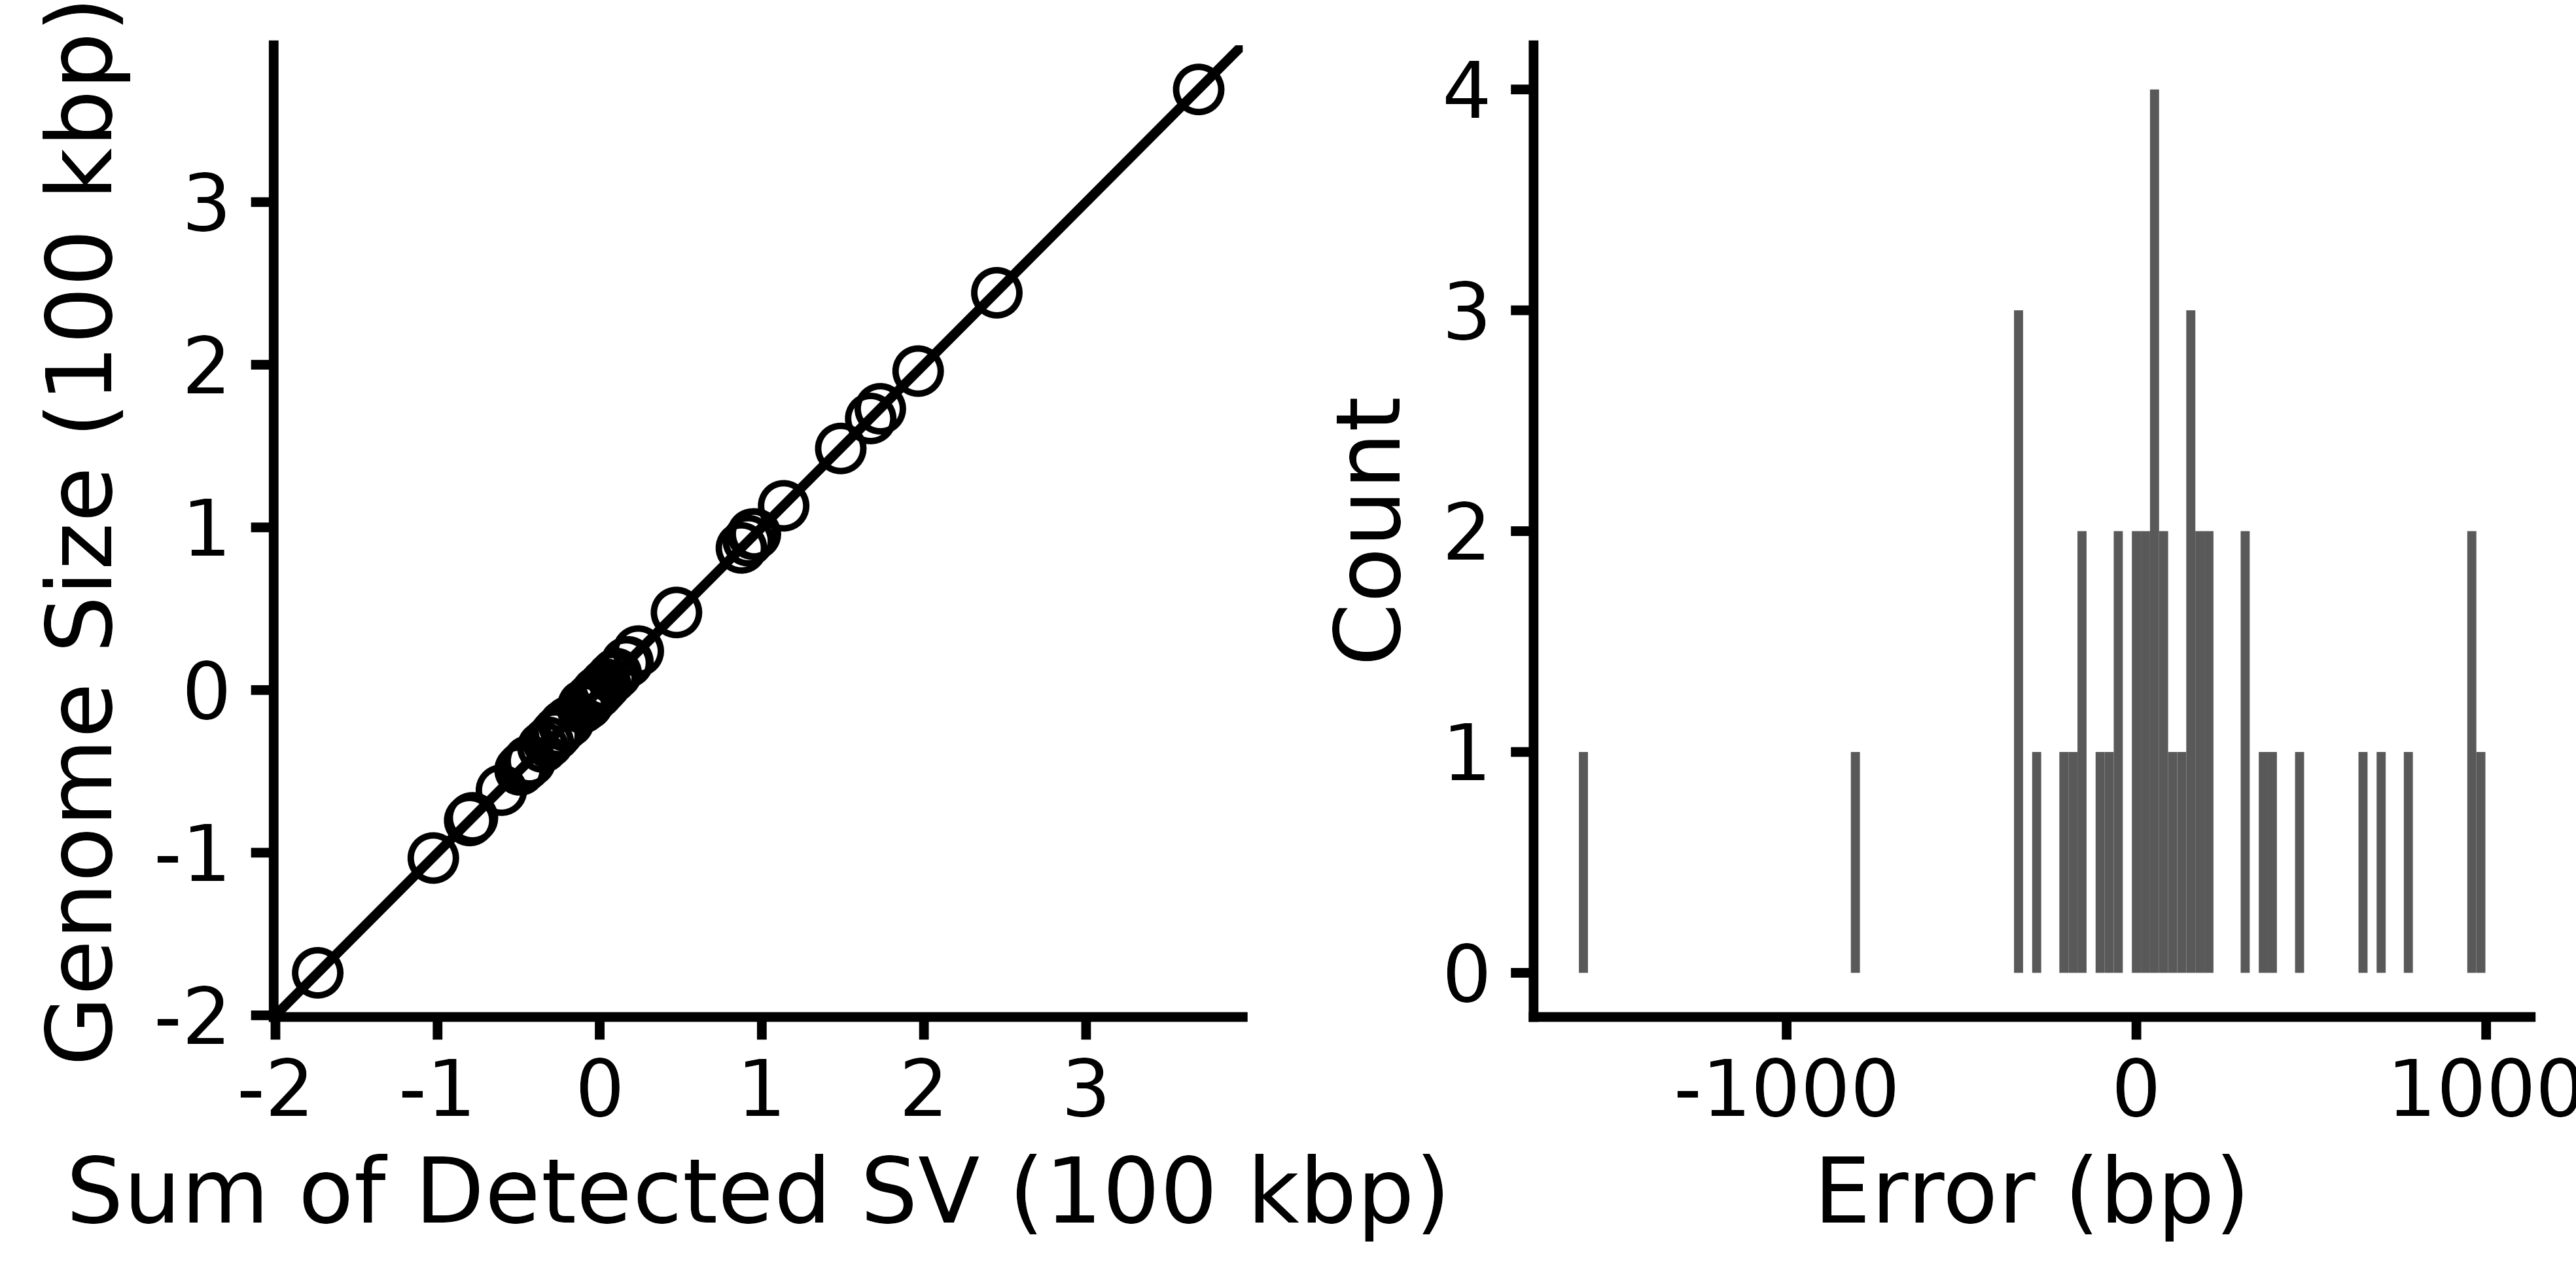

In [44]:
figure_name = file_prefix * "divergence_of_estimated_and_actual_genome_size"
@rput figure_name
R"""
p <- plot_grid(p.scatter, p.hist, nrow = 1, rel_widths = c(1, 1))

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=100, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=100, height=50, units="mm", dpi=1000, device = cairo_pdf)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=100, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

# LTEE Regression

In [45]:
R"""
LTEE.df <- read_csv("../misc/count.LTEE.masked.csv")
"""

┌ Warning: RCall.jl: Rows: 303 Columns: 136
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr   (6): file, sample, treatment, population, clone, MUTATOR_STATUS
│ dbl (130): time, total, base_substitution, small_indel, large_deletion, larg...
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 303 × 136
   file             sample treatment population  time clone MUTATOR_STATUS total
   <chr>            <chr>  <chr>     <chr>      <dbl> <chr> <chr>          <dbl>
 1 Ara+1_500gen_76… Ara+1… LTEE      Ara+1        500 A     non-mutator        4
 2 Ara+1_500gen_76… Ara+1… LTEE      Ara+1        500 B     non-mutator        3
 3 Ara+1_1000gen_9… Ara+1… LTEE      Ara+1       1000 A     non-mutator        4
 4 Ara+1_1000gen_9… Ara+1… LTEE      Ara+1       1000 B     non-mutator        2
 5 Ara+1_1500gen_1… Ara+1… LTEE      Ara+1       1500 A     non-mutator        7
 6 Ara+1_1500gen_1… Ara+1… LTEE      Ara+1       1500 B     non-mutator        6
 7 Ara+1_2000gen_1… Ara+1… LTEE      Ara+1       2000 A     non-mutator        8
 8 Ara+1_2000gen_1… Ara+1… LTEE      Ara+1       2000 B     non-mutator        9
 9 Ara+1_5000gen_2… Ara+1… LTEE      Ara+1       5000 A     IS-mutator        23
10 Ara+1_5000gen_2… Ara+1… LTEE      Ara+1       5000 B     IS-mutator 

In [46]:
R"""
LTEE.summary.med <- LTEE.df %>% select(population, sample, time, clone, inserted_bp, deleted_bp, starts_with("mobile_element")) %>%
pivot_longer(starts_with("mobile_element.mediated.IS"), names_to = "IS", values_to = "number") %>%
mutate(IS = gsub("mobile_element.mediated.IS", "IS", IS)) %>%
group_by(population, time, IS) %>% 
summarise(number = mean(number), inserted_bp = mean(inserted_bp), deleted_bp = mean(deleted_bp)) %>% 
group_by(population, time) %>%
summarise(number = sum(number), inserted_bp = mean(inserted_bp), deleted_bp = mean(deleted_bp)) %>%
ungroup
"""

┌ Warning: RCall.jl: `summarise()` has grouped output by 'population', 'time'. You can override
│ using the `.groups` argument.
│ `summarise()` has grouped output by 'population'. You can override using the
│ `.groups` argument.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 145 × 5
   population  time number inserted_bp deleted_bp
   <chr>      <dbl>  <dbl>       <dbl>      <dbl>
 1 Ara+1        500    1          674.      5508 
 2 Ara+1       1000    0.5        723       1272 
 3 Ara+1       1500    1            0       6274.
 4 Ara+1       2000    1        35681       6861 
 5 Ara+1       5000    2        17352.     26124 
 6 Ara+1      10000    3.5      86697      56574.
 7 Ara+1      15000    6       216604.     69417 
 8 Ara+1      20000    7       249738.    122286 
 9 Ara+1      30000   10       255664.    330508.
10 Ara+1      40000   12       312340.    345742.
# ℹ 135 more rows


In [47]:
R"""
LTEE.summary <- LTEE.df %>% select(population, sample, time, clone, inserted_bp, deleted_bp, starts_with("mobile_element")) %>%
pivot_longer(starts_with("mobile_element.IS"), names_to = "IS", values_to = "number") %>%
mutate(IS = gsub("mobile_element.IS", "IS", IS)) %>%
group_by(population, time, IS) %>% 
summarise(number = mean(number), inserted_bp = mean(inserted_bp), deleted_bp = mean(deleted_bp)) %>% 
group_by(population, time) %>%
summarise(number = sum(number), inserted_bp = mean(inserted_bp), deleted_bp = mean(deleted_bp)) %>%
ungroup %>%
left_join(LTEE.summary.med %>% select(population, time, is.med = number))
"""

┌ Warning: RCall.jl: `summarise()` has grouped output by 'population', 'time'. You can override
│ using the `.groups` argument.
│ `summarise()` has grouped output by 'population'. You can override using the
│ `.groups` argument.
│ Joining with `by = join_by(population, time)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 145 × 6
   population  time number inserted_bp deleted_bp is.med
   <chr>      <dbl>  <dbl>       <dbl>      <dbl>  <dbl>
 1 Ara+1        500    0.5        674.      5508     1  
 2 Ara+1       1000    0.5        723       1272     0.5
 3 Ara+1       1500    0            0       6274.    1  
 4 Ara+1       2000    3        35681       6861     1  
 5 Ara+1       5000   11.5      17352.     26124     2  
 6 Ara+1      10000   17        86697      56574.    3.5
 7 Ara+1      15000   18.5     216604.     69417     6  
 8 Ara+1      20000   22.5     249738.    122286     7  
 9 Ara+1      30000   31       255664.    330508.   10  
10 Ara+1      40000   36.5     312340.    345742.   12  
# ℹ 135 more rows


### IS Event count vs generations lm

In [48]:
R"""
LTEE.lm.IS.time.med <- lm(Event_CNT ~ Generations + 0, data = c.f.3ab) 
LTEE.lm.IS.time.med %>% summary %>% print
print(paste("IS-mediated mutation rate", coefficients(LTEE.lm.IS.time.med)[1], "per generation"))
""";


Call:
lm(formula = Event_CNT ~ Generations + 0, data = c.f.3ab)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.535  -1.739   0.145   1.629  44.272 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
Generations 4.807e-04  3.238e-05   14.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.51 on 143 degrees of freedom
Multiple R-squared:  0.6065,	Adjusted R-squared:  0.6038 
F-statistic: 220.4 on 1 and 143 DF,  p-value: < 2.2e-16

[1] "IS-mediated mutation rate 0.000480709943551889 per generation"


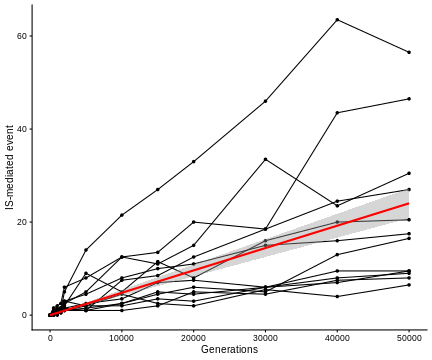

RObject{VecSxp}


In [49]:
R"""
ggplot(c.f.3ab, aes(x = Generations, y = Event_CNT)) +
geom_line(aes(group = Population)) +
geom_point(size =1) +
stat_smooth(method = "lm", col = "red", formula=y~0+x) +
theme_half_open(10) +
labs(x= "Generations", y = "IS-mediated event")
"""

In [50]:
R"""
genome.size.IS.LTEE <-
genome.size.LTEE.Kanai %>%
filter(time > 100) %>%
mutate(Source = Group) %>%
filter(Source =="LTEE")  %>% 
filter(time == 50000) %>%
left_join(c.f.3ab %>% filter(Generations == 50000) %>%
	select(population = Population, INS = Event_CNT)) 
"""

┌ Warning: RCall.jl: Joining with `by = join_by(population)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 12 × 7
# Groups:   time [1]
    time population genome_size Group genome_size_change Source   INS
   <dbl> <chr>            <dbl> <chr>              <dbl> <chr>  <dbl>
 1 50000 Ara+1         4547279  LTEE               0.982 LTEE    56.5
 2 50000 Ara+2         4589733  LTEE               0.991 LTEE    17.5
 3 50000 Ara+3         4539094  LTEE               0.980 LTEE     6.5
 4 50000 Ara+4         4646574  LTEE               1.00  LTEE     8  
 5 50000 Ara+5         4628214. LTEE               1.00  LTEE    20.5
 6 50000 Ara+6         4566470. LTEE               0.986 LTEE     9  
 7 50000 Ara-1         4597260  LTEE               0.993 LTEE     9.5
 8 50000 Ara-2         4513385  LTEE               0.975 LTEE    16.5
 9 50000 Ara-3         4549482. LTEE               0.983 LTEE    46.5
10 50000 Ara-4         4451694  LTEE               0.962 LTEE     9.5
11 50000 Ara-5         4593723  LTEE               0.992 LTEE    30.5
12 50000 Ara-6         4588370  LT

In [51]:
R"""
genome.size.IS.Kanai <- 
genome.size.LTEE.Kanai %>%
filter(time > 100) %>%
mutate(Source = Group) %>%
mutate(Source = ifelse(Source == "This Study", ifelse(as.numeric(str_sub(population, start=2, end = 3))<=6, "RecA", "recA"), Source)) %>%
filter(Source !="LTEE") %>%
mutate(gen_id = ifelse(time == 184, 2, 3)) %>%
left_join(genome_stats_df %>% select(population = Prefix, gen_id, INS = new_cnt_anc)) %>%
mutate(LTEE.gen = INS/LTEE.lm.IS.time.med$coefficients[1]) %>%
filter(gen_id > 2) %>%
mutate(RecA = ifelse(as.numeric(str_sub(population, start=2, end =3))<=6, "recA+", "recA-")) #%>%
#filter(RecA == "recA+") 
#IS_ins_cnt
#coefficients(LTEE.lm.IS.time.med)[1]

"""

┌ Warning: RCall.jl: Joining with `by = join_by(population, gen_id)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


RObject{VecSxp}
# A tibble: 44 × 10
# Groups:   time [1]
    time population genome_size Group     genome_size_change Source gen_id   INS
   <dbl> <chr>            <dbl> <chr>                  <dbl> <chr>   <dbl> <dbl>
 1   460 L01-1          3923637 This Stu…              0.980 RecA        3    31
 2   460 L01-2          3978375 This Stu…              0.994 RecA        3    21
 3   460 L01-3          3954732 This Stu…              0.988 RecA        3    29
 4   460 L01-4          4007510 This Stu…              1.00  RecA        3    21
 5   460 L02-1          4175370 This Stu…              1.04  RecA        3    24
 6   460 L02-2          4396104 This Stu…              1.09  RecA        3    19
 7   460 L02-3          4222941 This Stu…              1.05  RecA        3    20
 8   460 L02-4          4007359 This Stu…              0.995 RecA        3    33
 9   460 L03-1          3918256 This Stu…              0.993 RecA        3    15
10   460 L03-2          4033287 This Stu…           

In [52]:
R"""
genome.size.IS <-
genome.size.IS.Kanai %>% 
rbind(
	genome.size.IS.LTEE %>%
		mutate(LTEE.gen = time, RecA = NA)
)
"""

RObject{VecSxp}
# A tibble: 56 × 10
# Groups:   time [2]
    time population genome_size Group     genome_size_change Source gen_id   INS
   <dbl> <chr>            <dbl> <chr>                  <dbl> <chr>   <dbl> <dbl>
 1   460 L01-1          3923637 This Stu…              0.980 RecA        3    31
 2   460 L01-2          3978375 This Stu…              0.994 RecA        3    21
 3   460 L01-3          3954732 This Stu…              0.988 RecA        3    29
 4   460 L01-4          4007510 This Stu…              1.00  RecA        3    21
 5   460 L02-1          4175370 This Stu…              1.04  RecA        3    24
 6   460 L02-2          4396104 This Stu…              1.09  RecA        3    19
 7   460 L02-3          4222941 This Stu…              1.05  RecA        3    20
 8   460 L02-4          4007359 This Stu…              0.995 RecA        3    33
 9   460 L03-1          3918256 This Stu…              0.993 RecA        3    15
10   460 L03-2          4033287 This Stu…           

┌ Warning: RCall.jl: Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

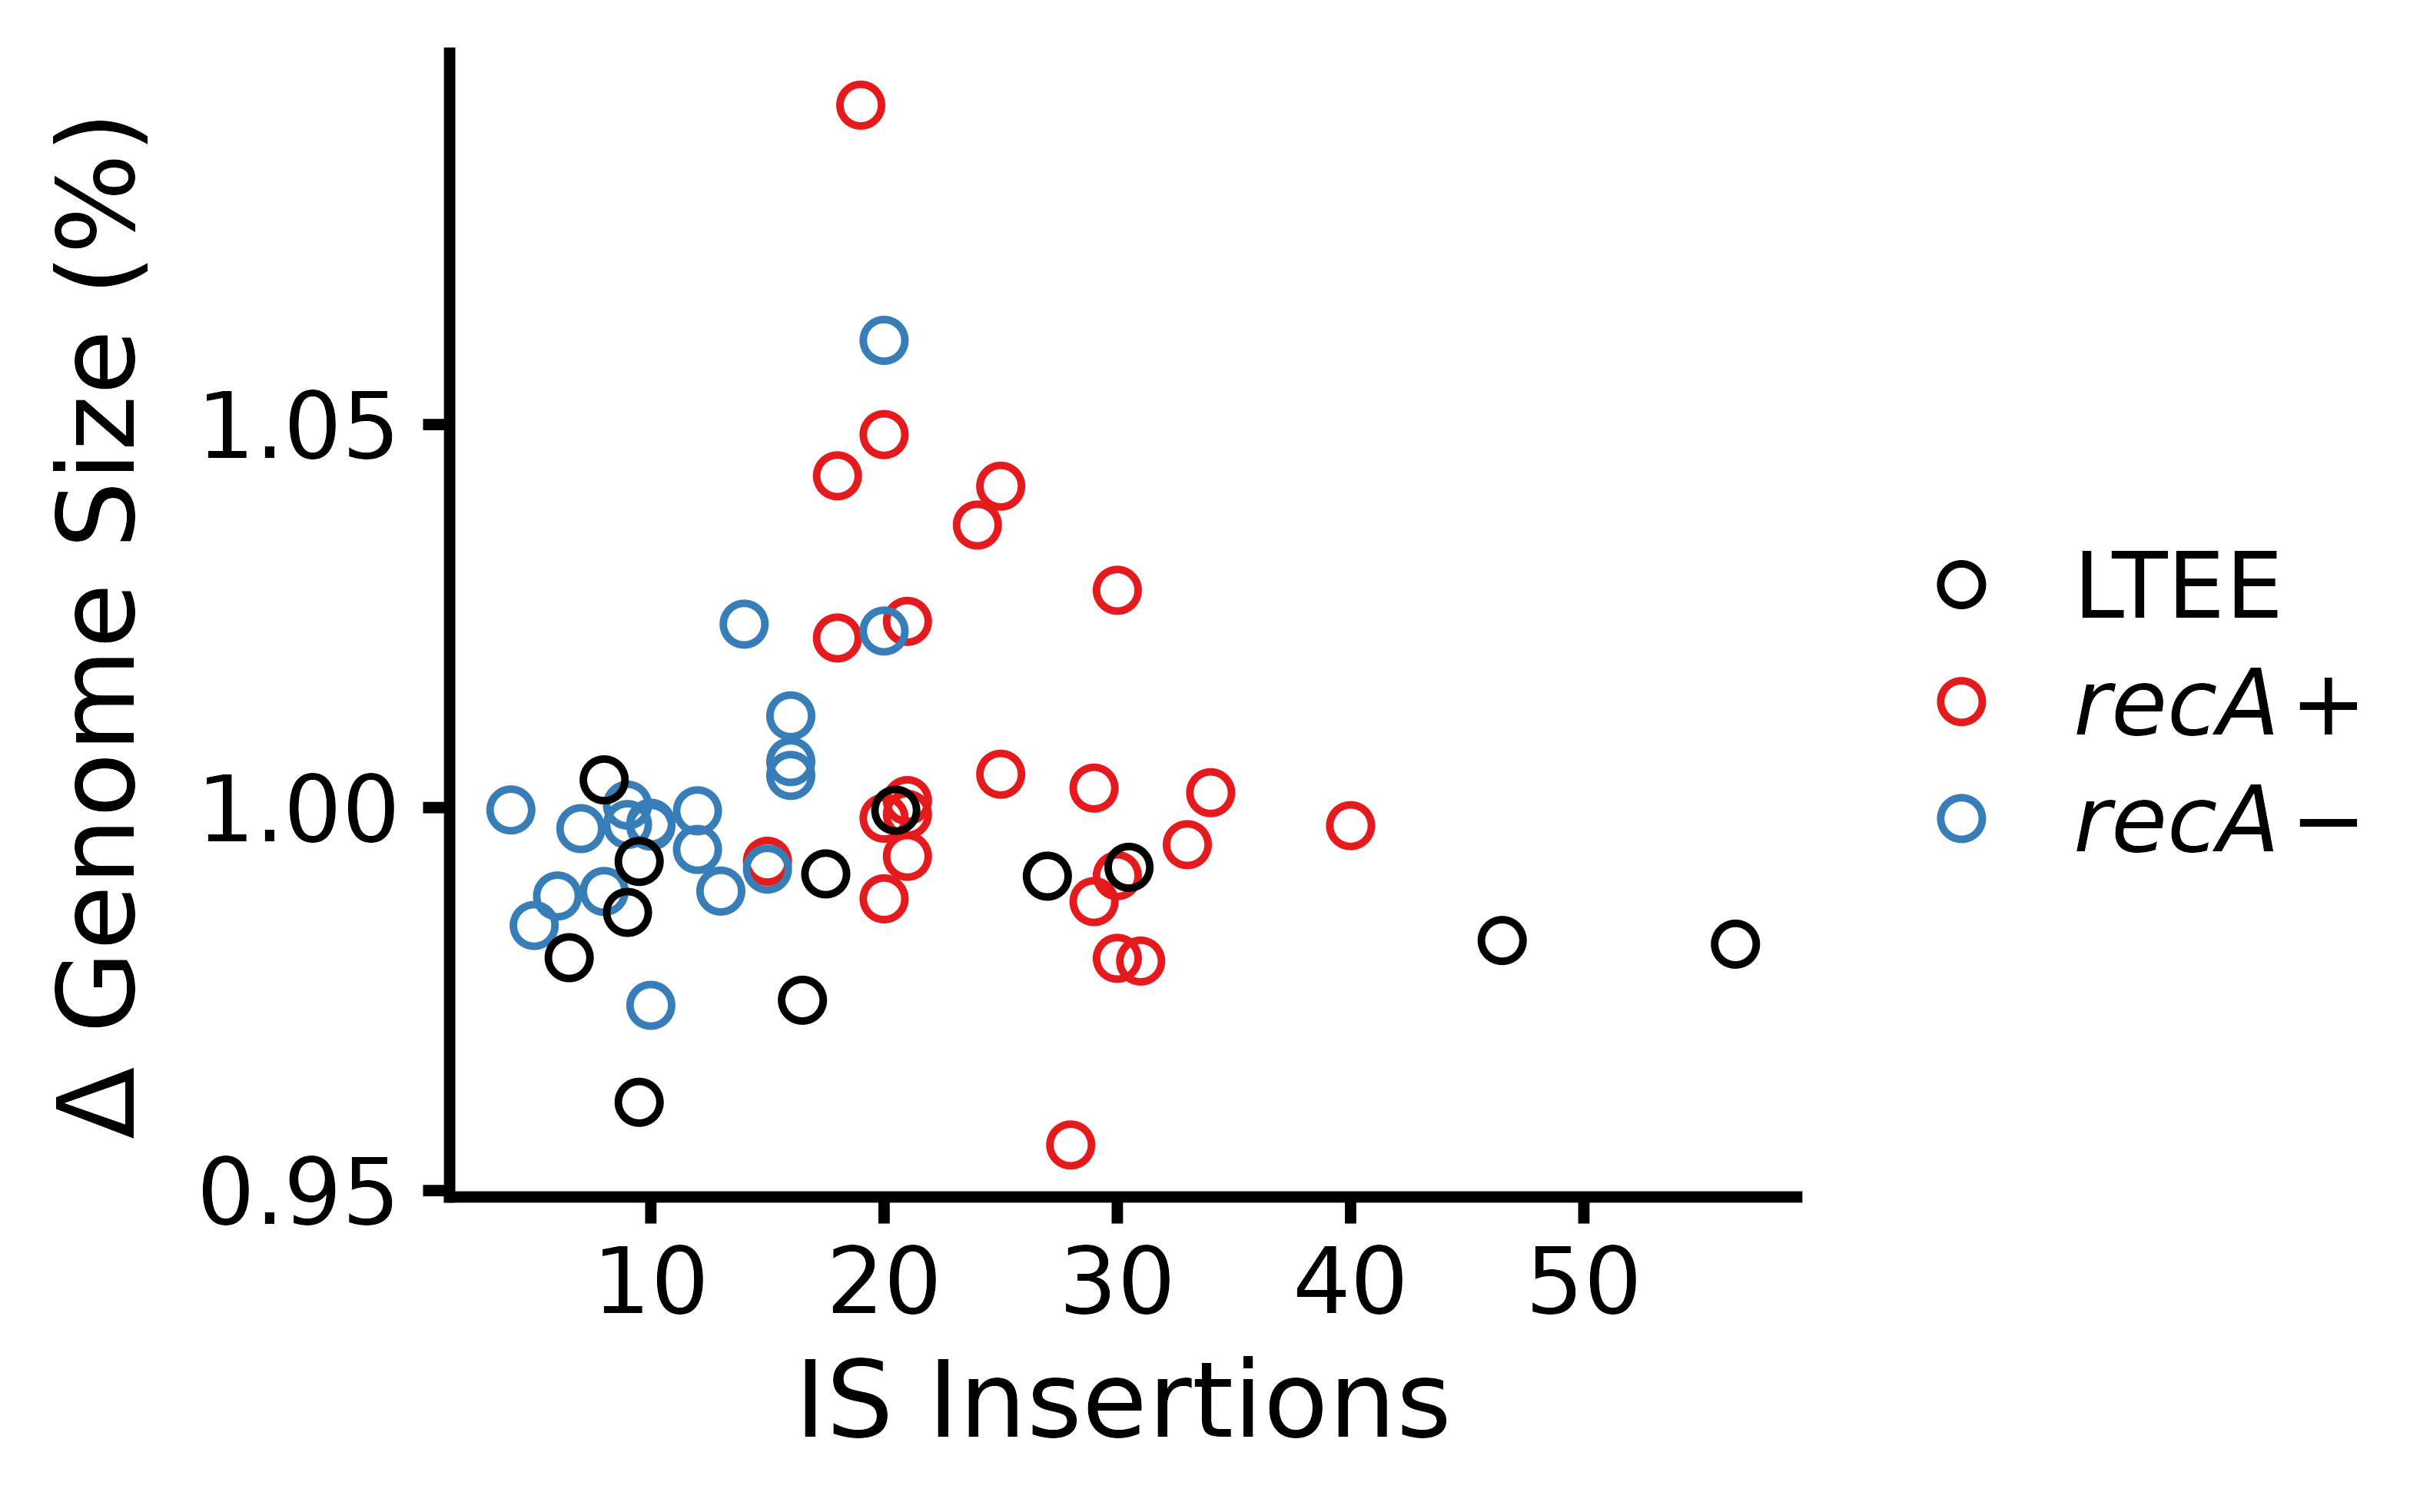

In [53]:
figure_name = file_prefix * "LTEE.IS.genome.change"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic("recA"), "+")), expression(paste(italic("recA"), "\u2212")))
p <- genome.size.IS %>% 
ggplot(aes(x = INS, y = genome_size_change, color = Source)) +
geom_point(shape = 1) +
scale_color_manual(values = c("black", "#E41A1C", "#377EB8"), labels = labs_, name ="") +
labs(x = "IS Insertions", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

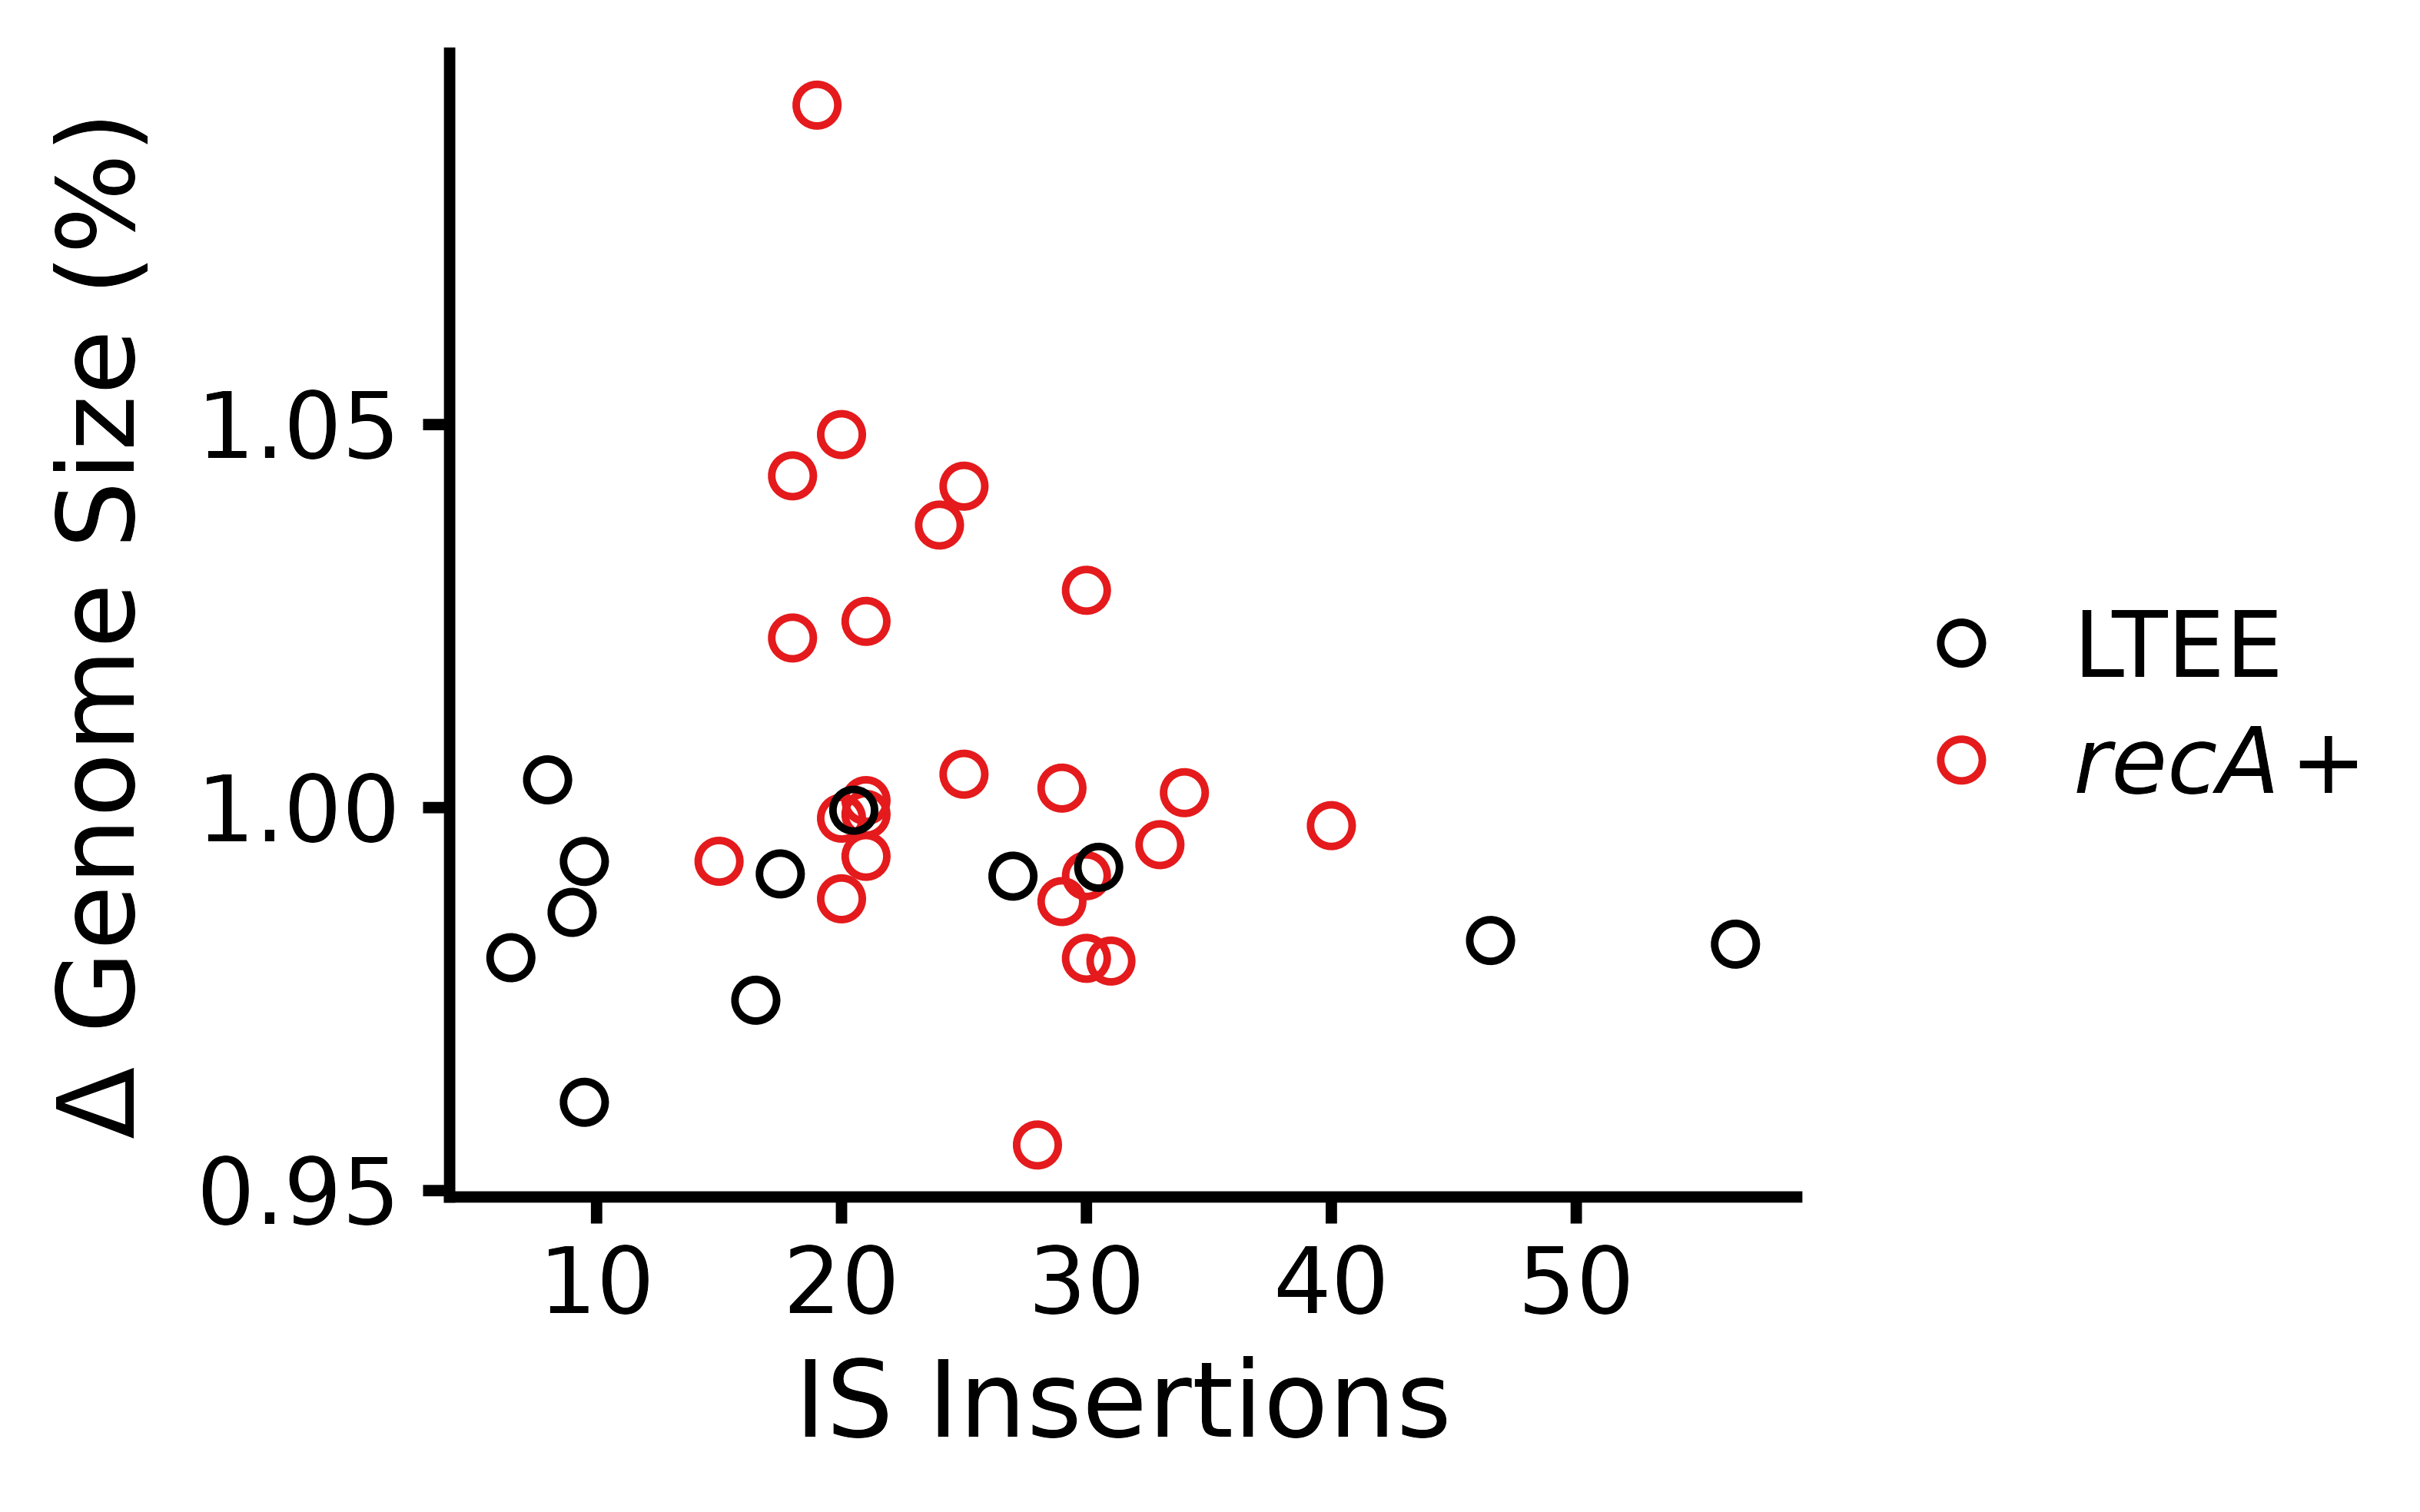

In [54]:
figure_name = file_prefix * "LTEE.IS.genome.change.recAP"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic("recA"), "+")), expression(paste(italic("recA"), "\u2212")))
p <- genome.size.IS %>% 
filter(Source != "recA") %>%
ggplot(aes(x = INS, y = genome_size_change, color = Source)) +
geom_point(shape = 1) +
scale_color_manual(values = c("black", "#E41A1C", "#377EB8"), labels = labs_, name ="") +
labs(x = "IS Insertions", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

┌ Warning: RCall.jl: Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

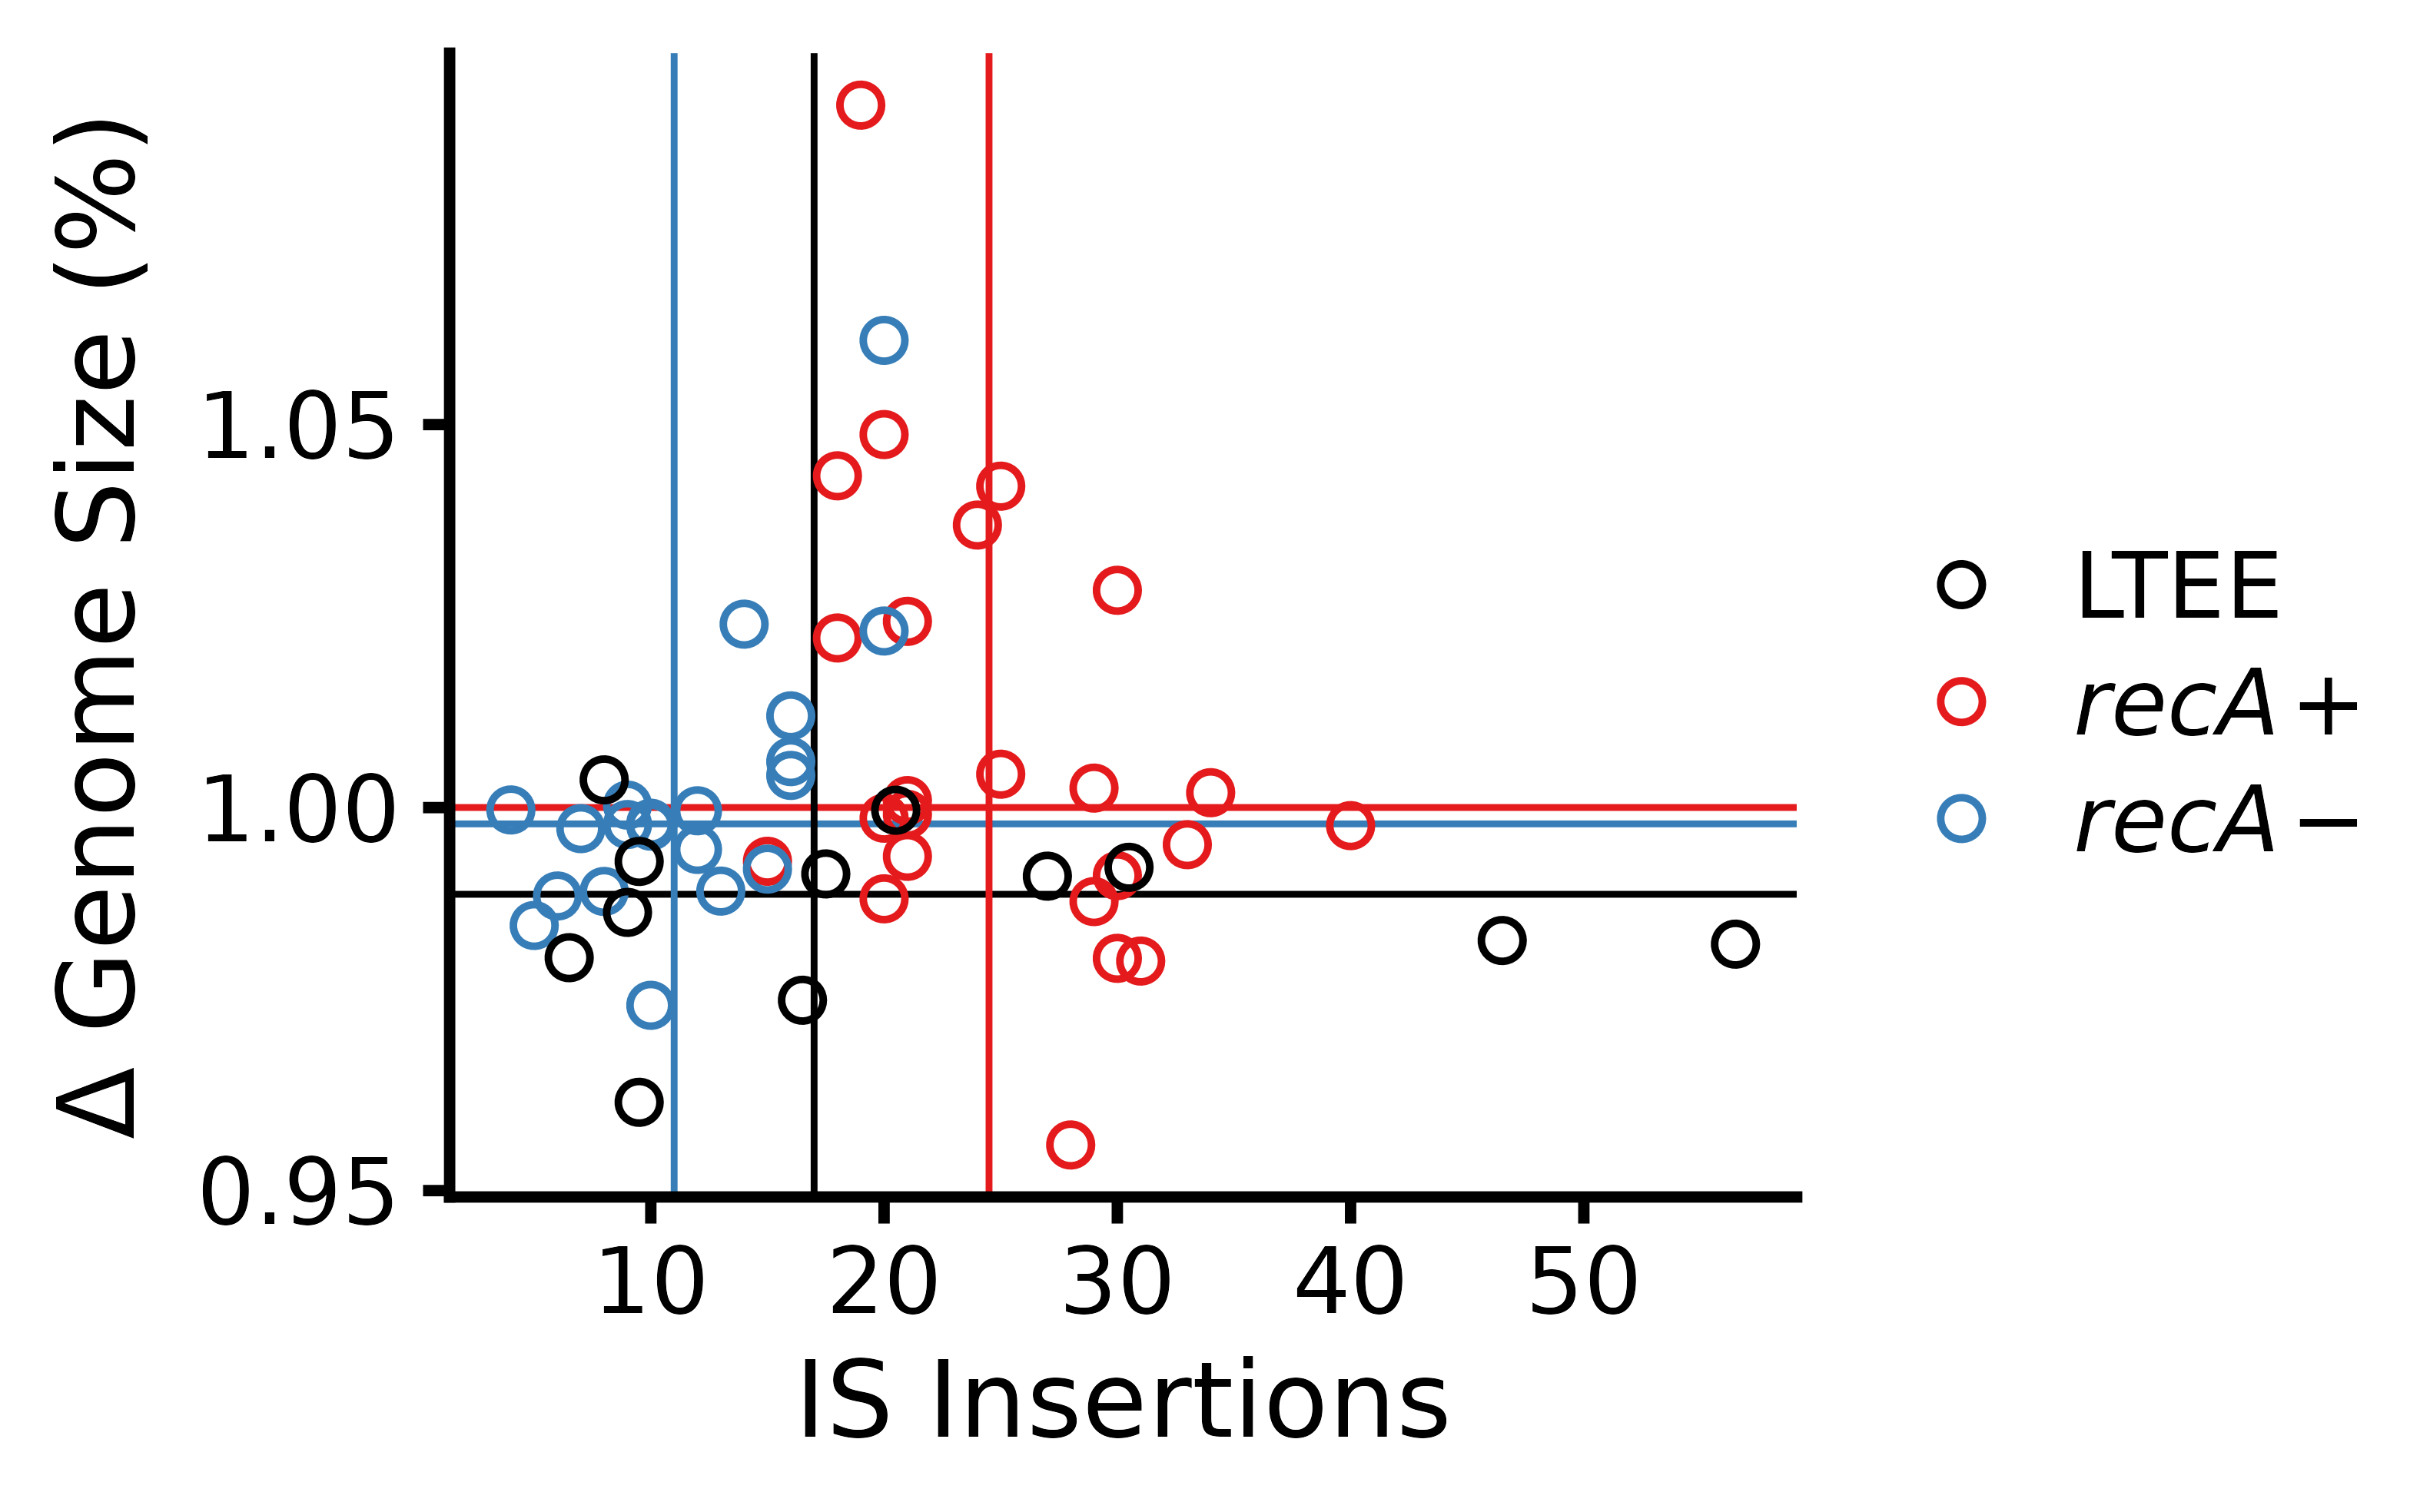

In [55]:
figure_name = file_prefix * "LTEE.IS.genome.change.med"
@rput figure_name
R"""
LTEE.IS.med <- genome.size.IS %>% filter(Group == "LTEE") %>% pull(INS) %>% median
recAP.IS.med <- genome.size.IS %>% filter(Source == "RecA") %>% pull(INS) %>% median
recAm.IS.med <- genome.size.IS %>% filter(Source == "recA") %>% pull(INS) %>% median
LTEE.gc.med <- genome.size.IS %>% filter(Group == "LTEE") %>% pull(genome_size_change) %>% median
recAP.gc.med <- genome.size.IS %>% filter(Source == "RecA") %>% pull(genome_size_change) %>% median
recAm.gc.med <- genome.size.IS %>% filter(Source == "recA") %>% pull(genome_size_change) %>% median

p <- genome.size.IS %>% 
ggplot(aes(x = INS, y = genome_size_change, color = Source)) +
geom_hline(yintercept = recAP.gc.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_hline(yintercept = LTEE.gc.med, linetype = "solid", color = "black", size=.3) +
geom_hline(yintercept = recAm.gc.med, linetype = "solid", color = "#377EB8", size=.3) +
geom_vline(xintercept = recAP.IS.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_vline(xintercept = LTEE.IS.med, linetype = "solid", color = "black", size=.3) +
geom_vline(xintercept = recAm.IS.med, linetype = "solid", color = "#377EB8", size=.3) +
geom_point(shape = 1) +
scale_color_manual(values = c("black", "#E41A1C", "#377EB8"), labels = labs_, name ="") +
labs(x = "IS Insertions", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size.med <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

### IS Event count vs genome size lm

In [56]:
R"""
LTEE.df.group.mean %>%
	#filter(time == 50000) %>%
	mutate(genome_size_change = genome_size.unmasked / 4629812) %>% 
	select(-genome_size) 
"""

RObject{VecSxp}
# A tibble: 145 × 6
# Groups:   time [24]
    time population genome_size.unmasked is_ins is_event genome_size_change
   <dbl> <chr>                     <dbl>  <dbl>    <dbl>              <dbl>
 1   500 Ara+1                  4624978.    0.5      1.5              0.999
 2   500 Ara+2                  4629812     0        0                1    
 3   500 Ara+3                  4630535     0.5      0.5              1.00 
 4   500 Ara+4                  4696076.    0        0                1.01 
 5   500 Ara+5                  4630535     0.5      0.5              1.00 
 6   500 Ara+6                  4629200.    0        0.5              1.00 
 7   500 Ara-1                  4627712.    0        1                1.00 
 8   500 Ara-2                  4626104.    0        0.5              0.999
 9   500 Ara-3                  4626818.    0        0.5              0.999
10   500 Ara-4                  4629812     0        0                1    
# ℹ 135 more rows


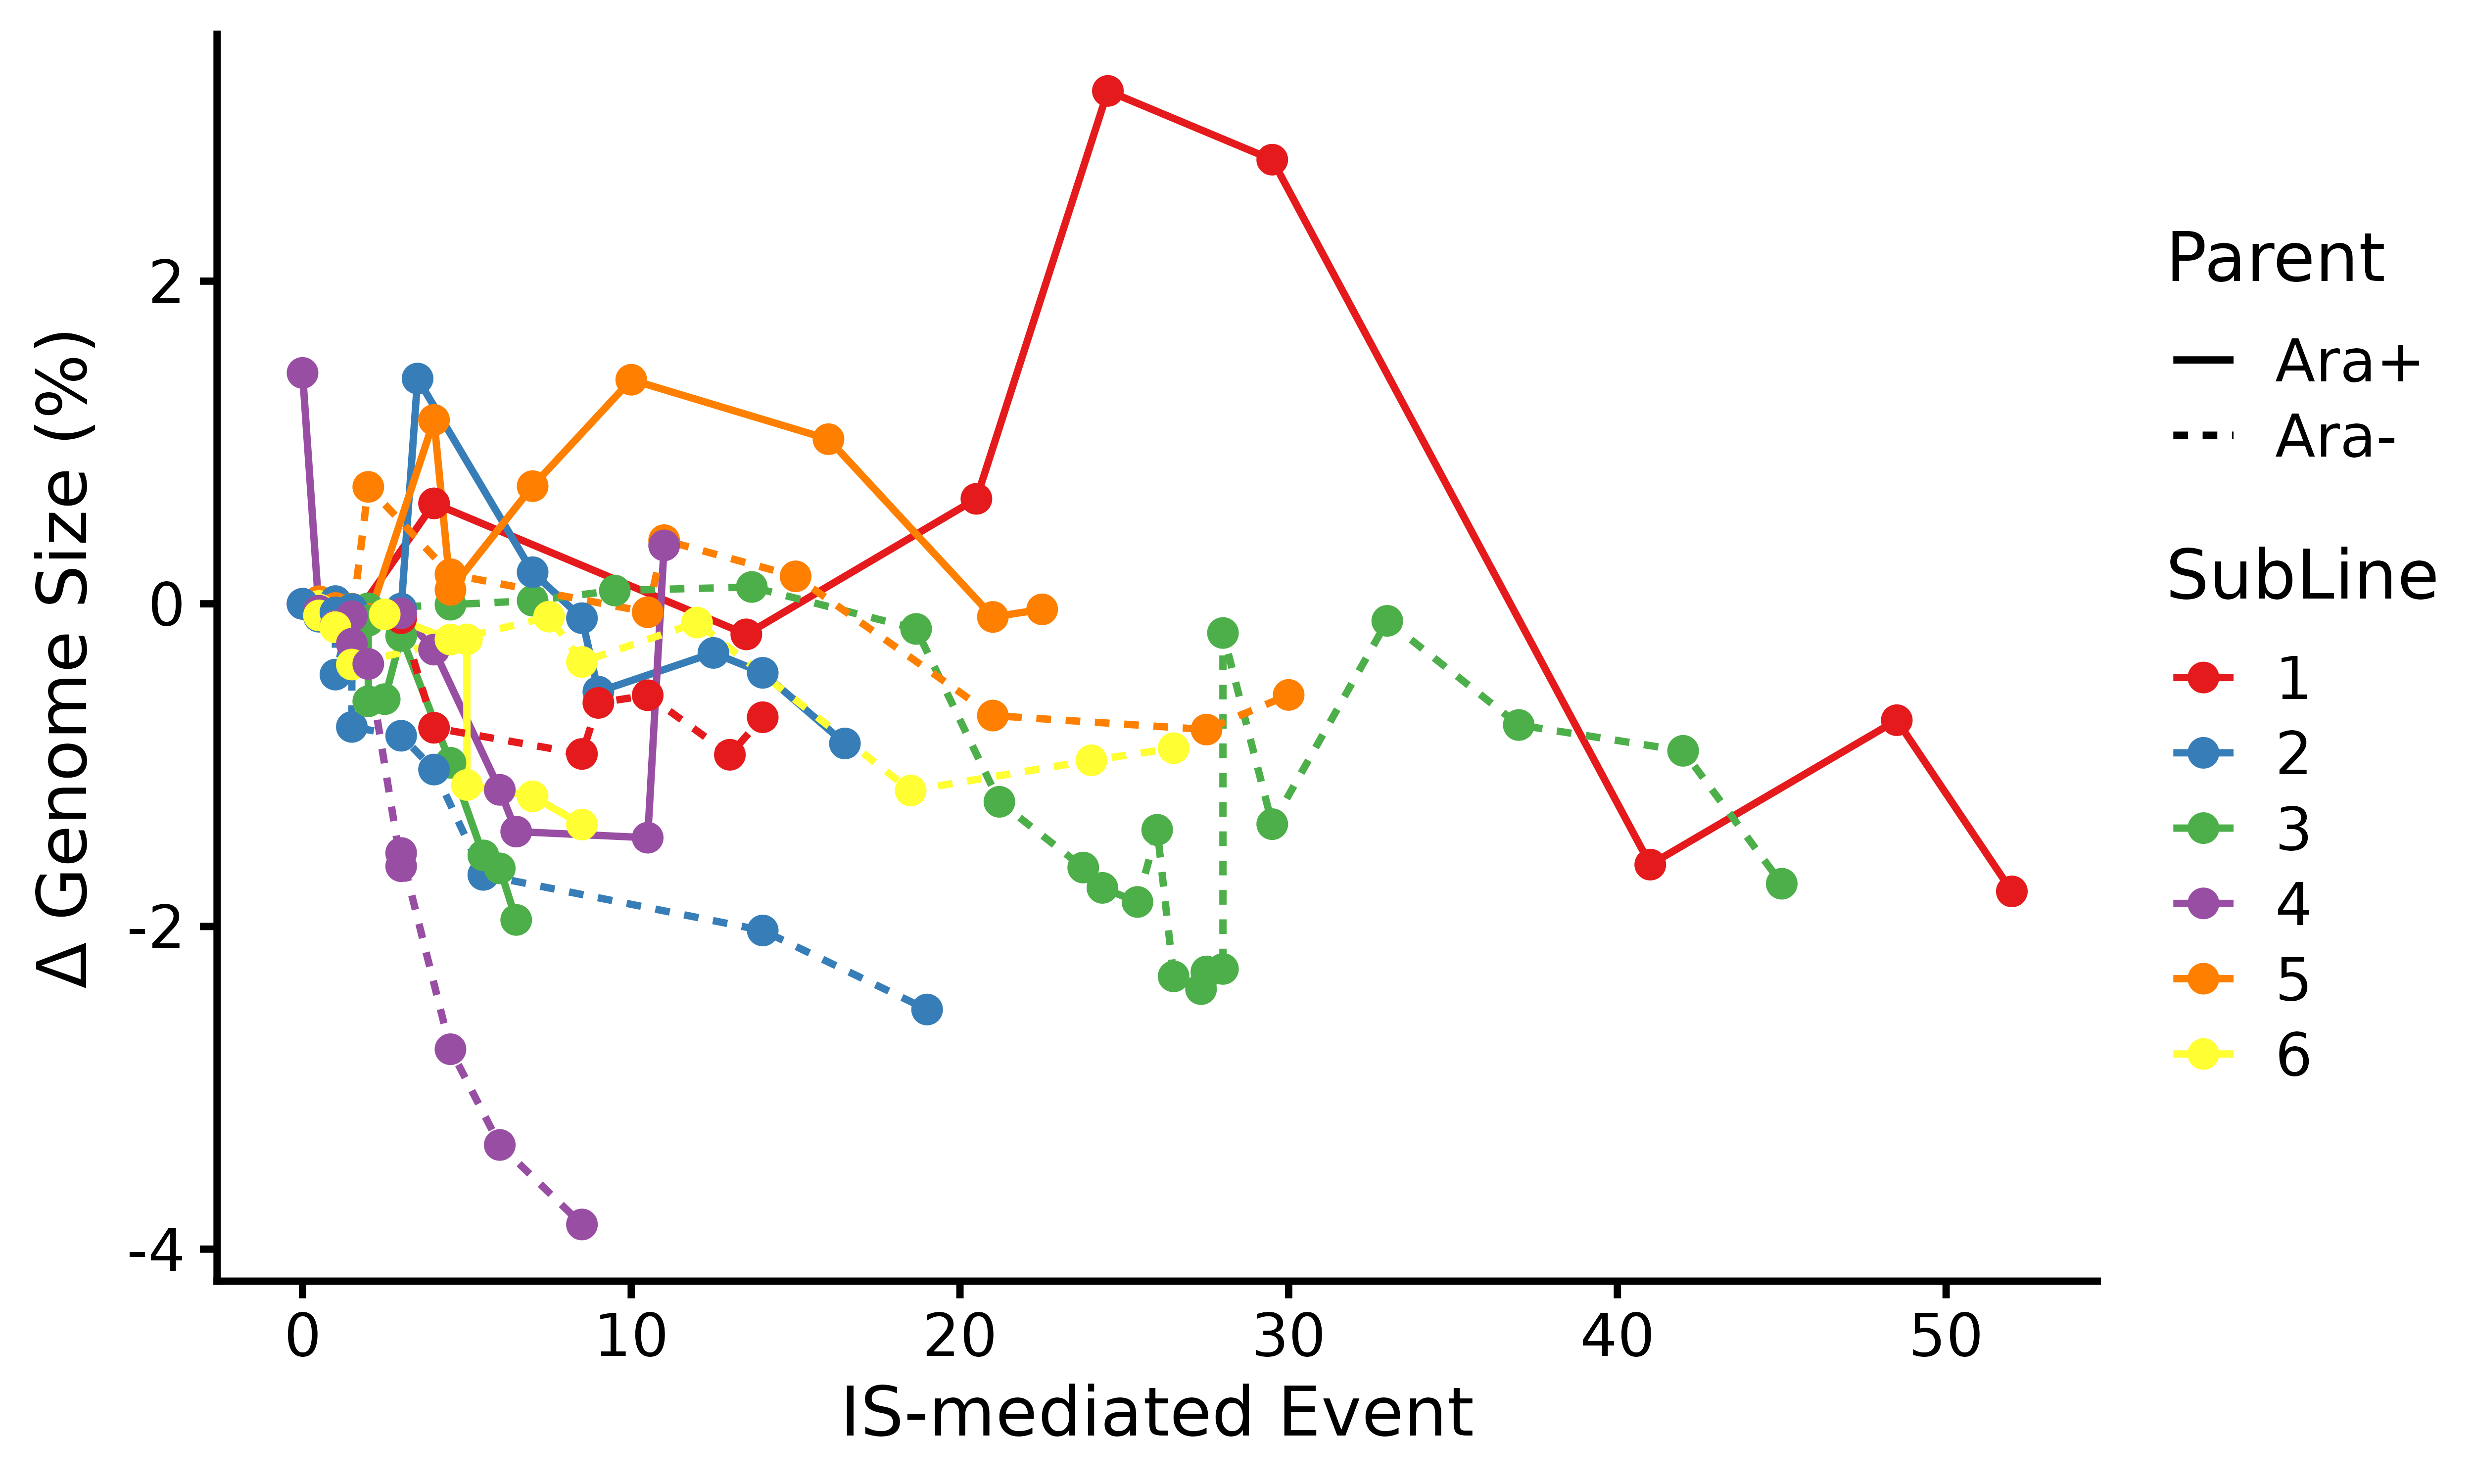

In [57]:
figure_name = file_prefix * "generations_genome_size"
@rput figure_name
R"""
p <-
LTEE.df.group.mean %>%
	#filter(time == 50000) %>%
	mutate(genome_size_change = genome_size.unmasked / 4629812) %>% 
	select(-genome_size) %>%
	mutate(Parent = str_sub(population, start = 1, end = 4), SubLine = str_sub(population, start = 5, end = 6)) %>%
	ggplot(aes(x = is_event, y = (genome_size_change-1)*100, color = SubLine)) +
	geom_line(aes(group = population, linetype = Parent)) +
	labs(x = "IS-mediated Event", y = TeX("$\\Delta$ Genome Size (%)")) +
	geom_point() +
	scale_color_brewer(palette = "Set1") +
	theme_half_open(10)

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=5.0, height=3.0, units="in", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

#### Get IS event per genome sizes per line

To avoid weighing the linear regression too much by those lines with more data points or value changes, I will calculate the IS event per genome size per line and use that for the regression.

In [58]:
#  return a dataframe with summarising for each `population`.
# lm: genome_size_change_rate ~ is_event + 0
R"""
LTEE.df.group.mean.lm <-
LTEE.df.group.mean %>%
	#filter(time == 50000) %>%
	mutate(genome_size_change = genome_size.unmasked / 4629812) %>% 
	select(-genome_size) %>%
	mutate(Parent = str_sub(population, start = 1, end = 4), SubLine = str_sub(population, start = 5, end = 6)) %>%
	mutate(genome_size_change_rate = (genome_size_change - 1)*100) %>%
	group_by(population) %>%
	summarise(isev_vs_gsc_rate = lm(genome_size_change_rate ~ is_event + 0)$coefficients[1],
			isins_vs_gsc_rate = lm(genome_size_change_rate ~ is_ins + 0)$coefficients[1]) 
LTEE.df.group.mean.lm %>% print
LTEE.df.group.mean.lm %>% 
	summarise(isev_vs_gsc_rate.mean = mean(isev_vs_gsc_rate), isins_vs_gsc_rate.mean = mean(isins_vs_gsc_rate),
	isev_vs_gsc_rate.median = median(isev_vs_gsc_rate), isins_vs_gsc_rate.median = median(isins_vs_gsc_rate)) %>%
	pivot_longer(cols = everything(), names_to = "variable", values_to = "value") %>% print 
isev_vs_gsc_rate.median <- LTEE.df.group.mean.lm %>% pull(isev_vs_gsc_rate) %>% median
print("non-mutator")
LTEE.df.group.mean.lm %>% 
	filter(population %in% LTEE.nonmutator) %>%
	summarise(isev_vs_gsc_rate.mean = mean(isev_vs_gsc_rate), isins_vs_gsc_rate.mean = mean(isins_vs_gsc_rate),
	isev_vs_gsc_rate.median = median(isev_vs_gsc_rate), isins_vs_gsc_rate.median = median(isins_vs_gsc_rate)) %>%
	pivot_longer(cols = everything(), names_to = "variable", values_to = "value") %>% print 
isev_vs_gsc_rate.median.nonmut <- LTEE.df.group.mean.lm %>% filter(population %in% LTEE.nonmutator) %>% pull(isev_vs_gsc_rate) %>% median
""";


# A tibble: 12 × 3
   population isev_vs_gsc_rate isins_vs_gsc_rate
   <chr>                 <dbl>             <dbl>
 1 Ara+1              -0.00248          -0.00300
 2 Ara+2              -0.0278           -0.0410 
 3 Ara+3              -0.252            -0.402  
 4 Ara+4              -0.0853           -0.156  
 5 Ara+5               0.0269            0.0370 
 6 Ara+6              -0.141            -0.262  
 7 Ara-1              -0.0686           -0.0860 
 8 Ara-2              -0.151            -0.203  
 9 Ara-3              -0.0458           -0.0552 
10 Ara-4              -0.492            -1.65   
11 Ara-5              -0.0173           -0.0206 
12 Ara-6              -0.0392           -0.0503 
# A tibble: 4 × 2
  variable                   value
  <chr>                      <dbl>
1 isev_vs_gsc_rate.mean    -0.108 
2 isins_vs_gsc_rate.mean   -0.241 
3 isev_vs_gsc_rate.median  -0.0572
4 isins_vs_gsc_rate.median -0.0706
[1] "non-mutator"
# A tibble: 4 × 2
  variable                   va

In [59]:
R"""
LTEE.lm.IS.size.med <- lm(genome_size_change_rate ~ INS + 0, data = genome.size.IS %>% filter(Group == "LTEE") %>%
	mutate(genome_size_change_rate = (genome_size_change - 1)*100))
LTEE.lm.IS.size.med %>% summary %>% print
print(paste("Genome size change", coefficients(LTEE.lm.IS.size.med)[1], "per IS insertion "))
""";


Call:
lm(formula = genome_size_change_rate ~ INS + 0, data = genome.size.IS %>% 
    filter(Group == "LTEE") %>% mutate(genome_size_change_rate = (genome_size_change - 
    1) * 100))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4481 -1.1641  0.0440  0.5242  0.8267 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)  
INS -0.04201    0.01510  -2.782   0.0178 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.382 on 11 degrees of freedom
Multiple R-squared:  0.4131,	Adjusted R-squared:  0.3597 
F-statistic: 7.741 on 1 and 11 DF,  p-value: 0.01783

[1] "Genome size change -0.0420121331908617 per IS insertion "


The value based on per line regression -0.0572 % / 1 IS event and the value using the whole data -0.0420 % / 1 IS event are not so different. I will use the per line regression because it is likely more insensitive to noise.

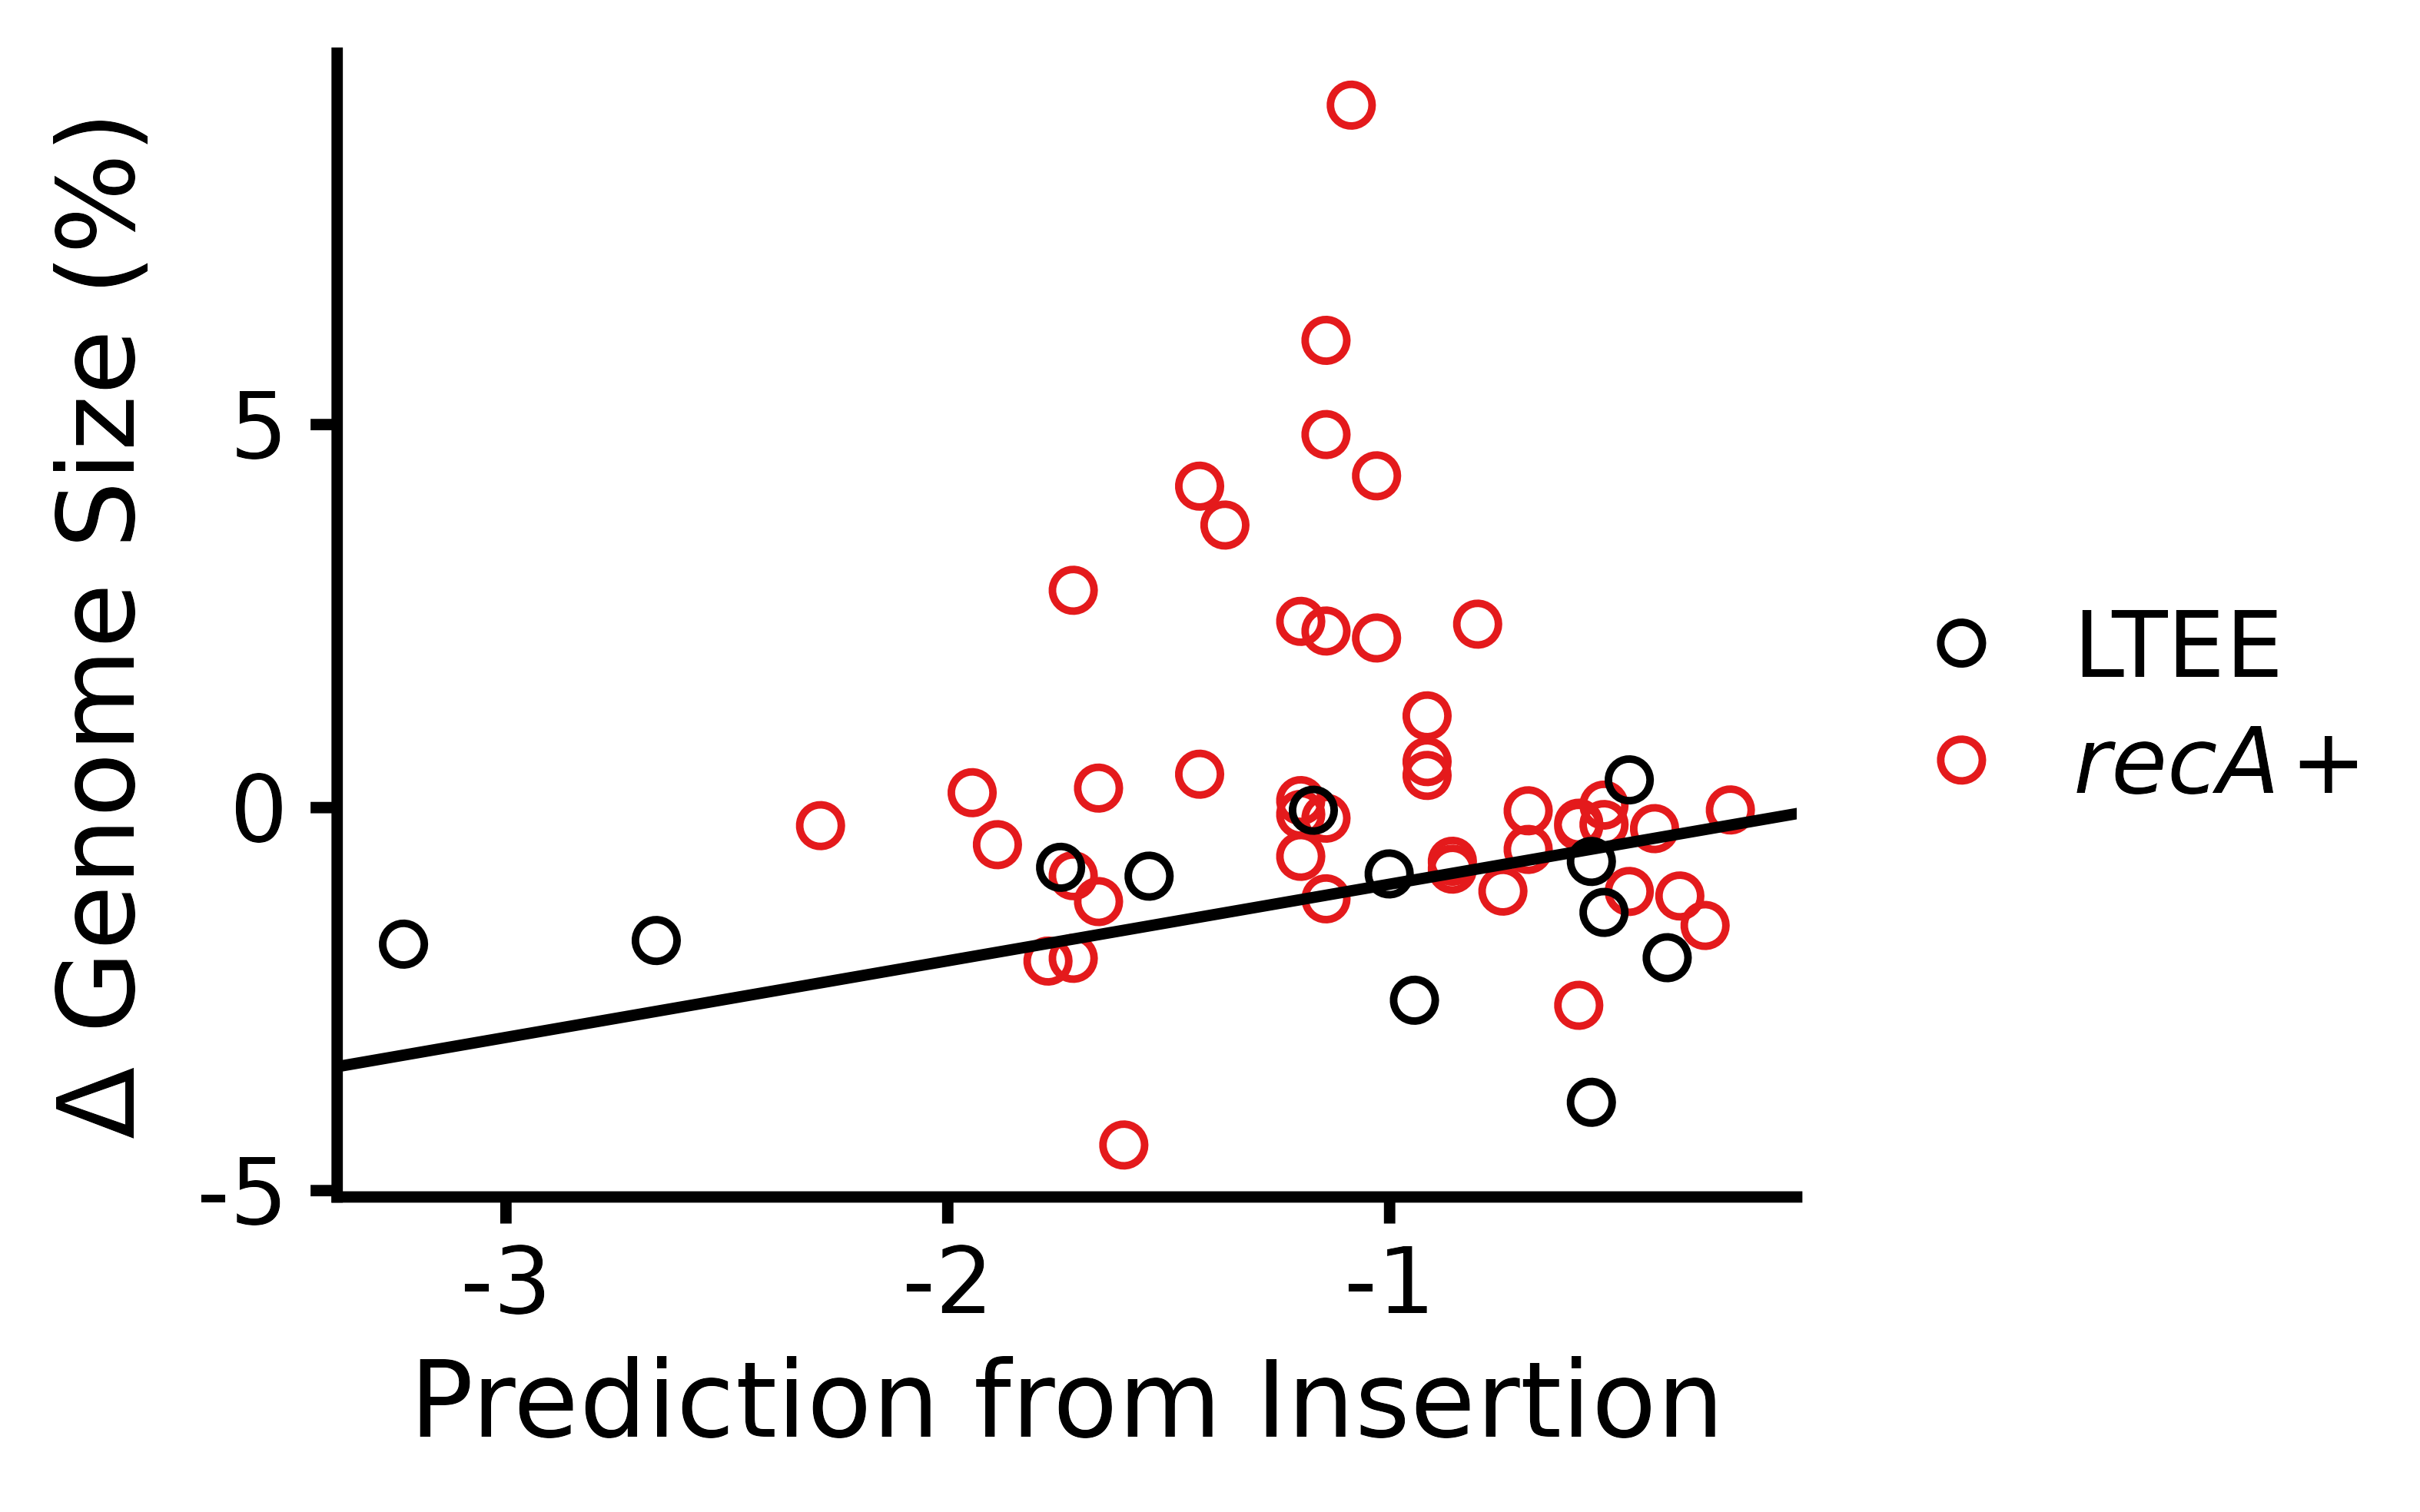

In [60]:
figure_name = file_prefix * "LTEE.IS.genome.change.ISadjust"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic("recA"), "+")))
p <- genome.size.IS %>% 
ggplot(aes(x = (INS * isev_vs_gsc_rate.median), y = 100*(genome_size_change-1), color = Group)) +
geom_point(shape = 1) +
scale_color_manual(values = c("black", "#E41A1C"), labels = labs_, name ="") +
geom_abline(intercept = 0, slope = 1, size = .5) +
labs(x = "Prediction from Insertion", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

It seems that the genome is degraded in generation 50,000 regardless of the IS events in the LTEE.
This might reflect mutator/non-mutator status and the proportion of IS_related mutations.

Let's limit the analysis to non-mutators. Though our experiment also have mutators, the proportion of mutators is likely much smaller than the LTEE.

In [61]:
R"""
genome.size.IS %>% filter(Source == "LTEE") %>% mutate(INS = INS * isev_vs_gsc_rate.median.nonmut) 
"""

RObject{VecSxp}
# A tibble: 12 × 10
# Groups:   time [1]
    time population genome_size Group genome_size_change Source gen_id    INS
   <dbl> <chr>            <dbl> <chr>              <dbl> <chr>   <dbl>  <dbl>
 1 50000 Ara+1         4547279  LTEE               0.982 LTEE       NA -1.27 
 2 50000 Ara+2         4589733  LTEE               0.991 LTEE       NA -0.394
 3 50000 Ara+3         4539094  LTEE               0.980 LTEE       NA -0.146
 4 50000 Ara+4         4646574  LTEE               1.00  LTEE       NA -0.180
 5 50000 Ara+5         4628214. LTEE               1.00  LTEE       NA -0.462
 6 50000 Ara+6         4566470. LTEE               0.986 LTEE       NA -0.203
 7 50000 Ara-1         4597260  LTEE               0.993 LTEE       NA -0.214
 8 50000 Ara-2         4513385  LTEE               0.975 LTEE       NA -0.372
 9 50000 Ara-3         4549482. LTEE               0.983 LTEE       NA -1.05 
10 50000 Ara-4         4451694  LTEE               0.962 LTEE       NA -0.214
11 5000

┌ Warning: RCall.jl: Warning: The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
│ of ggplot2 3.3.4.
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


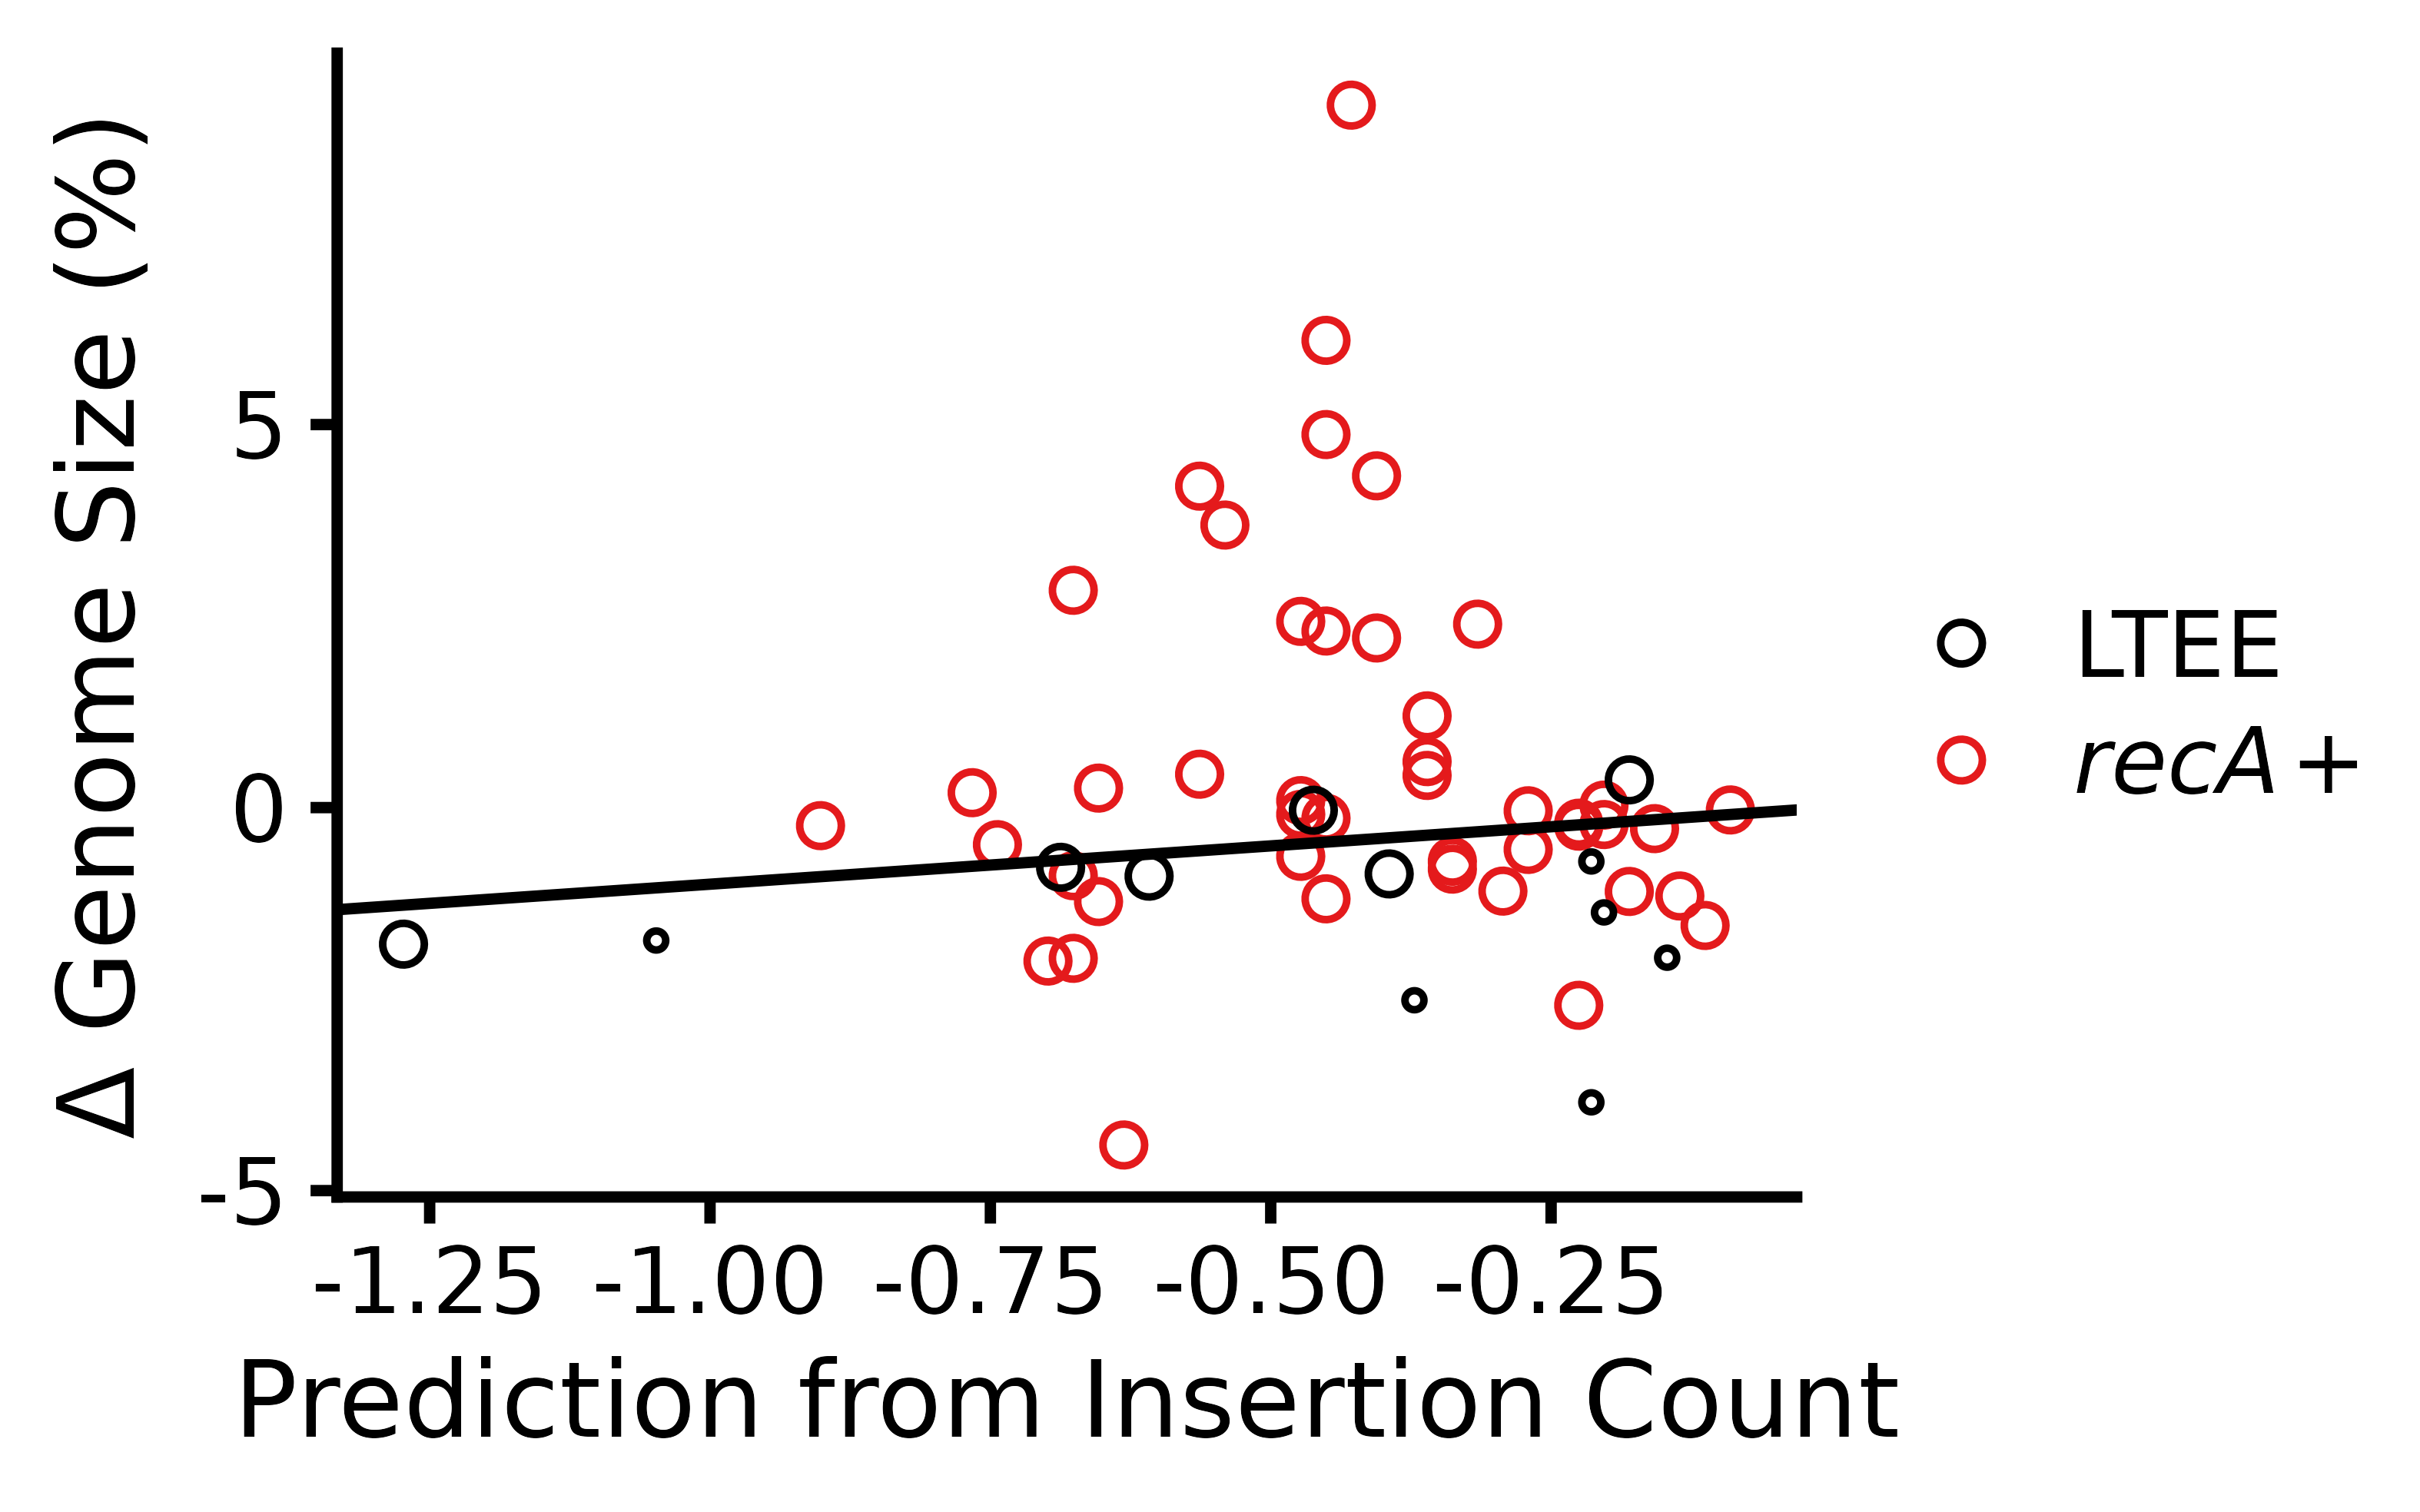

In [62]:
figure_name = file_prefix * "LTEE.IS.genome.change.ISadjust.nonmut"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic("recA"), "+")))
p <- genome.size.IS %>% 
mutate(invalid = ifelse(Source == "LTEE" & !population %in% LTEE.nonmutator, .25, .5)) %>%
ggplot(aes(x = (INS * isev_vs_gsc_rate.median.nonmut), y = 100*(genome_size_change-1), color = Group)) +
#geom_point(shape = 1) +
geom_point(aes(size = invalid), shape = 1) +
scale_size_continuous(range = c(.5, 1.5)) +
scale_color_manual(values = c("black", "#E41A1C"), labels = labs_, name ="") +
geom_abline(intercept = 0, slope = 1, size = .5) +
# remove legend of invalid
guides(size=FALSE) +
labs(x = "Prediction from Insertion Count", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

# Analysis with adjusted genome sizes
The above analysis uses  raw genome sizes.
Here, I adjust by reducing IS size to WT and adjust for non-esssential sequence ratio between MDS42 and REL606.

## Adjust genome sizes

In [63]:
R"""
original.is.length <- 3091
wt.is.length <- 768
genome_stats_df %>% filter(SubLine == 1, gen == "FACS") %>% 
	select(ParentLine, genome_size, is_cnt, is_length)
"""

RObject{VecSxp}
# A tibble: 11 × 4
   ParentLine genome_size is_cnt is_length
        <dbl>       <dbl>  <dbl>     <dbl>
 1          1     4003851     10     38786
 2          2     4026846     15     49493
 3          3     3945915      9     29913
 4          4     3992834     14     43300
 5          5     3947151     10     30921
 6          6     3978605     10     30927
 7          7     3985195     14     43297
 8          8     4001201     15     46391
 9          9     3989727     12     42098
10         10     3982402     10     34034
11         11     4004368     12     37124


In [64]:
## REF:ADJUST-GENOME-SIZE
R"""
ess.gene.length <- 308314 # from 20240301_Compare_INS_freq_per_NonESS_LTEE
REL606.genome.size <- 4629812

genome.size.IS.adjusted <- 
genome.size.IS %>%
left_join(genome_stats_df %>% select(population = Prefix, gen_id, IS_CNT = is_cnt)) %>% data.frame %>%
	filter() %>% select(-c(Source, gen_id, time, Group)) %>%
	left_join(genome_content_plot_dat %>% filter(gen_id == 3) %>% select(population = Prefix, is_length, Deletion, Duplication)) %>%
	left_join(genome_stats_df %>% filter(gen_id == 1) %>% select(population = Prefix, genome_size.anc = genome_size, is_length.anc = is_length, IS_CNT.anc = is_cnt)) %>%
	mutate(d_is_length = is_length - is_length.anc, d_genome_size = genome_size - genome_size.anc) %>%
	mutate(d_is_length.adjusted = (IS_CNT - IS_CNT.anc) * wt.is.length,
		Deletion.adjusted = Deletion * (REL606.genome.size - ess.gene.length) / (genome_size.anc - ess.gene.length) * genome_size.anc/REL606.genome.size,
	) %>%
	mutate(d_genome_size.adjusted = d_genome_size + (d_is_length.adjusted - (is_length - is_length.anc)) - (Deletion.adjusted - Deletion)) %>%
	mutate(genome_size_change.adjusted = d_genome_size.adjusted / genome_size.anc * 100) 

genome.size.IS.adjusted %>% head %>% print
print(paste("Median adjusted genome size change:", median(genome.size.IS.adjusted %>% filter(RecA == "recA+") %>% pull(d_genome_size.adjusted)),
	"(recA+)", median(genome.size.IS.adjusted %>% filter(RecA == "recA-") %>% pull(d_genome_size.adjusted)), "(recA-)"))
print(paste("Mean adjusted genome size change:", mean(genome.size.IS.adjusted %>% filter(RecA == "recA+") %>% pull(d_genome_size.adjusted)),
	"(recA+)", mean(genome.size.IS.adjusted %>% filter(RecA == "recA-") %>% pull(d_genome_size.adjusted)), "(recA-)"))
print(paste("Median adjusted genome size change rate:", median(genome.size.IS.adjusted %>% filter(RecA == "recA+") %>% pull(genome_size_change.adjusted)),
	"(recA+)", median(genome.size.IS.adjusted %>% filter(RecA == "recA-") %>% pull(genome_size_change.adjusted)), "(recA-)"))
print(paste("Mean adjusted genome size change rate:", mean(genome.size.IS.adjusted %>% filter(RecA == "recA+") %>% pull(genome_size_change.adjusted)),
	"(recA+)", mean(genome.size.IS.adjusted %>% filter(RecA == "recA-") %>% pull(genome_size_change.adjusted)), "(recA-)"))

genome.size.IS.adjusted <- 
genome.size.IS.adjusted %>% rename(Source = RecA) %>% mutate(Source = ifelse(is.na(Source), "LTEE", Source))  %>%
	mutate(genome_size_change.adjusted = ifelse(Source == "LTEE", 100*(genome_size_change - 1), genome_size_change.adjusted))
""";

  population genome_size genome_size_change INS LTEE.gen  RecA IS_CNT is_length
1      L01-1     3923637          0.9799658  31 64487.95 recA+     30    102740
2      L01-2     3978375          0.9936371  21 43685.39 recA+     21     71226
3      L01-3     3954732          0.9877321  29 60327.44 recA+     23     75841
4      L01-4     4007510          1.0009139  21 43685.39 recA+     24     82047
5      L02-1     4175370          1.0368835  24 49926.16 recA+     31    106466
6      L02-2     4396104          1.0916991  19 39524.87 recA+     29     91573
  Deletion Duplication genome_size.anc is_length.anc IS_CNT.anc d_is_length
1   144160           0         4003851         38786         10       63954
2    62765        4779         4003851         38786         10       32440
3    86184           0         4003851         38786         10       37055
4    39645           0         4003851         38786         10       43261
5   148455      240167         4026846         49493        

┌ Warning: RCall.jl: Joining with `by = join_by(population, gen_id)`
│ Joining with `by = join_by(population)`
│ Joining with `by = join_by(population)`
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


### FIG: Genome size changes before adjustment 

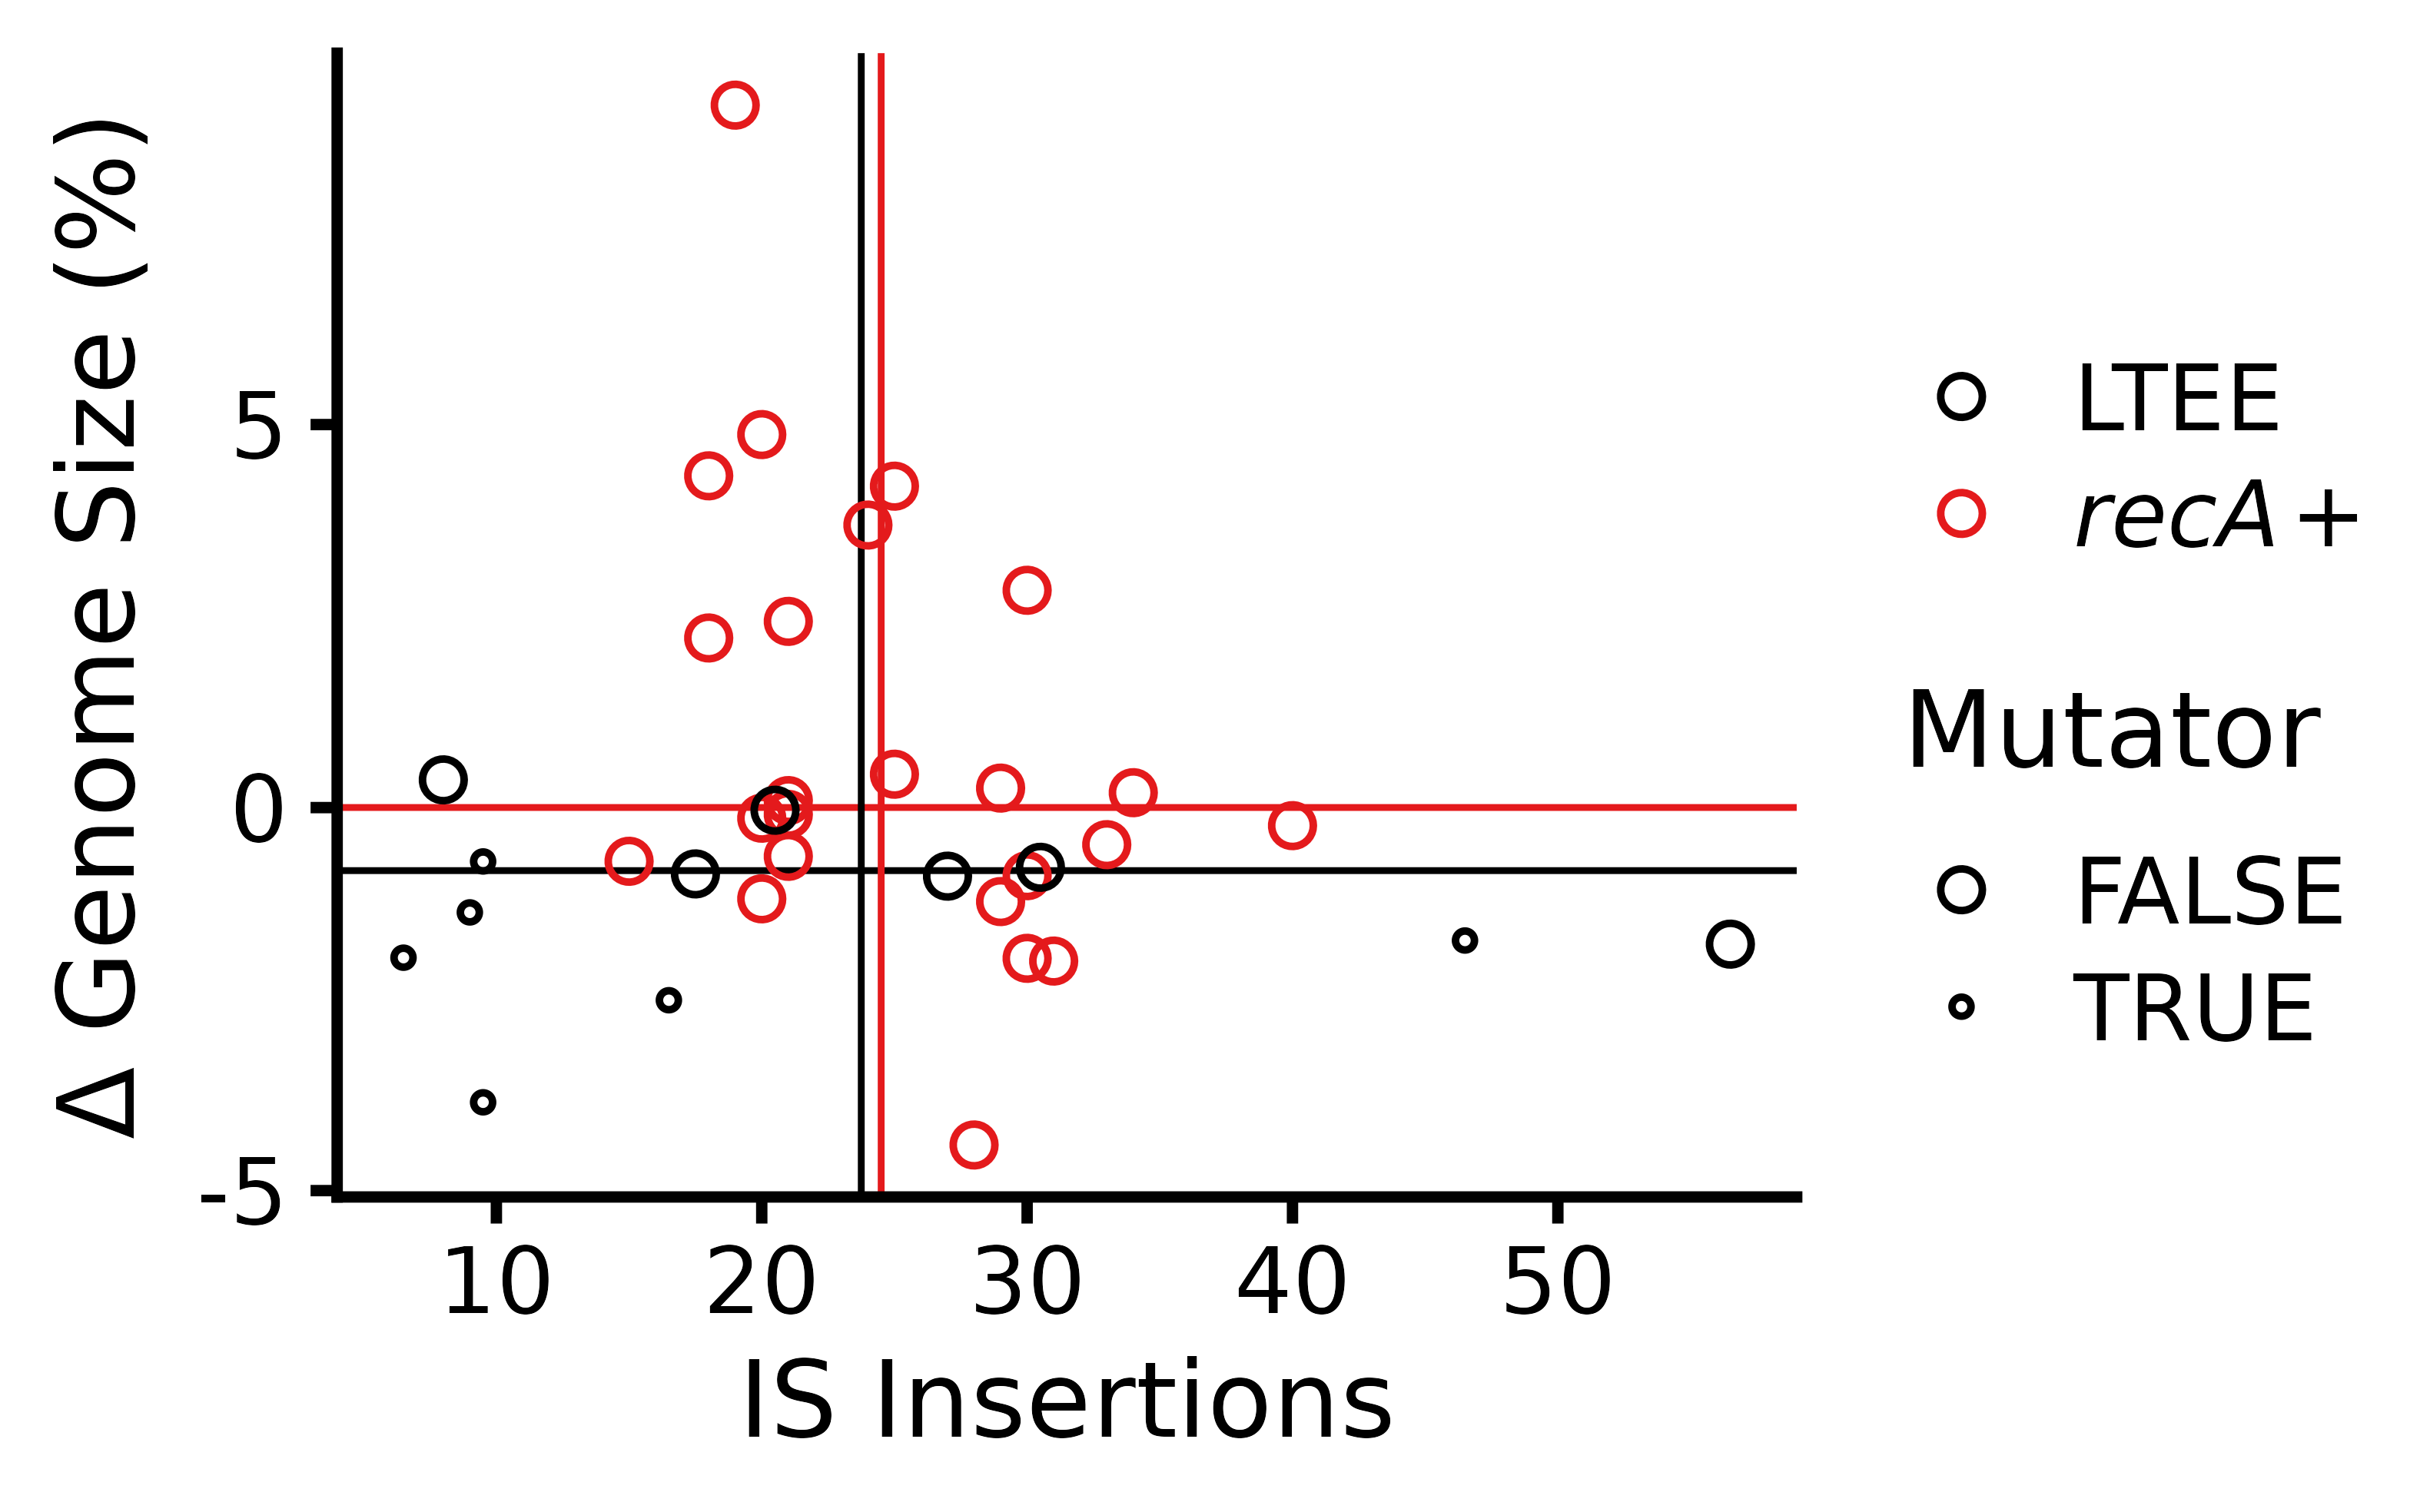

In [65]:
figure_name = file_prefix * "LTEE.IS.genome.change.med.recAP"
@rput figure_name
R"""
#LTEE.IS.med <- genome.size.IS %>% filter(Group == "LTEE") %>% pull(INS) %>% median
LTEE.IS.med <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator) %>% pull(INS) %>% median
recAP.IS.med <- genome.size.IS %>% filter(Source == "RecA") %>% pull(INS) %>% median
#recAm.IS.med <- genome.size.IS %>% filter(Source == "recA") %>% pull(INS) %>% median
#LTEE.gc.med <- genome.size.IS %>% filter(Group == "LTEE") %>% pull(genome_size_change) %>% median
LTEE.gc.med <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator) %>%
	mutate(genome_size_change = 100 * (genome_size_change - 1)) %>% pull(genome_size_change) %>% median
recAP.gc.med <- genome.size.IS %>% filter(Source == "RecA") %>% 
	mutate(genome_size_change = 100 * (genome_size_change - 1)) %>% pull(genome_size_change) %>% median
#recAm.gc.med <- genome.size.IS %>% filter(Source == "recA") %>% pull(genome_size_change) %>% median

p <- genome.size.IS %>% 
filter(Source != "recA") %>%
mutate(invalid = ifelse(Source == "LTEE" & !population %in% LTEE.nonmutator, T, F)) %>%
ggplot(aes(x = INS, y = 100*(genome_size_change - 1), color = Source)) +
geom_hline(yintercept = recAP.gc.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_hline(yintercept = LTEE.gc.med, linetype = "solid", color = "black", size=.3) +
#geom_hline(yintercept = recAm.gc.med, linetype = "solid", color = "#377EB8", size=.3) +
geom_vline(xintercept = recAP.IS.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_vline(xintercept = LTEE.IS.med, linetype = "solid", color = "black", size=.3) +
#geom_vline(xintercept = recAm.IS.med, linetype = "solid", color = "#377EB8", size=.3) +
#geom_point(shape = 1) +
geom_point(aes(size = invalid), shape = 1) +
scale_size_manual(values = c(1.5, 0.5), name = "Mutator") +
scale_color_manual(values = c("black", "#E41A1C", "#377EB8"), labels = labs_, name ="") +
labs(x = "IS Insertions", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size.med <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

### STAT: Bootstrap CI (this study)

In [86]:
# genome size change of recA+
R""" 
calculate_statistic <- function(data, indices) {
  sample <- data[indices, ]  # Resample the data
  return(c(mean = (mean(sample$genome_size_change.adjusted) ),
           median = (median(sample$genome_size_change.adjusted) )))
}

## CHANGE DATASET
filtered_data <- genome.size.IS.adjusted %>%
  filter(Source == "recA+")

print(median(filtered_data$genome_size_change.adjusted))

# Perform the bootstrap
set.seed(123)  # For reproducibility
bootstrap_results <- boot(data = filtered_data, statistic = calculate_statistic, R = 1000)

# Calculate 95% confidence intervals for both mean and median
print("MEAN")
boot.ci(bootstrap_results, type = "bca", index = 1) %>% print  # For mean
print("MEDIAN")
boot.ci(bootstrap_results, type = "all", index = 2) %>% print # For median used in main text
""";

[1] -0.9565569
[1] "MEAN"
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_results, type = "bca", index = 1)

Intervals : 
Level       BCa          
95%   (-1.0262,  1.2781 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable
[1] "MEDIAN"
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_results, type = "all", index = 2)

Intervals : 
Level      Normal              Basic         
95%   (-2.0810, -0.0120 )   (-3.1404, -0.2374 )  

Level     Percentile            BCa          
95%   (-1.6757,  1.2272 )   (-1.6757,  1.2272 )  
Calculations and Intervals on Original Scale


┌ Warning: RCall.jl: Warning in boot.ci(bootstrap_results, type = "all", index = 2) :
│   bootstrap variances needed for studentized intervals
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


In [67]:
R"""
median(genome.size.IS.adjusted %>% filter(Source == "recA+") %>% pull(d_genome_size.adjusted))
"""

RObject{RealSxp}
[1] -37914.33


┌ Warning: RCall.jl: Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for Unicode character U+2212
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

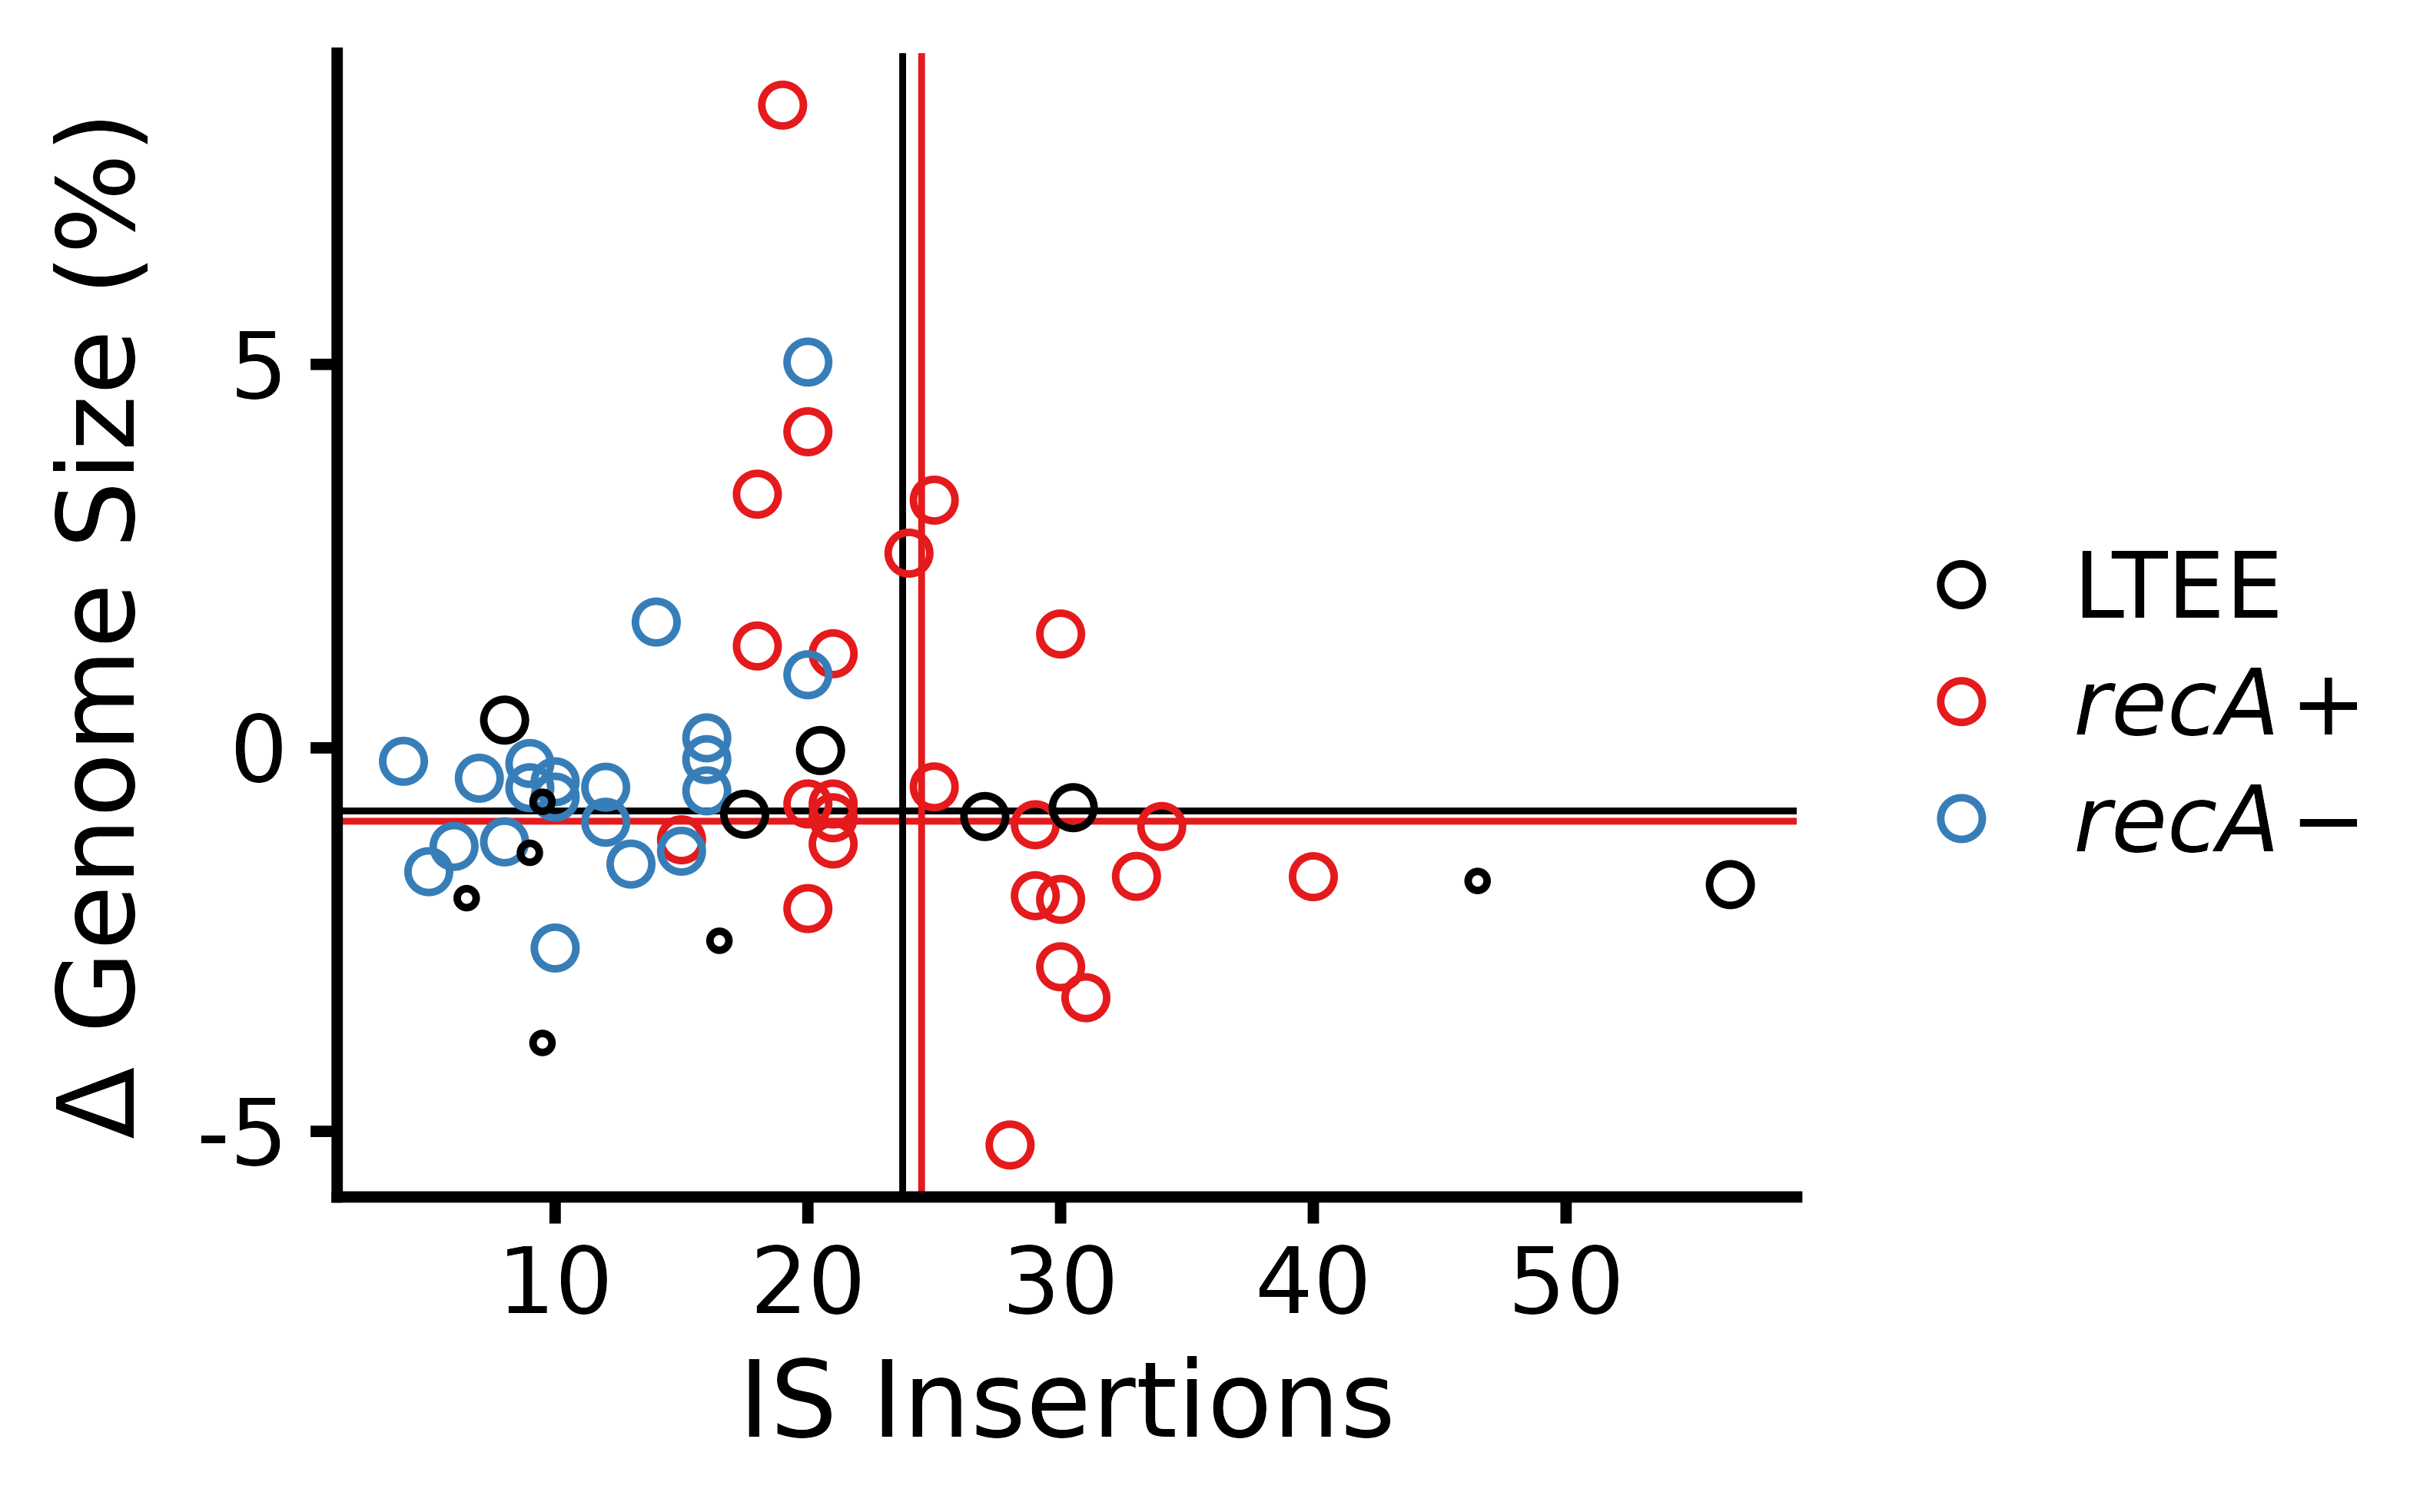

In [68]:
figure_name = file_prefix * "LTEE.IS.genome.change.med.ISadjust.NEssAdjust"
@rput figure_name
R"""
LTEE.IS.med <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator) %>% pull(INS) %>% median
recAP.IS.med <- genome.size.IS.adjusted %>% filter(Source == "recA+") %>% pull(INS) %>% median
#recAm.IS.med <- genome.size.IS.adjusted %>% filter(Source == "recA") %>% pull(INS) %>% median
LTEE.gc.med <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator) %>% pull(genome_size_change.adjusted) %>% median
recAP.gc.med <- genome.size.IS.adjusted %>% filter(Source == "recA+") %>% pull(genome_size_change.adjusted) %>% median
#recAm.gc.med <- genome.size.IS.adjusted %>% filter(Source == "recA") %>% pull(genome_size_change) %>% median

labs_ <- c("LTEE", expression(paste(italic("recA"), "+")), expression(paste(italic("recA"), "\u2212")))

p <- genome.size.IS.adjusted %>% 
filter(Source != "recA") %>%
mutate(invalid = ifelse(Source == "LTEE" & !population %in% LTEE.nonmutator, .25, .5) %>% as.factor) %>%
ggplot(aes(x = INS, y = genome_size_change.adjusted, color = Source)) +
geom_hline(yintercept = recAP.gc.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_hline(yintercept = LTEE.gc.med, linetype = "solid", color = "black", size=.3) +
#geom_hline(yintercept = recAm.gc.med, linetype = "solid", color = "#377EB8", size=.3) +
geom_vline(xintercept = recAP.IS.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_vline(xintercept = LTEE.IS.med, linetype = "solid", color = "black", size=.3) +
#geom_vline(xintercept = recAm.IS.med, linetype = "solid", color = "#377EB8", size=.3) +
geom_point(aes(size = invalid), shape = 1) +
#scale_size_continuous(range = c(.5, 1.5)) +
scale_size_manual(values = c(0.5, 1.5), guide = "none") +
scale_color_manual(values = c("black", "#E41A1C", "#377EB8"), labels = labs_, name ="") +
labs(x = "IS Insertions", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size.med <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

### FIG: IS insertion vs adj. gen. size

┌ Warning: RCall.jl: Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   font metrics unknown for character 0xa
│ Warning in grid.Cal

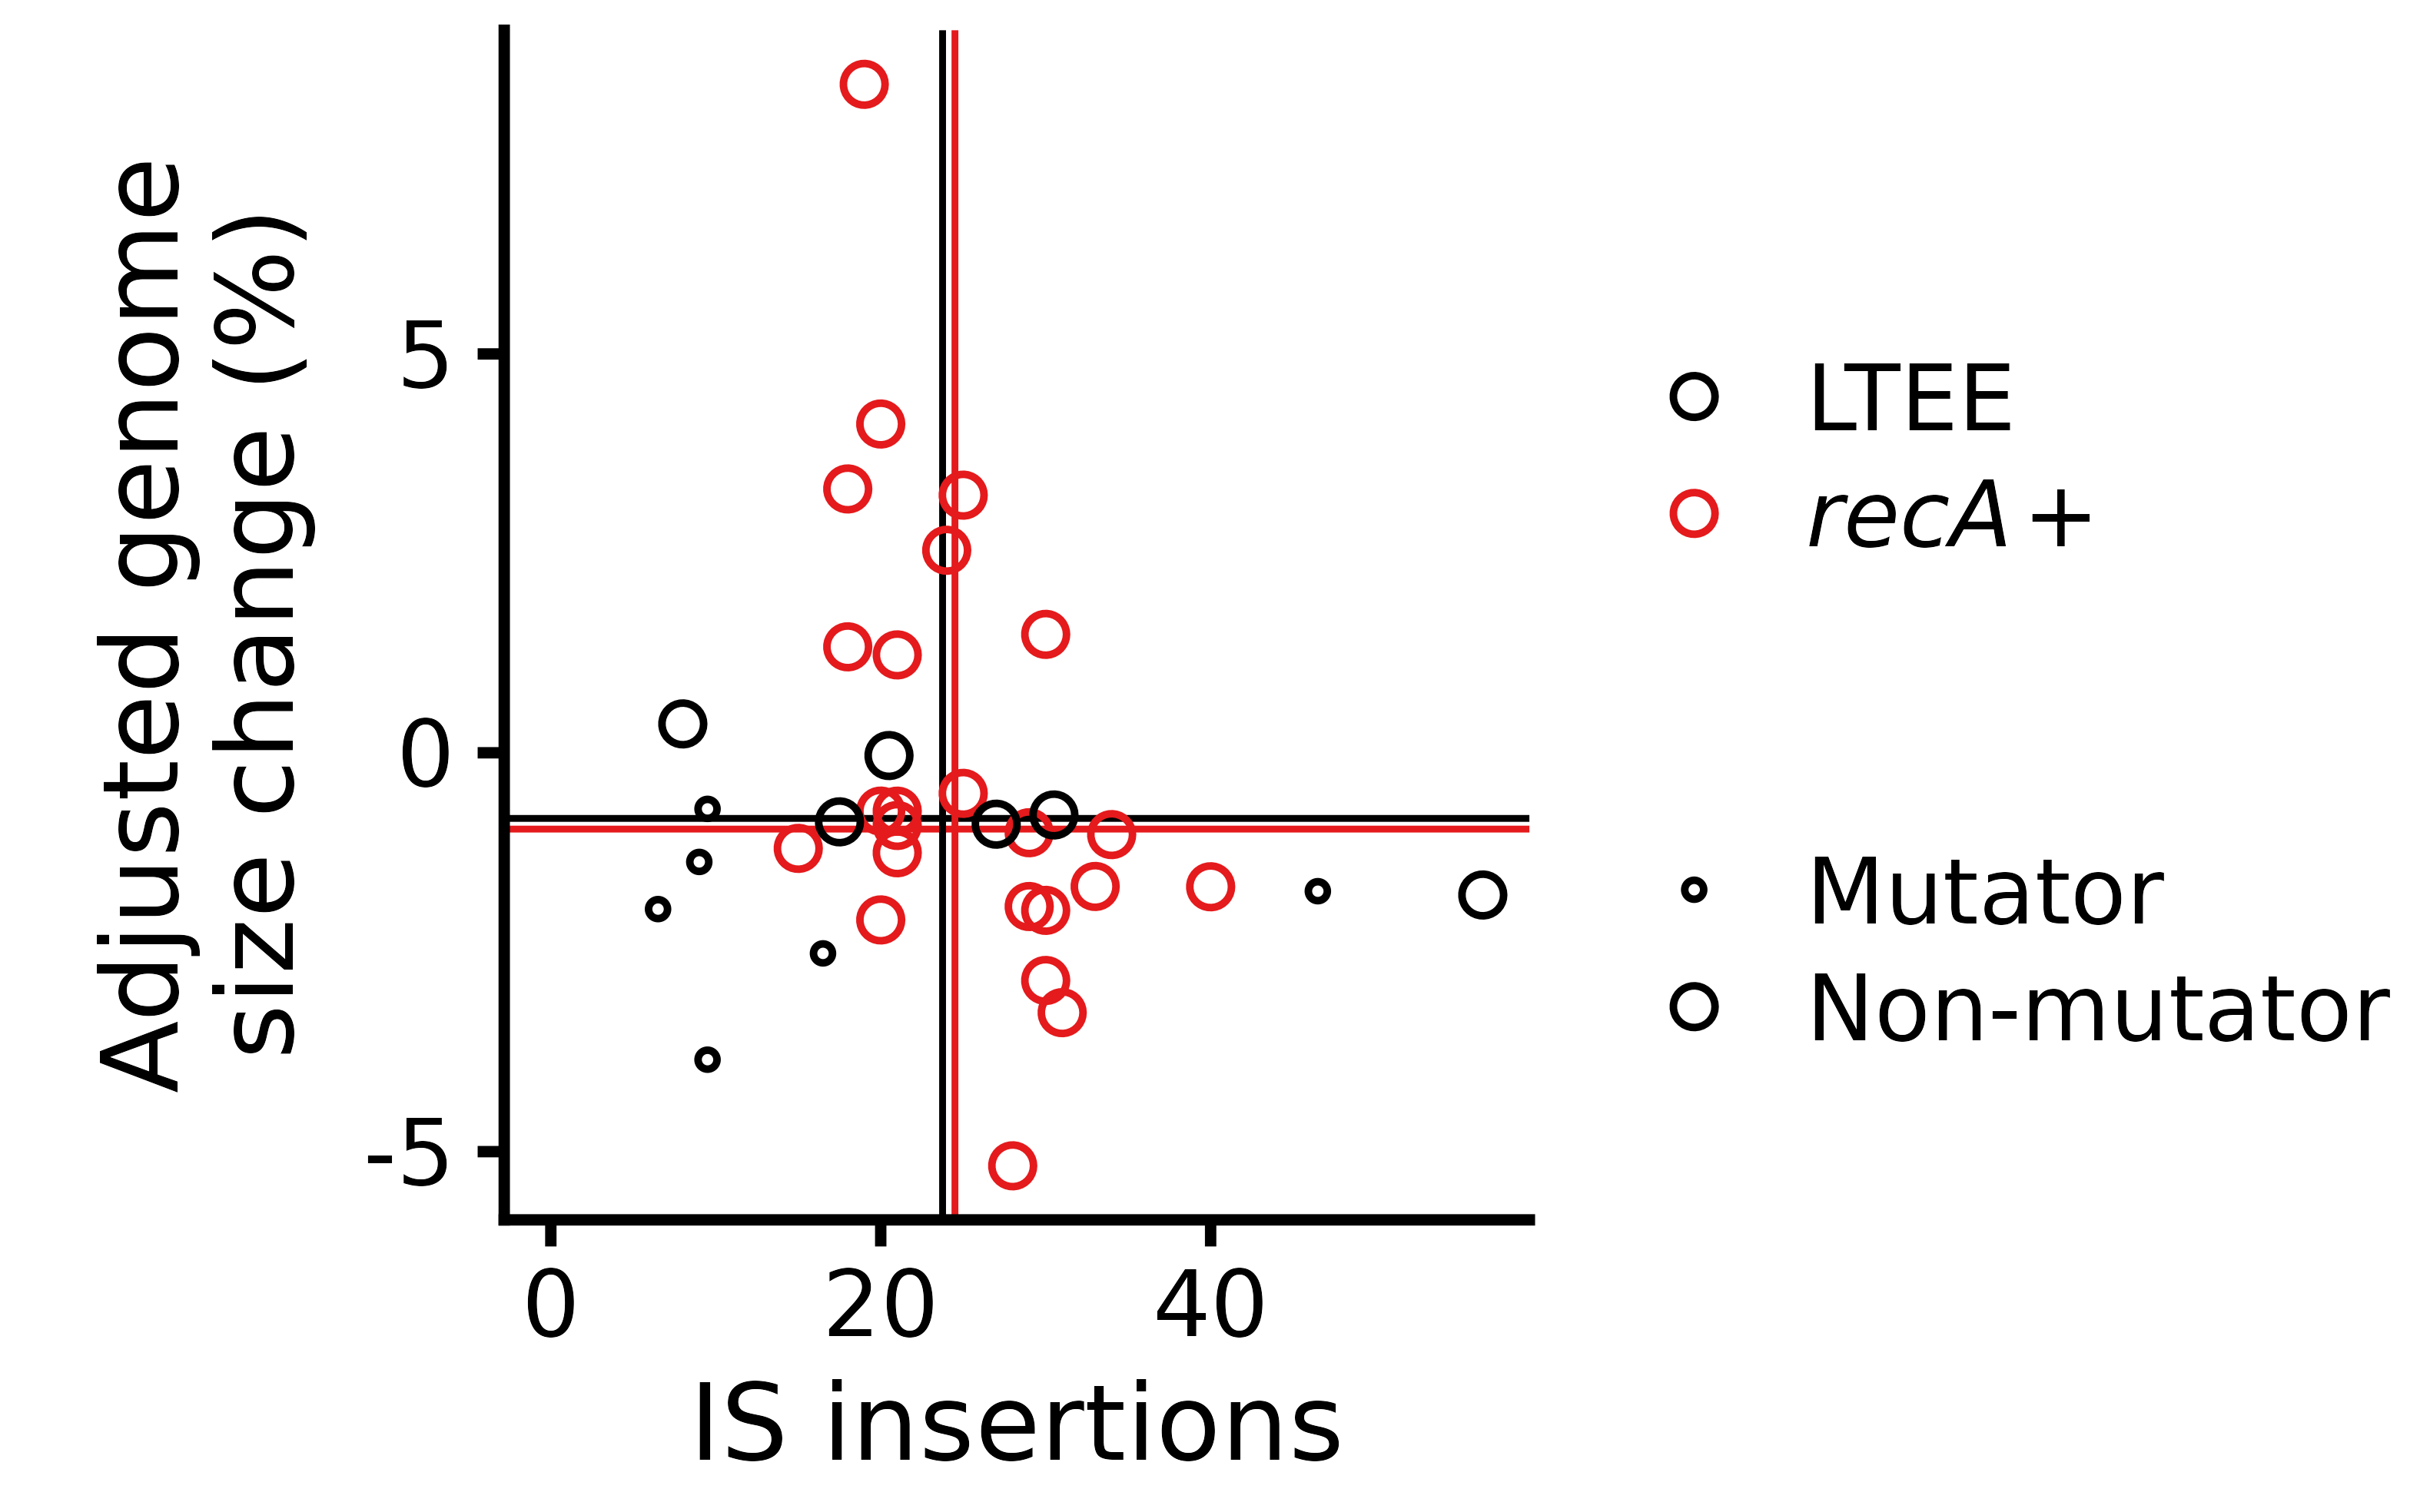

In [69]:
figure_name = file_prefix * "LTEE.IS.genome.change.med.recAP.ISadjust.NEssAdjust"
@rput figure_name
R"""
LTEE.IS.med <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator) %>% pull(INS) %>% median
recAP.IS.med <- genome.size.IS.adjusted %>% filter(Source == "recA+") %>% pull(INS) %>% median
#recAm.IS.med <- genome.size.IS.adjusted %>% filter(Source == "recA") %>% pull(INS) %>% median
LTEE.gc.med <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator) %>% pull(genome_size_change.adjusted) %>% median
recAP.gc.med <- genome.size.IS.adjusted %>% filter(Source == "recA+") %>% pull(genome_size_change.adjusted) %>% median
#recAm.gc.med <- genome.size.IS.adjusted %>% filter(Source == "recA") %>% pull(genome_size_change) %>% median

p <- genome.size.IS.adjusted %>% 
filter(Source != "recA-") %>%
mutate(invalid = ifelse(Source == "LTEE" & !population %in% LTEE.nonmutator, "Mutator", "Non-mutator")) %>%
ggplot(aes(x = INS, y = genome_size_change.adjusted, color = Source)) +
geom_hline(yintercept = recAP.gc.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_hline(yintercept = LTEE.gc.med, linetype = "solid", color = "black", size=.3) +
#geom_hline(yintercept = recAm.gc.med, linetype = "solid", color = "#377EB8", size=.3) +
geom_vline(xintercept = recAP.IS.med, linetype = "solid", color = "#E41A1C", size=.3) +
geom_vline(xintercept = LTEE.IS.med, linetype = "solid", color = "black", size=.3) +
#geom_vline(xintercept = recAm.IS.med, linetype = "solid", color = "#377EB8", size=.3) +
geom_point(aes(size = invalid), shape = 1) +
#scale_size_continuous(range = c(.5, 1.5)) +
#scale_size_manual(values = c(1.5, 0.5), name = "") +
scale_size_manual(values = c(0.5, 1.5), name = "") +
scale_color_manual(values = c("black", "#E41A1C", "#377EB8"), labels = labs_, name ="") +
labs(x = "IS insertions", y = TeX("Adjusted genome\n size change (%)"))+
theme_half_open(10) +
xlim(0, NA) +
theme(legend.text.align = 0, plot.margin=unit(c(.1,0.1,0.1,.7),"cm"))

p.ISINS.genome.size.med <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

#### STAT: medians 

In [85]:
R"""
print("LTEE.IS.med, recAP.IS.med, LTEE.gc.med, recAP.gc.med")
c(LTEE.IS.med, recAP.IS.med, LTEE.gc.med, recAP.gc.med)
"""

[1] "LTEE.IS.med, recAP.IS.med, LTEE.gc.med, recAP.gc.med"


RObject{RealSxp}
[1] 23.7500000 24.5000000 -0.8225820 -0.9565569


#### STAT: cor

In [71]:
R"""
print("recA+")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "recA+")
cor.test(tmp_$INS, tmp_$genome_size_change.adjusted) %>% print
summary(lm(genome_size_change.adjusted ~ INS, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))

print("recA-")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "recA-")
cor.test(tmp_$INS, tmp_$genome_size_change.adjusted) %>% print
summary(lm(genome_size_change.adjusted ~ INS, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))

print("LTEE non-mutator")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator)
cor.test(tmp_$INS, tmp_$genome_size_change.adjusted) %>% print
summary(lm(genome_size_change.adjusted ~ INS, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))

print("LTEE mutator")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "LTEE", !(population %in% LTEE.nonmutator))
cor.test(tmp_$INS, tmp_$genome_size_change.adjusted) %>% print
summary(lm(genome_size_change.adjusted ~ INS, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))
""";

[1] "recA+"

	Pearson's product-moment correlation

data:  tmp_$INS and tmp_$genome_size_change.adjusted
t = -2.3357, df = 22, p-value = 0.02902
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.71973723 -0.05165515
sample estimates:
       cor 
-0.4457633 


Call:
lm(formula = genome_size_change.adjusted ~ INS, data = tmp_)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4783 -1.6937 -0.2617  1.6033  7.2282 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  5.05917    2.27315   2.226   0.0366 *
INS         -0.20566    0.08805  -2.336   0.0290 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.635 on 22 degrees of freedom
Multiple R-squared:  0.1987,	Adjusted R-squared:  0.1623 
F-statistic: 5.456 on 1 and 22 DF,  p-value: 0.02902

[1] "n= 24"
[1] "recA-"

	Pearson's product-moment correlation

data:  tmp_$INS and tmp_$genome_size_change.adjusted
t = 2.9103, d

## STAT: lm + 0
While the analysis takes the correlation The zero insertion intecept is huge, which is unnnatural.
Here I take regression without intercept.

In [72]:
R"""
print("recA+")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "recA+")
summary(lm(genome_size_change.adjusted ~ INS +0, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))

print("recA-")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "recA-")
summary(lm(genome_size_change.adjusted ~ INS +0, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))

print("LTEE non-mutator")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "LTEE", population %in% LTEE.nonmutator)
summary(lm(genome_size_change.adjusted ~ INS +0, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))

print("LTEE mutator")
tmp_ <- genome.size.IS.adjusted %>% filter(Source == "LTEE", !(population %in% LTEE.nonmutator))
summary(lm(genome_size_change.adjusted ~ INS +0, data = tmp_)) %>% print
print(paste("n=", nrow(tmp_)))
""";

[1] "recA+"

Call:
lm(formula = genome_size_change.adjusted ~ INS + 0, data = tmp_)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7503 -1.2502 -0.5331  1.6879  8.6698 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)
INS -0.01526    0.02256  -0.677    0.505

Residual standard error: 2.853 on 23 degrees of freedom
Multiple R-squared:  0.01951,	Adjusted R-squared:  -0.02312 
F-statistic: 0.4577 on 1 and 23 DF,  p-value: 0.5055

[1] "n= 24"
[1] "recA-"

Call:
lm(formula = genome_size_change.adjusted ~ INS + 0, data = tmp_)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6196 -1.2481 -0.5267 -0.1766  5.0096 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)
INS 0.0009939  0.0286260   0.035    0.973

Residual standard error: 1.593 on 19 degrees of freedom
Multiple R-squared:  6.344e-05,	Adjusted R-squared:  -0.05256 
F-statistic: 0.001206 on 1 and 19 DF,  p-value: 0.9727

[1] "n= 20"
[1] "LTEE non-mutator"

Call:
lm(formula = genome_size_change.adjusted ~ INS

### Figures using IS fitted data

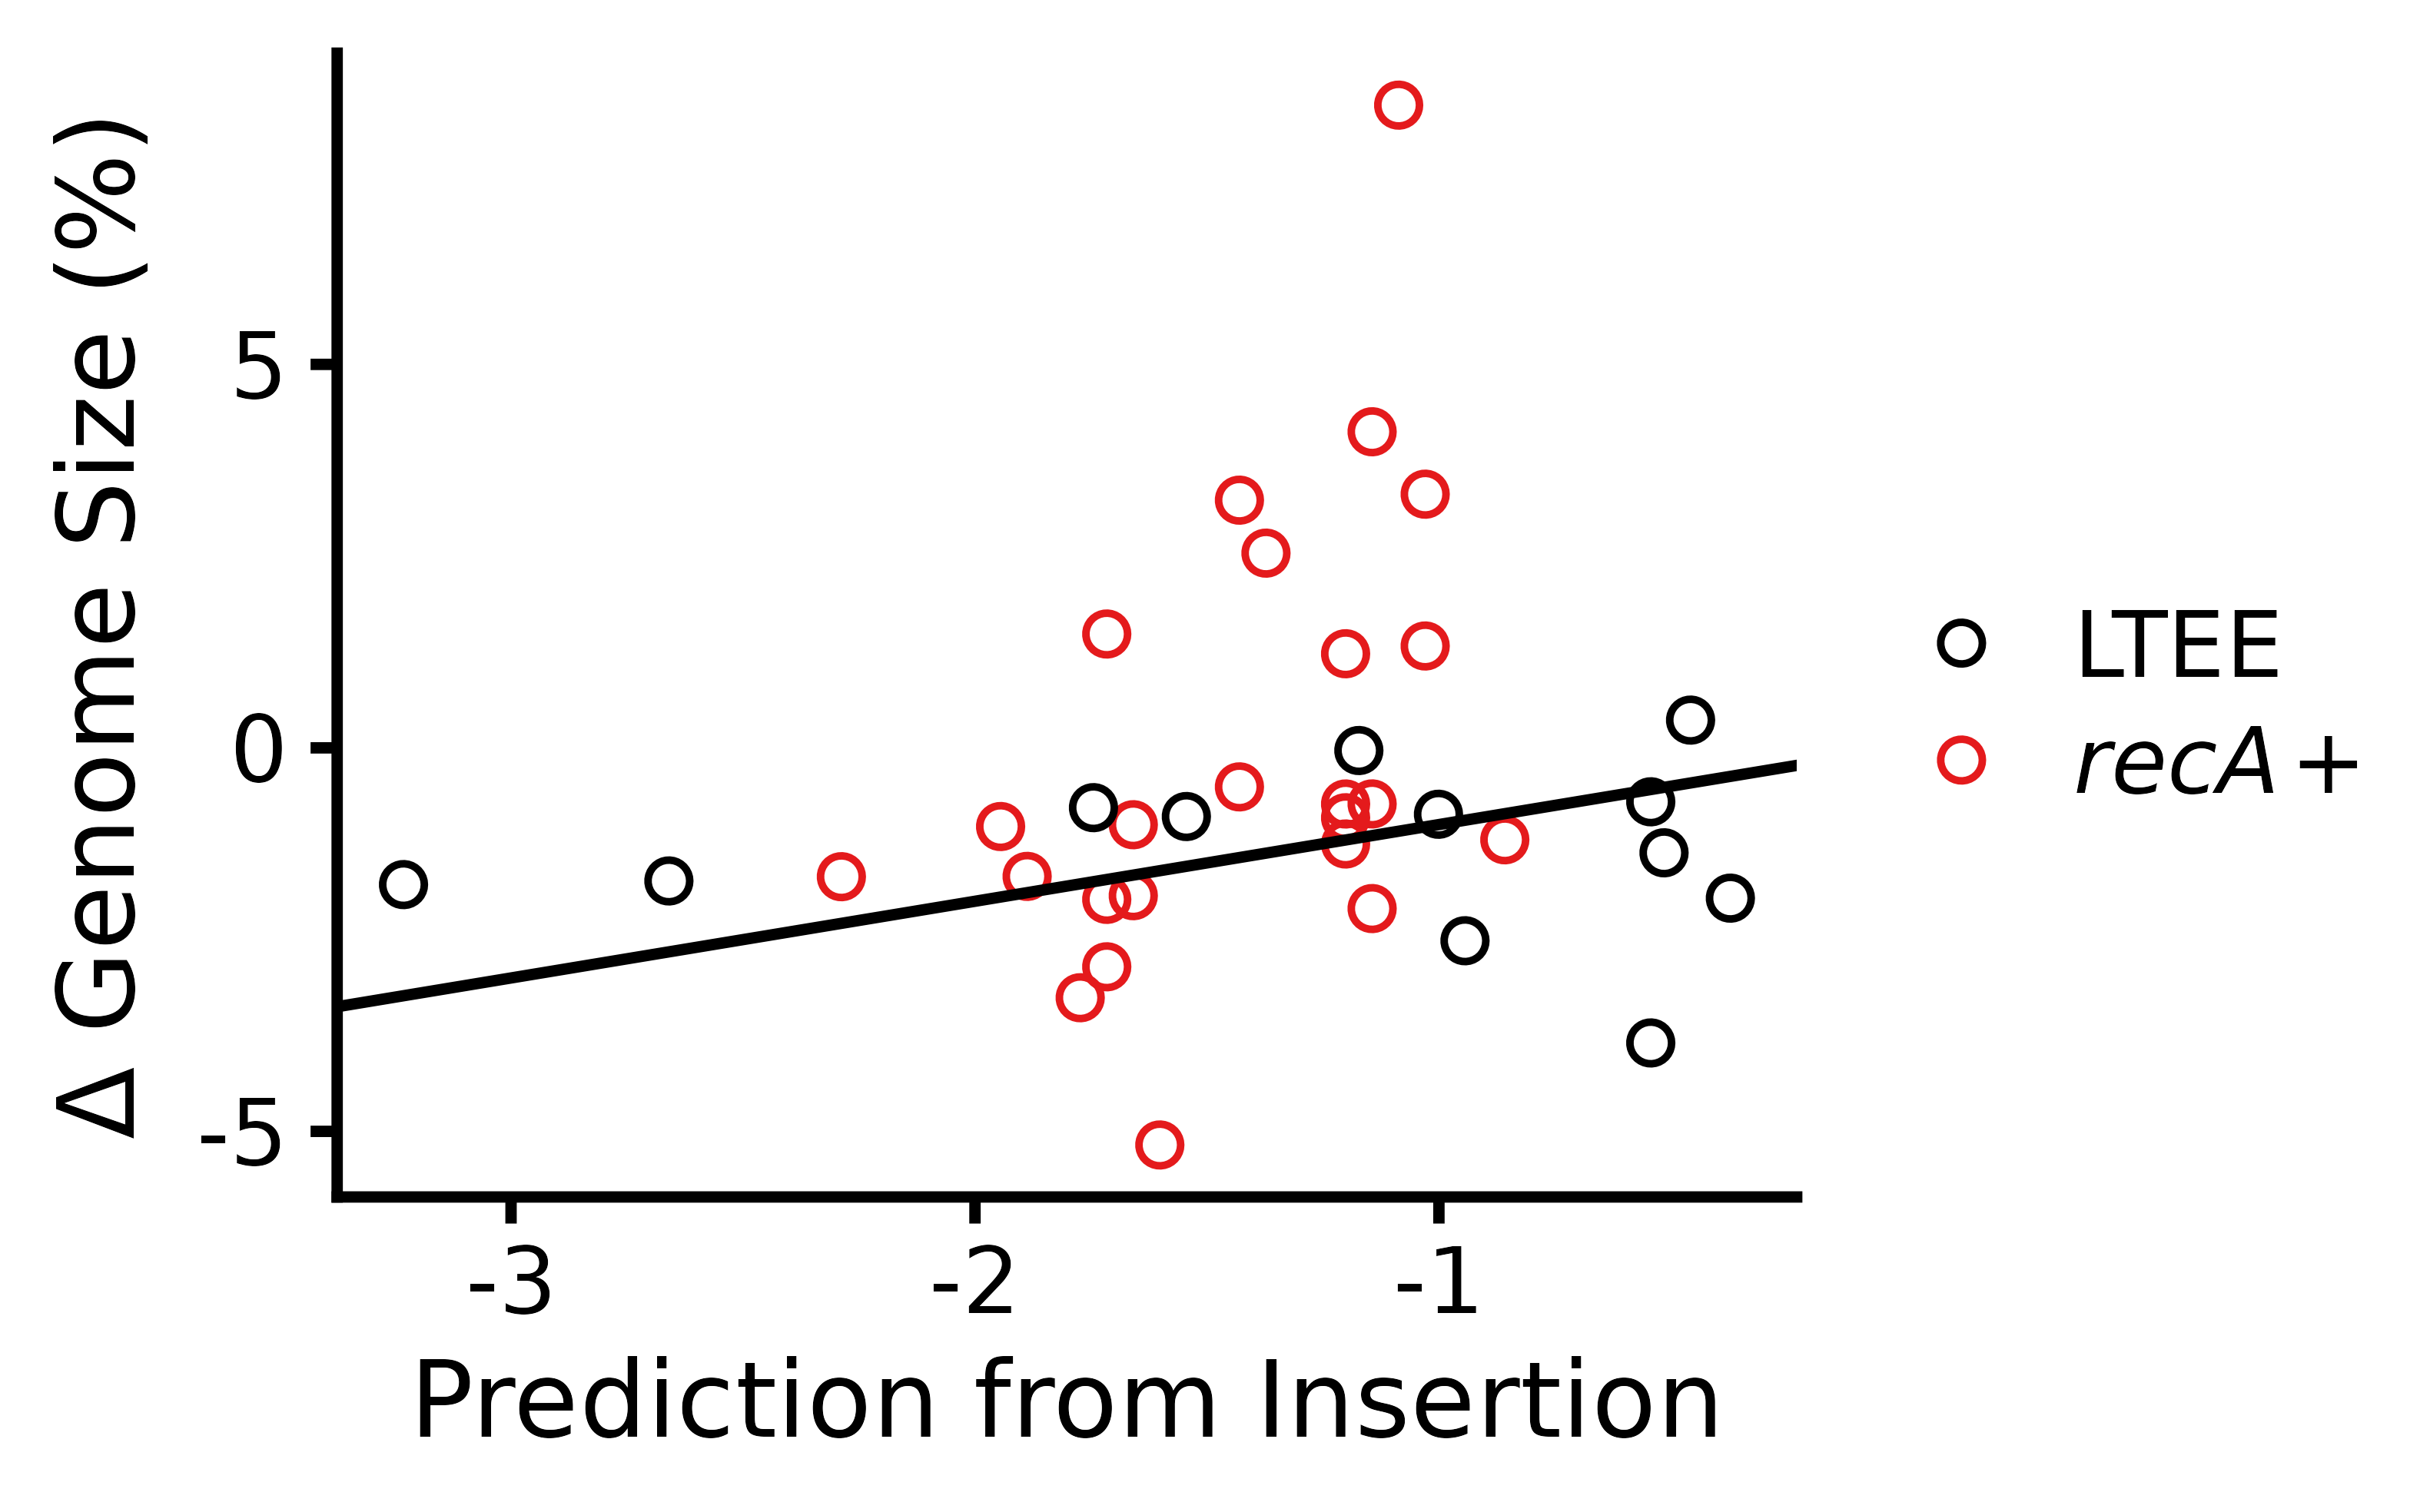

In [73]:
figure_name = file_prefix * "LTEE.IS.genome.change.ISadjust.NEssAdjust"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic("recA"), "+")))
p <- genome.size.IS.adjusted %>% 
filter(Source != "recA-") %>%
ggplot(aes(x = (INS * isev_vs_gsc_rate.median), y = genome_size_change.adjusted, color = Source)) +
geom_point(shape = 1) +
scale_color_manual(values = c("black", "#E41A1C"), labels = labs_, name ="") +
geom_abline(intercept = 0, slope = 1, size = .5) +
labs(x = "Prediction from Insertion", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

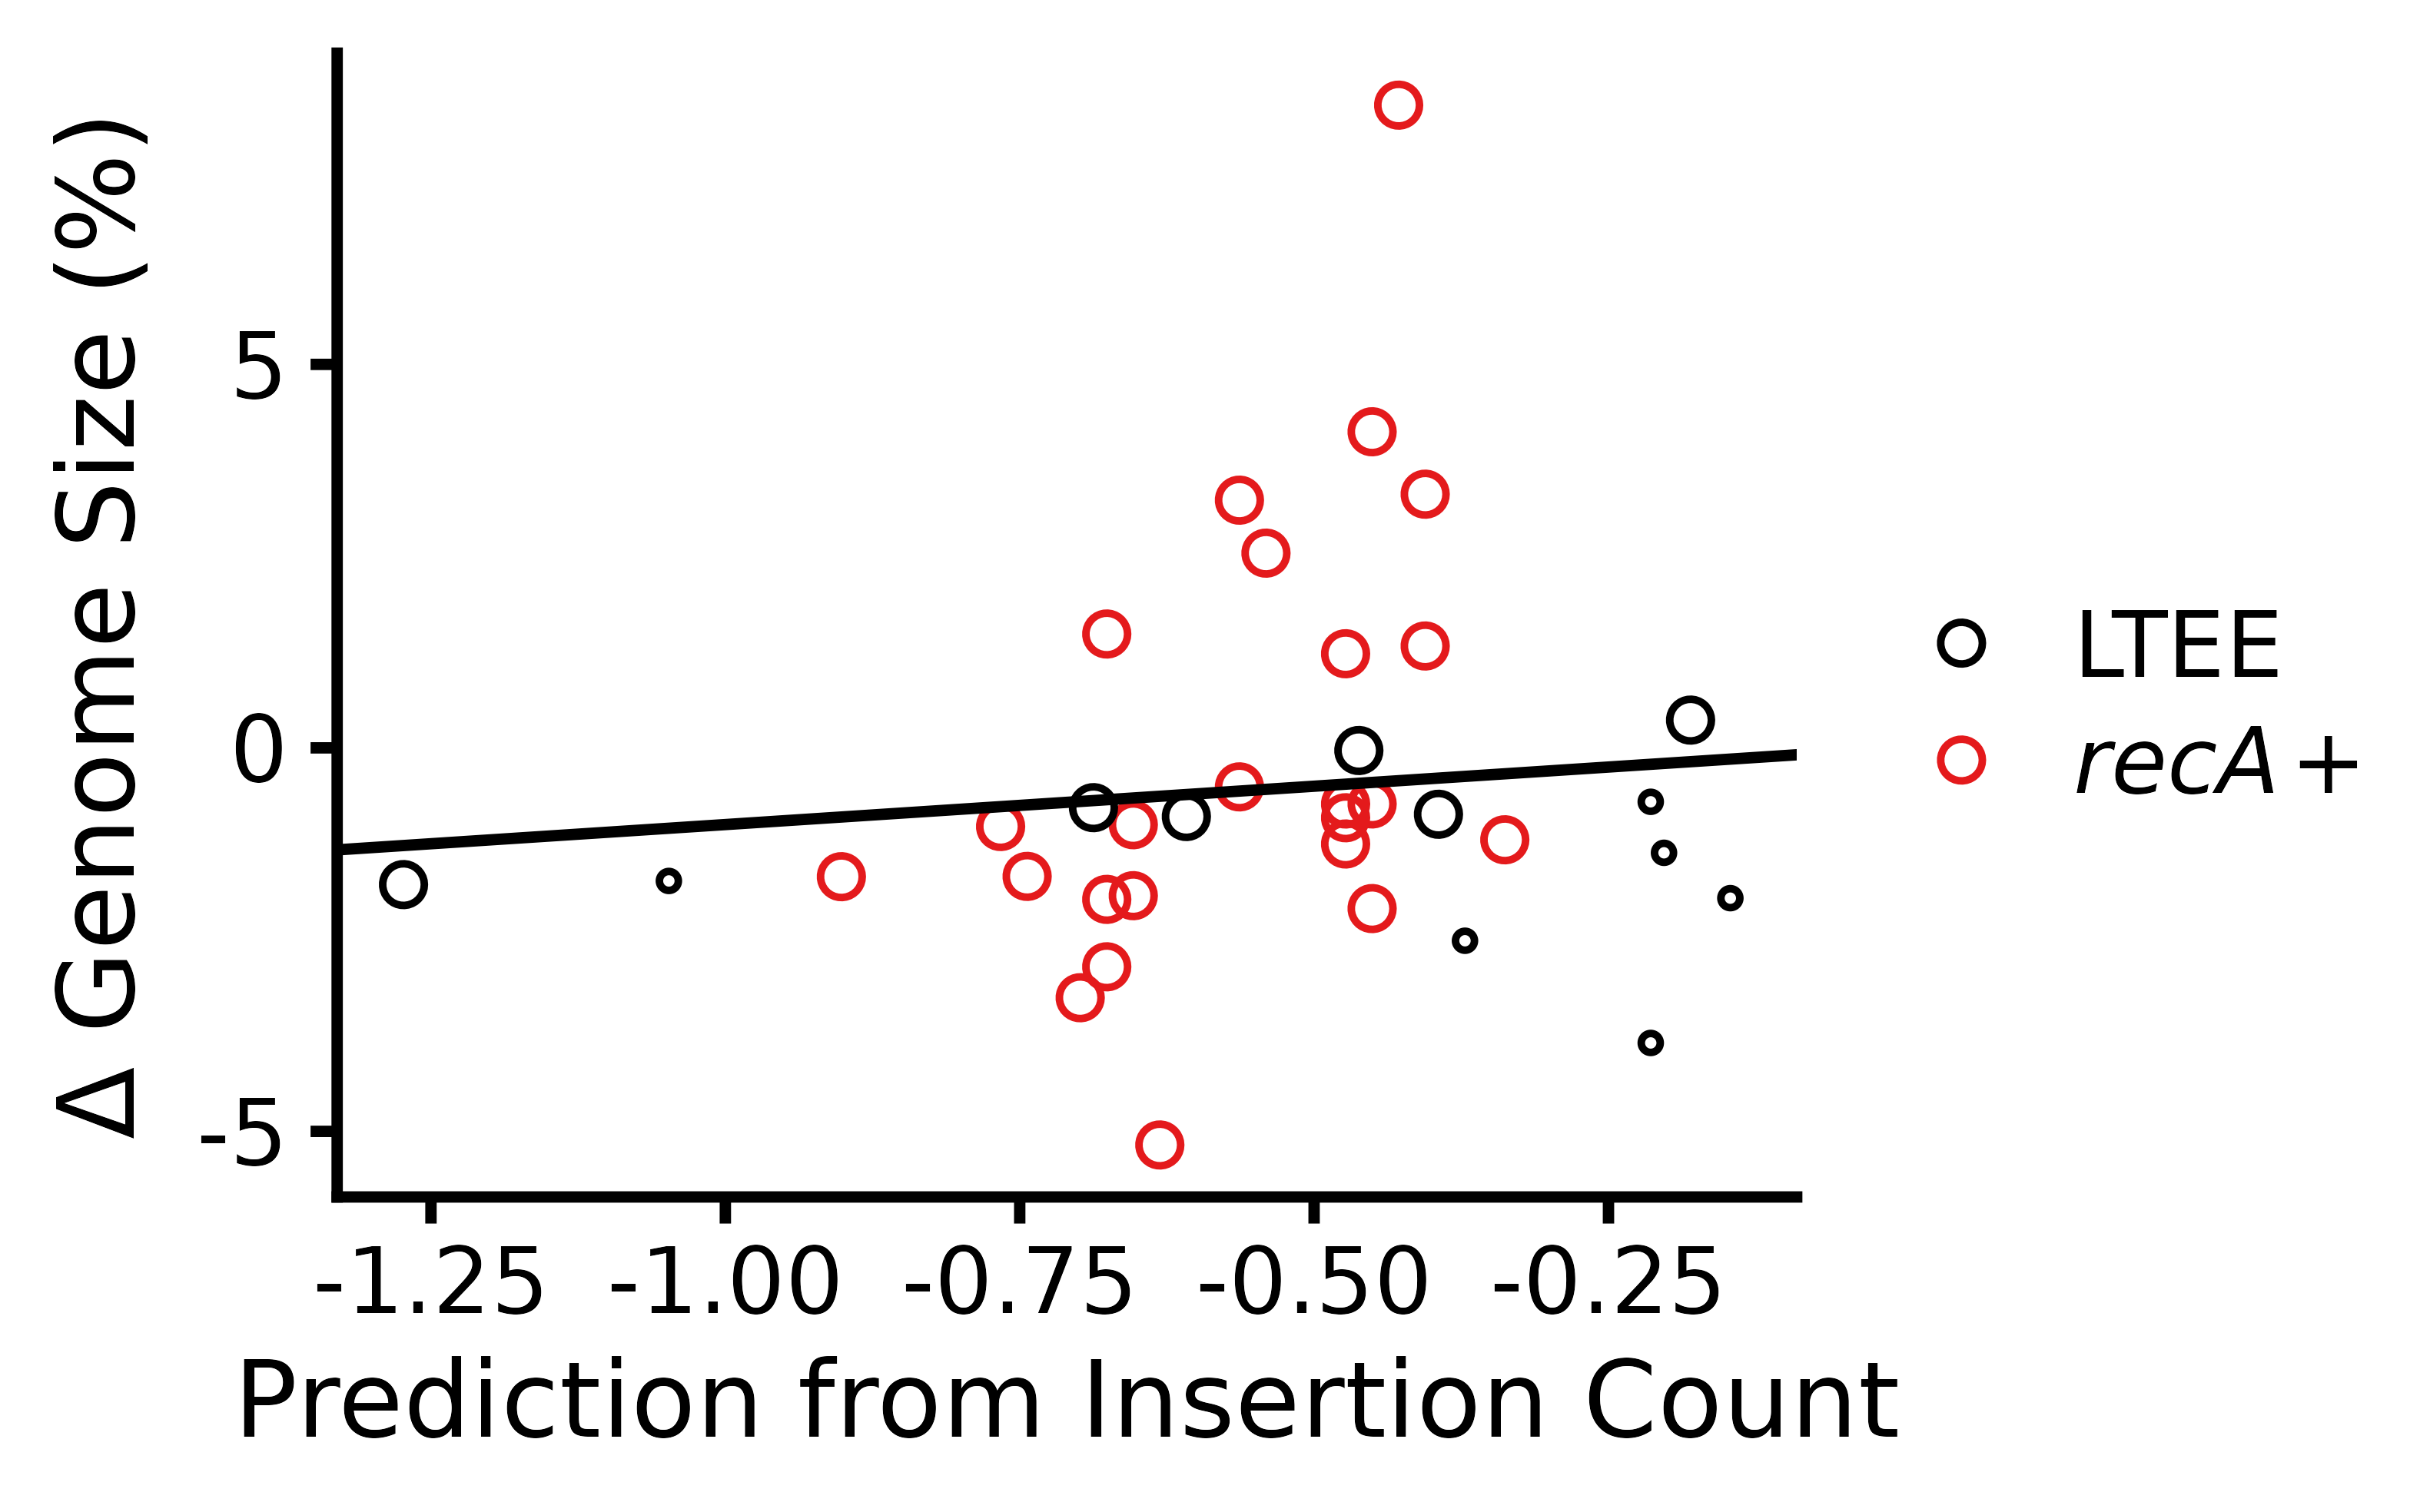

In [74]:
figure_name = file_prefix * "LTEE.IS.genome.change.ISadjust.nonmut.NEssAdjust"
@rput figure_name
R"""
labs_ <- c("LTEE", expression(paste(italic("recA"), "+")))
p <- genome.size.IS.adjusted %>% 
filter(Source != "recA-") %>%
mutate(invalid = ifelse(Source == "LTEE" & !population %in% LTEE.nonmutator, .25, .5)) %>%
ggplot(aes(x = (INS * isev_vs_gsc_rate.median.nonmut), y = genome_size_change.adjusted, color = Source)) +
geom_point(aes(size = invalid), shape = 1) +
scale_size_continuous(range = c(.5, 1.5)) +
scale_color_manual(values = c("black", "#E41A1C"), labels = labs_, name ="") +
geom_abline(intercept = 0, slope = 1, size = .5) +
# remove legend of invalid
guides(size=FALSE) +
labs(x = "Prediction from Insertion Count", y = TeX("$\\Delta$ Genome Size (%)"))+
theme_half_open(10) +
theme(legend.text.align = 0)

p.ISINS.genome.size <- p

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=80, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=80, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

## Merge fig

┌ Warning: RCall.jl: Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on '−' in 'mbcsToSbcs': dot substituted for <e2>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on '−' in 'mbcsToSbcs': dot substituted for <88>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on '−' in 'mbcsToSbcs': dot substituted for <92>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on '−' in 'mbcsToSbcs': dot substituted for <e2>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on '−' in 'mbcsToSbcs': dot substituted for <88>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conversion failure on '−' in 'mbcsToSbcs': dot substituted for <92>
│ Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
│   conver

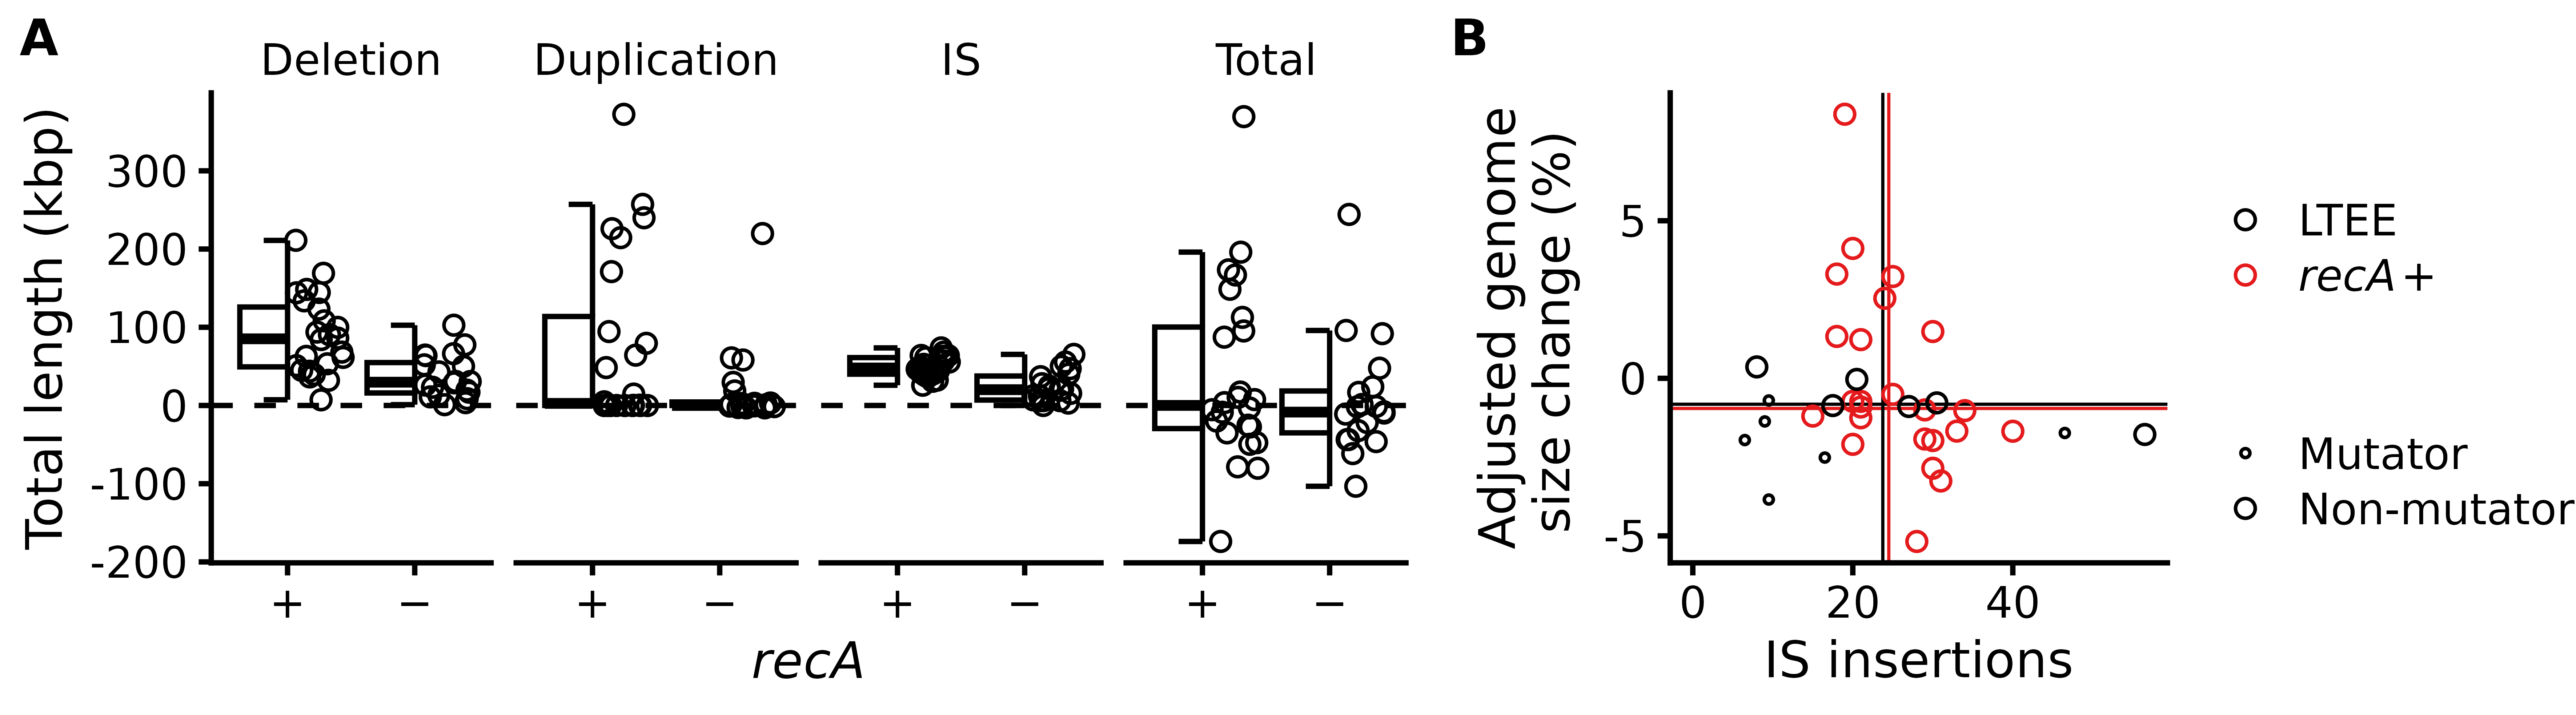

In [75]:
# combine the figures
figure_name = file_prefix * "sv_length_genome_size_adjusted"
@rput figure_name
R"""
p <- plot_grid(
	p.raw.genome.size, p.ISINS.genome.size.med, # p.genome.size.LTEE.Kanai,
	nrow =1, rel_widths = c(10, 8), align = "h", axis = "tb",
	labels = c("A", "B"), label_size = 10) + panel_border(remove = TRUE)

ggsave(paste0(figure_export_dir,"/", figure_name, ".png"), p, width=180, height=50, units="mm", dpi=1000)
ggsave(paste0(figure_export_dir,"/", figure_name, ".pdf"), p, width=180, height=50, units="mm", dpi=1000, device = cairo_pdf)
ggsave(paste0(figure_export_dir,"/", figure_name, ".svg"), p, width=180, height=50, units="mm", dpi=1000)
"""
display("image/png", read(joinpath(figure_export_dir, figure_name * ".png")))

## LTEE Genome size

In [83]:
# REF:LTEE-GENOME-SIZE-CHANGE
R"""
print("ALL")
genome.size.IS.adjusted %>% filter(Source == "LTEE") %>% 
	summarise(mean = 100*(mean(genome_size_change)-1), mean.length = mean(genome_size) - 4629812,
				median = 100*(median(genome_size_change)-1))  %>% print

print("non-mutator")
genome.size.IS.adjusted %>% filter(Source == "LTEE") %>% 
	filter(population %in% LTEE.nonmutator) %>%
	summarise(mean = 100*(mean(genome_size_change)-1),
				median = 100*(median(genome_size_change)-1)) %>% print
			# 95 CI and median CI
# sample sizes
print(paste("ALL: ", genome.size.IS.adjusted %>% filter(Source == "LTEE") %>% nrow))
print(paste("non-mutator: ", genome.size.IS.adjusted %>% filter(Source == "LTEE") %>% filter(population %in% LTEE.nonmutator) %>% nrow))
""";

[1] "ALL"
       mean mean.length    median
1 -1.343585   -62205.46 -1.131628
[1] "non-mutator"
        mean    median
1 -0.6658964 -0.822582
[1] "ALL:  12"
[1] "non-mutator:  6"


#### STAT: Bootstrap CI

In [87]:
R""" 
calculate_statistic <- function(data, indices) {
  sample <- data[indices, ]  # Resample the data
  return(c(mean = 100 * (mean(sample$genome_size_change) - 1),
           median = 100 * (median(sample$genome_size_change) - 1)))
}

# Assuming genome.size.IS.adjusted is your dataset
filtered_data <- genome.size.IS.adjusted %>%
  filter(Source == "LTEE", population %in% LTEE.nonmutator)

# Perform the bootstrap
set.seed(123)  # For reproducibility
bootstrap_results <- boot(data = filtered_data, statistic = calculate_statistic, R = 1000)

# Calculate 95% confidence intervals for both mean and median
boot.ci(bootstrap_results, type = "bca", index = 1) %>% print  # For mean
boot.ci(bootstrap_results, type = "all", index = 2) %>% print # For median used in main text

# sample size
print(paste("n = ", nrow(filtered_data)))
""";

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_results, type = "bca", index = 1)

Intervals : 
Level       BCa          
95%   (-1.1860, -0.1038 )  
Calculations and Intervals on Original Scale
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_results, type = "all", index = 2)

Intervals : 
Level      Normal              Basic         
95%   (-1.6537, -0.2568 )   (-1.8089, -0.3063 )  

Level     Percentile            BCa          
95%   (-1.3389,  0.1638 )   (-1.3389, -0.0345 )  
Calculations and Intervals on Original Scale
[1] "n =  6"


┌ Warning: RCall.jl: Warning in boot.ci(bootstrap_results, type = "all", index = 2) :
│   bootstrap variances needed for studentized intervals
└ @ RCall ~/.julia/packages/RCall/gOwEW/src/io.jl:172


## ANOVA: Cause of large divergence
It is likely duplications that makes the larges effect, but let's check.

In [78]:
R"""
lm.genome.size.IS.adjusted.var <-
	# the value of lm should be close to 1
	lm(d_genome_size.adjusted ~ d_is_length.adjusted + Deletion.adjusted + Duplication, 
		data = genome.size.IS.adjusted %>% filter(Source == "recA+"))
summary(lm.genome.size.IS.adjusted.var) %>% print
Anova(lm.genome.size.IS.adjusted.var, type = "III") %>% print
"""


Call:
lm(formula = d_genome_size.adjusted ~ d_is_length.adjusted + 
    Deletion.adjusted + Duplication, data = genome.size.IS.adjusted %>% 
    filter(Source == "recA+"))

Residuals:
    Min      1Q  Median      3Q     Max 
-339.74  -97.59  -30.96   59.49  607.83 

Coefficients:
                       Estimate Std. Error   t value Pr(>|t|)    
(Intercept)          -2.752e+02  1.652e+02    -1.666    0.111    
d_is_length.adjusted  1.029e+00  1.395e-02    73.794   <2e-16 ***
Deletion.adjusted    -1.000e+00  8.007e-04 -1249.417   <2e-16 ***
Duplication           9.990e-01  3.563e-04  2803.907   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 185.7 on 20 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 2.952e+06 on 3 and 20 DF,  p-value: < 2.2e-16

Anova Table (Type III tests)

Response: d_genome_size.adjusted
                         Sum Sq Df    F value Pr(>F)    
(Intercept)          9.5644e

RObject{VecSxp}
Anova Table (Type III tests)

Response: d_genome_size.adjusted
                         Sum Sq Df    F value Pr(>F)    
(Intercept)          9.5644e+04  1 2.7748e+00 0.1113    
d_is_length.adjusted 1.8770e+08  1 5.4456e+03 <2e-16 ***
Deletion.adjusted    5.3806e+10  1 1.5610e+06 <2e-16 ***
Duplication          2.7099e+11  1 7.8619e+06 <2e-16 ***
Residuals            6.8937e+05 20                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [79]:
R"""
## This does not make sense, as the lm would evidently output 1 for is_lengths and duplications and -1 for deletions.
lm.genome.size.IS.adjusted.var <-
	lm(d_genome_size ~ is_length + Deletion + Duplication, 
		data = genome.size.IS.adjusted %>% filter(Source == "recA+"))
summary(lm.genome.size.IS.adjusted.var) %>% print
Anova(lm.genome.size.IS.adjusted.var, type = "III") %>% print
"""


Call:
lm(formula = d_genome_size ~ is_length + Deletion + Duplication, 
    data = genome.size.IS.adjusted %>% filter(Source == "recA+"))

Residuals:
     Min       1Q   Median       3Q      Max 
-10474.4  -4952.0    984.5   4622.5  10304.9 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.281e+04  8.547e+03  -2.668   0.0148 *  
is_length    8.677e-01  1.092e-01   7.945  1.3e-07 ***
Deletion    -1.007e+00  2.867e-02 -35.119  < 2e-16 ***
Duplication  9.678e-01  1.322e-02  73.207  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6352 on 20 degrees of freedom
Multiple R-squared:  0.9974,	Adjusted R-squared:  0.997 
F-statistic:  2525 on 3 and 20 DF,  p-value: < 2.2e-16

Anova Table (Type III tests)

Response: d_genome_size
                Sum Sq Df   F value    Pr(>F)    
(Intercept) 2.8730e+08  1    7.1209   0.01476 *  
is_length   2.5466e+09  1   63.1182 1.297e-07 ***
Deletion    4.9760e+10  1 1

RObject{VecSxp}
Anova Table (Type III tests)

Response: d_genome_size
                Sum Sq Df   F value    Pr(>F)    
(Intercept) 2.8730e+08  1    7.1209   0.01476 *  
is_length   2.5466e+09  1   63.1182 1.297e-07 ***
Deletion    4.9760e+10  1 1233.3343 < 2.2e-16 ***
Duplication 2.1623e+11  1 5359.2889 < 2.2e-16 ***
Residuals   8.0692e+08 20                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Save env

In [81]:
@rput rdata_dir
R"""
# All objects that are not figures or tmps
objects_to_remove <- ls()[(map(ls(), ~{startsWith(., "p.") | startsWith(., "tmp") | . == "p"}) %>% unlist)]
print(objects_to_remove)
rm(list = objects_to_remove)
save(list = ls(), file = rdata_dir)
"""

character(0)


RObject{NilSxp}
NULL
